This notebook is a supplement to the paper "Compatibility and accessibility: lattice representations for semantics of non-classical and modal logic" (https://arxiv.org/abs/2201.07098) by Wesley H. Holliday (wesholliday@berkeley.edu).

# Notebook Outline

## I. [Supplement to Section 2](#I)

**I.I [Drawing compatibility frames](#I.I)**

**I.II [Calculating fixpoints of the closure operator](#I.II)**

**I.III [Hasse diagrams of the fixpoint lattices](#I.III)**

**I.IV [Generating compatibility frames up to isomorphism](#I.IV)**

**I.V [Generating fixpoint lattices up to isomorphism](#I.V)**

This section already verifies the part of Conjecture 3.13 in the paper for lattices of size $\leq 8$.

**I.VI [The $\neg_\vartriangleleft$ operation](#I.V)**


## II. [Supplement to Section 3.1](#II)

**II.I [The compatibility relation of Def. 3.5(i)](#II.1)**

**II.II [Finding join-irreducibles in the fixpoint lattice](#II.II)**

**II.III [Generating anti-inflationary functions](#II.III)**

**II.IV [Checking whether lattices can be represented as in Def. 3.5(i)](#II.IV)**

**II.V [Checking whether a lattice can be represented as in Def. 3.5(i) for a given $\neg$ and/or $\mathrm{V}$](#II.V)**

**II.VI [All lattices of size $\leq 7$ can be represented as in Def. 3.5(i)](#II.VI)**

**II.VII [Verification of Conjecture 3.13 for lattices up to size 14](#II.VII)**


## III. [Supplement to Appendix A.1](#III)

**III.I [Generating protocomplementations](#III.I)**

**III.II [Lattices for which no protocomplementation makes the representation of Def. 3.5(i) apply](#III.II)**

**III.III [Checking whether $(𝐿,¬)$ can arise from a compatibiltiy frame](#III.III)**

### Preliminaries

In [1]:
from itertools import chain, combinations
import copy
import networkx as nx
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
import pickle
from pprint import pprint
from tqdm.notebook import tqdm
from functools import partial
from itertools import product

In [2]:
def powerset(iterable):
    """powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"""
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [3]:
def f_generator(A, B):
    """generates all functions from A to B"""
    for b_values in product(B, repeat=len(A)):
        yield partial(lambda d, x: d[x], dict(zip(A, b_values)))

# I. Supplement to Section 2 <a id='I'></a>

## I.I Drawing compatibility frames <a id='I.I'></a>

According to Convention 2.2 in the paper, to represent the compatibility frame $(X,\vartriangleleft)$, we draw an arrow from $y$ to $x$ when $x\vartriangleleft y$. Thus, we draw the directed graph $(X,\vartriangleright)$ to represent the compatibility frame $(X,\vartriangleleft)$. Reflexive loops are not drawn.

In [4]:
def domain(rel):
    """given a reflexive relation, returns the domain of the relation"""
    X = {pair[0] for pair in rel}
    
    return X

In [5]:
def draw_flipped_digraph(rel,X = None):
    """given a relation rel on X, draw the digraph (with no loops) for the inverse of rel;
    if no X is given, we assume rel is reflexive and take X to be the domain of rel"""
    
    if X is None:
        X = domain(rel)
    
    g = nx.DiGraph()
    g.add_nodes_from(X)
    
    for pair in rel:
        if not pair[0] == pair[1]:
            g.add_edge(pair[1],pair[0])
    
    nx.draw(g)
    plt.show() 

## I.II Calculating fixpoints of the closure operator <a id='I.II'></a>

In [6]:
def closure(A,rel,X = None):
    """given a subset A of X, returns the closure of A according to the closure operator
    c_rel defined in Def. 2.4 of the paper from the given relation rel on X;
    if no X is given, we assume rel is reflexive and take X to be the domain of rel"""

    if X is None:
        X = domain(rel)
    
    Aset = set(A)
    Xset = set(X)
    closure = [x for x in A]
   
    for x in Xset - Aset:
        x_sees = {y for y in X if (y,x) in rel}
        seen_by_A = {z for z in X if any([pair[0]==z and pair[1] in Aset for pair in rel])}
        if x_sees.issubset(seen_by_A):
            closure.append(x)
        
    return closure

For small compatibility frames, we can simply check for each subset whether it is a fixpoint of the closure operator.

In [7]:
def fixpoints(rel,X = None):
    """given a binary relation rel on X, returns the fixpoints of c_rel according to Def. 2.4 in the paper"""

    if X is None:
        X = domain(rel)
    
    fixpts = [(), tuple(X)]
    
    pwrset = powerset(X)

    for A in pwrset:
        if A == () or A == tuple(X):
            continue
            
        if A == tuple(closure(A,rel,X)):
            fixpts.append(A)

    return fixpts

To handle larger compatibility frames, we can use Ganter's algorithm to calculate fixpoints of a closure operator (Ganter B. (2010), "Two Basic Algorithms in Concept Analysis." In: Kwuida L., Sertkaya B. (eds) Formal Concept Analysis. ICFCA 2010. *Lecture Notes in Computer Science*, vol 5986. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-11928-6_22). 

Ganter's algorithm assumes a closure operator on the powerset of a set $X$ where $X$ is an initial segment of the natural numbers (or otherwise linearly ordered). Thus, we include a function to convert a given compatibility frame to an isomorphic copy whose domain is an initial segment of the natural numbers.

In [8]:
def convert_to_nums(rel, X = None):
    """Given a compatibility frame, return an isomorphic copy
    whose domain is an initial segment of the natural numbers plus
    a dictionary to go back from natural numbers to the original elements"""
    
    if X is None:
        X = domain(rel)
    
    forward_map = {}
    inverse_map = {}
    count = 0
    
    for x in X:
        forward_map[x] = count
        inverse_map[count] = x
        count += 1   
    
    newrel = []
    
    for pair in rel:
        newrel.append((forward_map[pair[0]],forward_map[pair[1]]))
    
    return newrel, inverse_map

We implement the algorithm on p. 316 of Ganter's paper with the following two functions.

In [9]:
def next_fixpoint(A, rel, X = None):
    """Given a compatibility frame rel on an initial segment of the natural numbers
    and a subset A, assumed to be a fixpoint, calculate the next fixpoint
    according to Ganter's lectic ordering"""
    
    if X is None:
        X = domain(rel)
        
    Aset = set(A)
    
    for i in reversed(X):
        if not i in Aset:
            iset = set(range(i))
            inter = Aset.intersection(iset)
            union = inter.union({i})
            Anext = closure(union, rel, X)
            if [j for j in Anext if j<i and not j in Aset] == []:
                return tuple(Anext)  

In [10]:
def Ganter_fixpoints(rel, X = None):
    """Given a compatibility frame rel, return the fixpoints according to Ganter's algorithm;
    if rel is not already on an initial segment of the natural numbers, 
    apply convert_to_nums in order to run next_fixpoint and then apply 
    the inverse map to get corresponding fixpoints for the original rel"""
    
    if X is None:
        X = domain(rel)
        
    if tuple(X) == tuple(range(len(X))):
        
        listX = list(X)
        tupX = tuple(X)
    
        fixpts = [()]
        A = ()
    
        while not A == tupX:
            A_next = next_fixpoint(A,rel,listX)
            A = A_next
            fixpts.append(A_next)
        
        return fixpts
    
    else:
        conv = convert_to_nums(rel, X)
        newrel = conv[0]
        inverse = conv[1]
        newX = domain(newrel)
        
        listX = list(newX)
        tupX = tuple(newX)
        
        fixpts = [()]
        A = ()
    
        while not A == tupX:
            A_next = next_fixpoint(A,newrel,listX)
            A = A_next
            A_next_inverse = tuple({inverse[a] for a in A_next})
            fixpts.append(A_next_inverse)
        
        return fixpts

### Examples

In [11]:
# when defining compatibility frames, 
# in order to avoid entering pairs (x,x) manually, we use the following:

def reflexive_closure(rel,X):
    """given a binary relation rel on X, returns the reflexive closure of rel"""
    relset = set(rel)

    for x in X:
        if not (x,x) in relset:
            rel.append((x,x))
    return rel

Fig. 1, left:


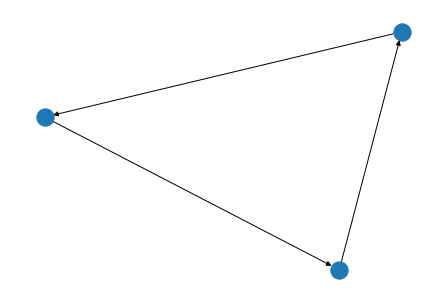

compatibility frame: [(0, 1), (1, 2), (2, 0), (0, 0), (1, 1), (2, 2)]
fixpoints: [(), (0, 1, 2), (0,), (1,), (2,)]


Fig. 1, right:


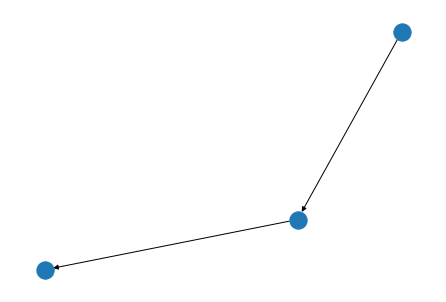

compatibility frame: [(1, 0), (2, 1), (0, 0), (1, 1), (2, 2)]
fixpoints: [(), (0, 1, 2), (0,), (2,), (1, 2)]


Fig. 2:


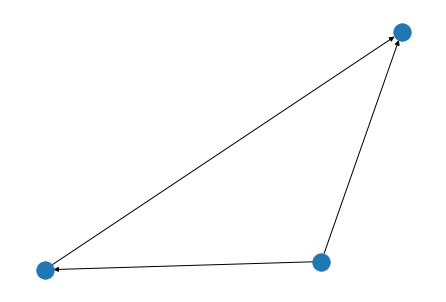

compatibility frame: [(1, 0), (2, 1), (2, 0), (0, 0), (1, 1), (2, 2)]
fixpoints: [(), (0, 1, 2), (2,), (1, 2)]


Fig. 3, left:


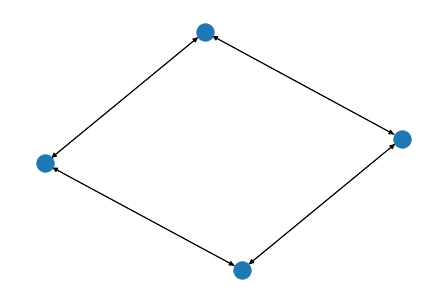

compatibility frame: [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 0), (0, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (2,), (3,)]


Fig. 3, right:


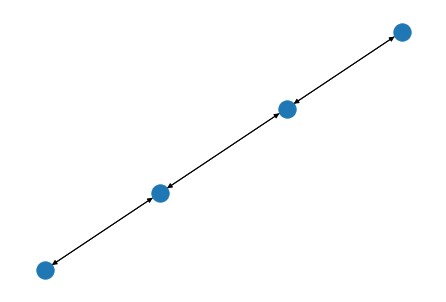

compatibility frame: [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0, 1, 2, 3), (0,), (3,), (0, 1), (2, 3)]


Fig. 6:


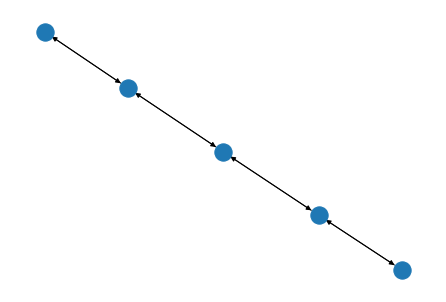

compatibility frame: [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
fixpoints: [(), (0, 1, 2, 3, 4), (0,), (2,), (4,), (0, 1), (0, 4), (3, 4), (0, 1, 2), (2, 3, 4)]


Fig. A.1:


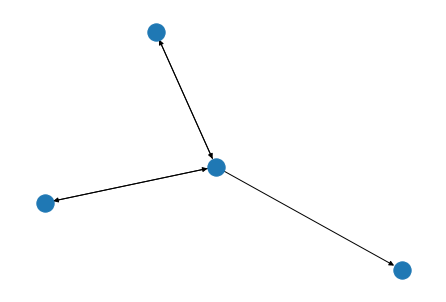

compatibility frame: [(0, 3), (1, 3), (3, 1), (2, 3), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (2,), (0, 1), (0, 2), (1, 2)]


Another example not in the paper:


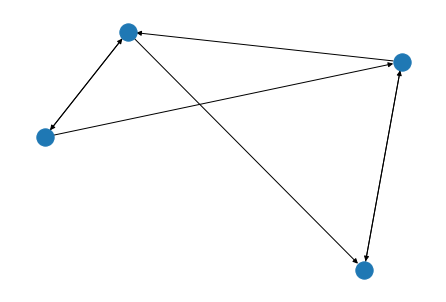

compatibility frame: [(1, 0), (1, 2), (2, 1), (0, 3), (3, 0), (3, 1), (2, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0, 1, 2, 3), (0,), (2,), (3,), (1, 2)]




In [12]:
# below we reproduce all examples from figures in the paper:

exs = {0: ("Fig. 1, left:",reflexive_closure([(0,1),(1,2),(2,0)],range(3))), 
       1: ("Fig. 1, right:",reflexive_closure([(1,0),(2,1)],range(3))),
       2: ("Fig. 2:",reflexive_closure([(1,0),(2,1),(2,0)],range(3))),
       3: ("Fig. 3, left:",reflexive_closure([(0,1),(1,0),(1,2),(2,1),(2,3),(3,2),(3,0),(0,3)],range(4))),
       4: ("Fig. 3, right:",reflexive_closure([(0,1),(1,0),(1,2),(2,1),(2,3),(3,2)],range(4))),
       5: ("Fig. 6:",reflexive_closure([(0,1),(1,0), (1,2), (2,1), (2,3), (3,2),(3,4),(4,3)],range(5))),
       6: ("Fig. A.1:",reflexive_closure([(0,3), (1,3), (3,1), (2,3), (3,2)],range(4))),
       7: ("Another example not in the paper:",reflexive_closure([(1,0),(1,2),(2,1),(0,3),(3,0),(3,1),(2,3)],range(4)))
      }
   
for i in range(8):
    print(exs.get(i)[0])
    draw_flipped_digraph(exs.get(i)[1])
    print(f"compatibility frame: {exs.get(i)[1]}")
    print(f"fixpoints: {fixpoints(exs.get(i)[1])}")
    print("\n")
    
# saving the last example for later:

example_rel = reflexive_closure([(1,0),(1,2),(2,1),(0,3),(3,0),(3,1),(2,3)],range(4))
example_fixpts = fixpoints(example_rel)

## I.III Hasse diagrams of the fixpoint lattices <a id='I.III'></a>

Given a family of fixpoints, we first calculate the proper subset relation between fixpoints, then calculate the associated covering relation, and finally create a networkx digraph for the Hasse diagram of the fixpoint lattice.

In [13]:
def propsubrel(lt):
    """given a list of tuples representing a set of sets, returns the proper subset relation as a list of pairs"""
    propsubrel = []
    
    for A in lt:
        for B in lt:  
            if set(A).issubset(set(B)) and not set(B).issubset(set(A)):
                propsubrel.append((A,B))
                
    return propsubrel

In [14]:
print(propsubrel(example_fixpts))

[((), (0, 1, 2, 3)), ((), (0,)), ((), (2,)), ((), (3,)), ((), (1, 2)), ((0,), (0, 1, 2, 3)), ((2,), (0, 1, 2, 3)), ((2,), (1, 2)), ((3,), (0, 1, 2, 3)), ((1, 2), (0, 1, 2, 3))]


In [15]:
def covering(spo):
    """given a strict partial order spo, returns the associated covering relation"""
    cover = copy.deepcopy(spo)
    for p1 in spo:
        for p2 in spo:
            if p1 in cover and p1[0] == p2[0] and (p2[1],p1[1]) in spo:
                cover.remove(p1)
                break
    return cover

In [16]:
print(covering(propsubrel(example_fixpts)))

[((), (0,)), ((), (2,)), ((), (3,)), ((0,), (0, 1, 2, 3)), ((2,), (1, 2)), ((3,), (0, 1, 2, 3)), ((1, 2), (0, 1, 2, 3))]


In [17]:
def lattice(rel,X = None):
    """given a relation rel on X, returns the Hasse diagram of the lattice of fixpoints"""
    
    if X is None:
        X = set([pair[0] for pair in rel]) 
        
    fix = fixpoints(rel,X)
    cover = covering(propsubrel(fix))
    l = nx.DiGraph()
    l.add_nodes_from(fix)
    l.add_edges_from(cover) 
    
    return l

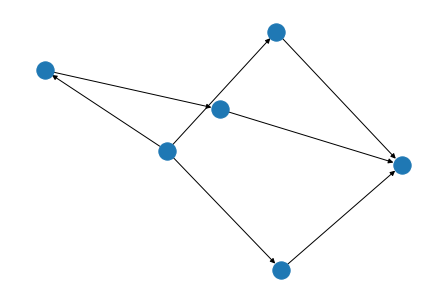

In [18]:
l = lattice(example_rel)

nx.draw(l)
plt.show() 

## I.IV Generating compatibility frames up to isomorphism  <a id='I.IV'></a>

In this section, we generate all compatibility frames of size $n$ up to isomorphism by generating all directed graphs (without loops) of size $n$ up to isomorphism and then adding all reflexive loops.

To obtain all directed graphs of size $n$ up to isomorphism, we use nauty:

http://users.cecs.anu.edu.au/~bdm/nauty/

B. D. McKay and A. Piperno, Practical Graph Isomorphism, II, J. Symbolic Computation (2013) 60 94-112. https://doi.org/10.1016/j.jsc.2013.09.003. Preprint version at https://arxiv.org/abs/1301.1493.

After installing nauty, the command line command

geng n | directg -T > digraphs_n.txt

outputs all directed graphs of size $n$ up to isomorphism in digraphs_n.txt. I stored digraphs_1.txt through digraphs_5.txt in the digraphs directory in GitHub. The file digraphs_6.txt was too large (at 100 MB), but it can be generated locally as above.

Each line of digraphs_n.txt has the following format:

num_vertices num_edges edges.

The integer sequence for the number of nonempty directed graphs up to isomorphism with $n$ nodes (https://oeis.org/A000273) begins as follows: $1, 3, 16, 218, 9608, 1540944, 882033440, \dots$

In [19]:
def readgraphs(filename):
    """converts each line from the nauty output file into a list of pairs representing edges"""
    file = open(filename)
    lines = file.readlines()
    graphs = []

    for line in lines:
        edges = []
        l = line.split(" ")
        num_vertices = int(l[0])
        num_edges = int(l[1])
        for i in range(num_edges):
            edges.append( (int(l[2*i+2]), int(l[2*i+3]) ))
        graphs.append(edges)

    return graphs

In [20]:
def make_reflexive(rels,X):
    """given a list of relations, returns the reflexive closures of each"""
    newrels = []
    for rel in rels:
        newrel = reflexive_closure(rel,X)
        newrels.append(newrel)
    return newrels

In [21]:
def comp_frames_size(n):
    """returns a representative of each isomorphism class of compatibiliy frames of size n"""
    dgs = readgraphs(f"digraphs/digraphs{n}.txt")
    rdgs = make_reflexive(dgs,range(n))
    
    return rdgs

In [22]:
print(len(comp_frames_size(5)))

9608


## I.V Generating fixpoint lattices up to isomorphism  <a id='I.V'></a>

Using a naive approach, we can fairly quickly generate all fixpoints lattices up to isomorphism arising from directed graphs of size $\leq 5$ up to isomorphism. Doing so for directed graphs of size $6$ takes much longer.

The integer sequence for the number of nondegenerate lattices up to isomorphism with n nodes (https://oeis.org/A006966) begins as follows: $1, 1, 1, 2, 15, 53, 222, 1078, 5994 \dots$

In [23]:
num_lats_of_size = {2: 1, 3: 1, 4: 1, 5: 2, 6: 15, 7: 53, 8: 222}

In [24]:
def all_lattices(rels):
    """given a collection rels of relations, returns all the fixpoint lattices"""
    
    lattices = []
    
    for rel in tqdm(rels):
        l = lattice(rel)
        lattices.append(l)
       
    return lattices

In [25]:
def lattices(rels):
    """given a collection rels of relations, returns all the fixpoint lattices up to isomorphism"""

    lattices = []

    for rel in tqdm(rels):
        l = lattice(rel)
        newlat = True
        for l2 in lattices:
            if nx.is_isomorphic(l,l2):
                newlat = False
                break
        if newlat:
            lattices.append(l)
       
    return lattices

In [26]:
def lattices_size(rels, n):
    """given a collection rels of relations, returns all the fixpoint lattices of size n up to isomorphism"""

    lattices = []

    for rel in tqdm(rels):
        if len(fixpoints(rel)) == n:
            l = lattice(rel)
            newlat = True
            for l2 in lattices:
                if nx.is_isomorphic(l,l2):
                    newlat = False
                    break
            if newlat:
                lattices.append(l)
      
    return lattices

In [27]:
def lattices_keep_rels(rels):
    """given a collection rels of relations, returns all the fixpoint lattices up to isomorphism,
    plus the relation from which each came"""

    rel_lat = []

    for rel in tqdm(rels):
        l = lattice(rel)
        newlat = True
        for pair in rel_lat:
            l2 = pair[1]
            if nx.is_isomorphic(l,l2):
                newlat = False
                break
        if newlat:
            rel_lat.append((rel,l))
       
    return rel_lat

In [28]:
def num_each_size(lats):
    """returns the number of lattices in lats of each size"""
    d = {}
    
    for l in lats:
        num = len(l.nodes)
        if num in d.keys():
            d[num] = d[num]+1
        if not num in d.keys():
            d[num] = 1
            
    return d

### Lattices from compatibility frames of size 1-4

In [29]:
lattices_keep_rels_from_comp_frames_size = {n: lattices_keep_rels(comp_frames_size(n)) for n in range(1,5)}

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

In [30]:
lattices_from_comp_frames_size = {n: lattices(comp_frames_size(n)) for n in range(1,5)}

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

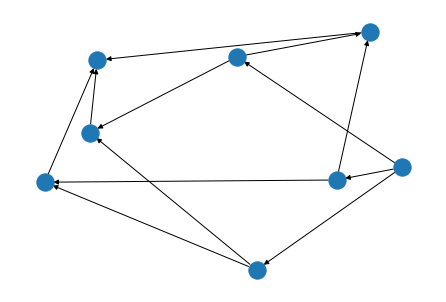

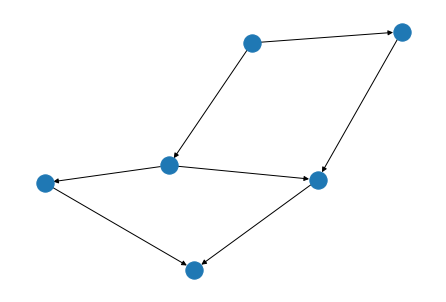

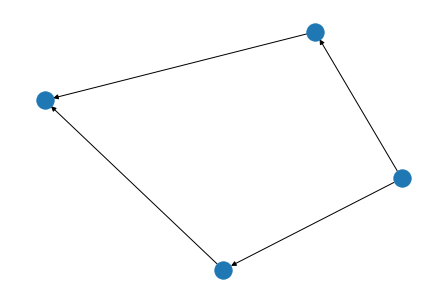

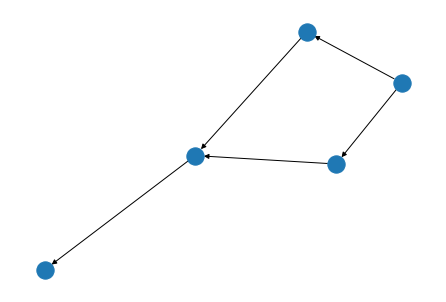

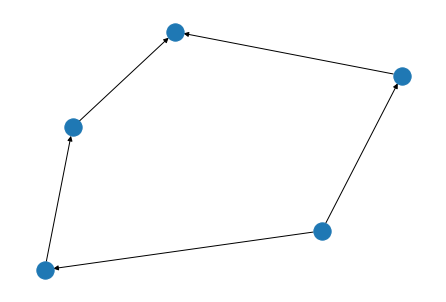

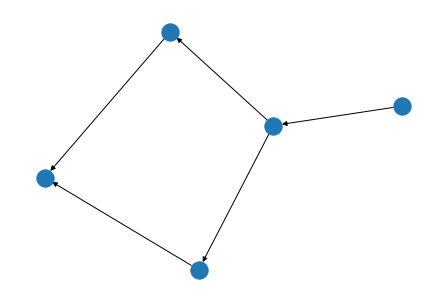

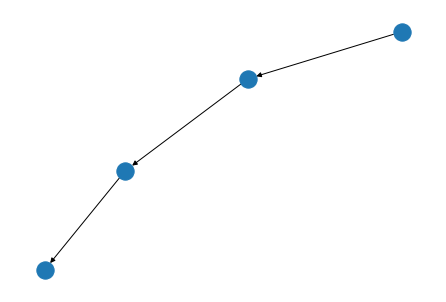

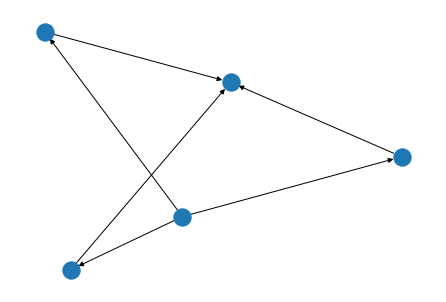

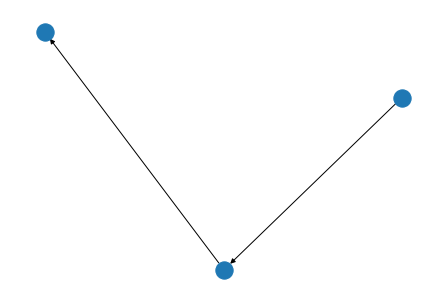

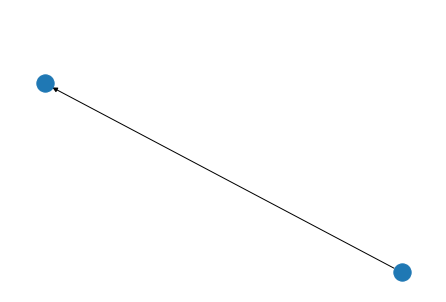

In [31]:
for l in lattices_from_comp_frames_size[3]:
        nx.draw(l)
        plt.show() 
        print("\n")

In [32]:
for n in range(1,5):
    print(f"Number of compatibility frames of size {n} up to iso: {len(comp_frames_size(n))}")
    print(f"Number of lattices up to iso from compatibility frames of size {n}: {len(lattices_from_comp_frames_size[n])}")
    print("\n")

Number of compatibility frames of size 1 up to iso: 1
Number of lattices up to iso from compatibility frames of size 1: 1


Number of compatibility frames of size 2 up to iso: 3
Number of lattices up to iso from compatibility frames of size 2: 3


Number of compatibility frames of size 3 up to iso: 16
Number of lattices up to iso from compatibility frames of size 3: 10


Number of compatibility frames of size 4 up to iso: 218
Number of lattices up to iso from compatibility frames of size 4: 59




In [33]:
for n in range(1,5):
    d = num_each_size(lattices_from_comp_frames_size[n])
    print(f"Number of lattices of each size arising from compatibility frames of size {n}:")
    pprint(d)
    print("\n")

Number of lattices of each size arising from compatibility frames of size 1:
{2: 1}


Number of lattices of each size arising from compatibility frames of size 2:
{2: 1, 3: 1, 4: 1}


Number of lattices of each size arising from compatibility frames of size 3:
{2: 1, 3: 1, 4: 2, 5: 4, 6: 1, 8: 1}


Number of lattices of each size arising from compatibility frames of size 4:
{2: 1, 3: 1, 4: 2, 5: 5, 6: 14, 7: 14, 8: 6, 9: 9, 10: 5, 12: 1, 16: 1}




The computation above shows (recall https://oeis.org/A006966) that all lattices of size $\leq 5$ can be represented as lattices of fixpoints arising from compatibility frames of size $4$. Moreover, $14$ of the $15$  lattices of size $6$ up to isomorphism can be so represented. The missing one is the $6$-element chain arising as the fixpoint lattice of the $5$-element linear order, as we verify below.

In [34]:
def linear_order(n):
    """returns the n-element linear order as a list of pairs"""
    l = []

    for i in range(n):
        for j in range (n):
            if i<=j:
                l.append((i,j))
            
    return l

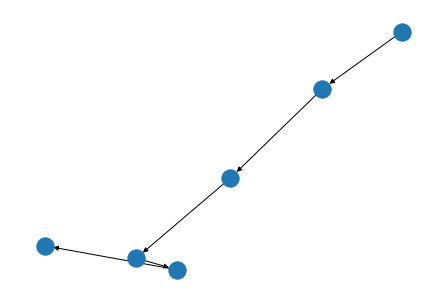

In [35]:
l = lattice(linear_order(5))

nx.draw(l)
plt.show() 

In [36]:
def iso_copy_in(lat,lats):
    """checks whether lats contains an isomorphic copy of lat"""
    iso = False
    for l in lats:
        if l.nodes == lat.nodes:
            if nx.is_isomorphic(lat,l):
                iso = True
                break
    return iso

In [37]:
iso_copy_in(lattice(linear_order(5)),lattices_from_comp_frames_size[4])

False

### Lattices from compatibility frames of size 5

We separate the generation of lattices up to isomorphism from compatibility frames of size 5, since this takes a bit longer.

In [38]:
lattices_keep_rels_from_comp_frames_size[5] = lattices_keep_rels(comp_frames_size(5))

  0%|          | 0/9608 [00:00<?, ?it/s]

In [39]:
lattices_from_comp_frames_size[5] = [pair[1] for pair in lattices_keep_rels_from_comp_frames_size[5]]

In [40]:
n=5

print(f"Number of compatibility frames of size {n} up to iso: {len(comp_frames_size(n))}")
print(f"Number of lattices up to iso from compatibility frames of size {n}: {len(lattices_from_comp_frames_size[n])}")

Number of compatibility frames of size 5 up to iso: 9608
Number of lattices up to iso from compatibility frames of size 5: 876


In [41]:
n=5

d = num_each_size(lattices_from_comp_frames_size[n])
print(f"Number of lattices of each size arising from compatibility frames of size {n}:")
pprint(d)

Number of lattices of each size arising from compatibility frames of size 5:
{2: 1,
 3: 1,
 4: 2,
 5: 5,
 6: 15,
 7: 52,
 8: 112,
 9: 130,
 10: 151,
 11: 159,
 12: 91,
 13: 60,
 14: 41,
 15: 15,
 16: 9,
 17: 16,
 18: 9,
 20: 5,
 24: 1,
 32: 1}


The computation above shows (recall https://oeis.org/A006966) that all lattices of size $\leq 6$ can be represented as lattices of fixpoints arising from diagraphs of size $5$. Moreover, $52$ of the $53$ lattices of size $7$ up to isomorphism can be so represented. The missing one is the $7$-element chain arising as the fixpoint lattice of the $6$-element linear order, as we verify below.

In [42]:
iso_copy_in(lattice(linear_order(6)),lattices_from_comp_frames_size[5])

False

Compatibility frames are significantly smaller than the lattices they represent. As shown below, 5-element compatibility frames are on average 59% the size of the lattices they represent.

In [43]:
n=5

comp_frame_elements = 0
lattice_elements = 0

for rel in tqdm(comp_frames_size(n)):
    comp_frame_elements += n
    lattice_elements += len(lattice(rel).nodes)

print(comp_frame_elements / lattice_elements)  

  0%|          | 0/9608 [00:00<?, ?it/s]

0.5942970248036124


### Lattices from compatibility frames of size 6

The generation of all lattices up to isomorphism from compatibility frames of size 6 takes several weeks of computation. I iterated through all 1,540,944 compatibility frames of size 6: for each frame $\mathcal{F}$, if its fixpoint lattice was not isomorphic to the fixpoint lattice of any frame previously considered, then I saved $\mathcal{F}$ to a pickle file. The result is in /generated/comp_frames_size_6_up_to_iso_of_lats.pkl.

In [44]:
comp_frames_size_6_up_to_iso_of_lats = pickle.load(open("generated/comp_frames_size_6_up_to_iso_of_lats.pkl", "rb"))

In [45]:
len(comp_frames_size_6_up_to_iso_of_lats)

42943

In [46]:
# Verifying that none of the compatibility frames in comp_frames_size_6_up_to_iso_of_lats.pkl 
# generate isomorphic fixpoint lattices takes several hours

# filter_iso = lattices(comp_frames_size_6_up_to_iso_of_lats)
# print(len(filter_iso))

In [47]:
# Since none of the compatibility frames in comp_frames_size_6_up_to_iso_of_lats.pkl 
# generate isomorphic fixpoint lattices, we can use all_lattices instead of lattices here:

lattices_from_comp_frames_size[6] =  all_lattices(comp_frames_size_6_up_to_iso_of_lats)

  0%|          | 0/42943 [00:00<?, ?it/s]

In [48]:
print(f"Number of compatibility frames of size 6 up to iso: 1540944")
print(f"Number of lattices up to iso from compatibility frames of size {n}: {len(lattices_from_comp_frames_size[6])}")

Number of compatibility frames of size 6 up to iso: 1540944
Number of lattices up to iso from compatibility frames of size 5: 42943


In [49]:
n=6

d = num_each_size(lattices_from_comp_frames_size[n])
print(f"Number of lattices of each size arising from compatibility frames of size {n}:")
pprint(d)

Number of lattices of each size arising from compatibility frames of size 6:
{2: 1,
 3: 1,
 4: 2,
 5: 5,
 6: 15,
 7: 53,
 8: 221,
 9: 777,
 10: 1775,
 11: 3060,
 12: 4629,
 13: 5705,
 14: 5837,
 15: 5367,
 16: 4326,
 17: 3206,
 18: 2392,
 19: 1842,
 20: 1232,
 21: 878,
 22: 644,
 23: 272,
 24: 242,
 25: 150,
 26: 110,
 27: 49,
 28: 59,
 29: 10,
 30: 21,
 31: 2,
 32: 9,
 33: 19,
 34: 16,
 36: 9,
 40: 5,
 48: 1,
 64: 1}


In [50]:
# If we only wish to compute the lattices of size 8 up to isomorphism
# arising from compatibility frames of size 6, we can do so in an hour or so.

# lattices_size_8_from_comp_frames_size_6 = lattices_size(comp_frames_size(6),8)

# len(lattices_size_8_from_comp_frames_size_6)

The computation above shows (recall https://oeis.org/A006966) that all lattices of size $\leq 7$ can be represented as lattices of fixpoints arising from compatibility frames of size $6$. Moreover, $221$ of the $222$ lattices of size $8$ up to isomorphism can be so represented. The missing one is the $8$-element chain arising as the fixpoint lattice of the $7$-element linear order, as we verify below.

In [51]:
iso_copy_in(lattice(linear_order(7)),lattices_from_comp_frames_size[6])

False

This completes the verification of the part of Conjecture 3.13 for lattices of size $\leq 8$.

In fact, the results above suggest an additional conjecture: for any nongenerate finite lattice $L$, if $L$ is not a chain, then there is a compatibility frame $(X,\vartriangleleft)$ with $|X|<|L|-1$ such that $L$ is isomorphic to $\mathfrak{L}(X,\vartriangleleft)$.

We have verified this second conjecture for lattices of size $\leq 8$ as well.

### Storing the compatibility frames that give rise to each lattice up to isomorphism of a certain size

In [52]:
def _comp_frames_for_lats_size(n):
    if n == 2:
        frms = [[(0,0)]]
        return frms
        
    if n > 2 and n <=7:   
        frms = [pair[0] for pair in lattices_keep_rels_from_comp_frames_size[n-2] if len(fixpoints(pair[0])) == n]
        frms.append(linear_order(n-1))
        return frms
    
    if n == 8:
        frms = []
        for rel in tqdm(comp_frames_size_6_up_to_iso_of_lats):
            if len(fixpoints(rel)) == n:
                frms.append(rel)
        frms.append(linear_order(n-1))
        
    return frms

In [53]:
comp_frames_for_lats_size = {n: _comp_frames_for_lats_size(n) for n in range(2,8)}
# This take about a minute or so for range(2,9)

In [54]:
len(comp_frames_for_lats_size[7])

53

## I.VI The $\neg_\vartriangleleft$ operation  <a id='I.VI'></a>

In this section, we compute the $\neg_\vartriangleleft$ operation on fixpoints from Proposition 2.11 in the paper.

In [55]:
def neg_pairs(rel, X = None):
    """given a relation rel on X, return a set of pairs of fixpoints representing the neg function on fixpoints
    as in Proposition 2.11 in the paper"""
    
    if X is None:
        X = domain(rel)
        
    fixpts = fixpoints(rel,X)
    
    negrel = []
    
    for A in fixpts:
        Aset = set(A)
        negA = tuple({x for x in X if not any([pair[1]==x and pair[0] in Aset for pair in rel])})
        negrel.append((A,negA))
    
    return negrel

In [56]:
# An example
rel = reflexive_closure([(0,1),(1,2),(2,0)],range(3))
neg_pairs(rel)

[((), (0, 1, 2)), ((0, 1, 2), ()), ((0,), (2,)), ((1,), (0,)), ((2,), (1,))]

In [57]:
def neg_dict(rel, X = None):
    """Like the neg function but returns a dictionary instead of a set of pairs"""
    
    if X is None:
        X = domain(rel)
        
    fixpts = fixpoints(rel,X)
    
    negd = {}
    
    for A in fixpts:
        Aset = set(A)
        negA = tuple({x for x in X if not any([pair[1]==x and pair[0] in Aset for pair in rel])})
        negd[A] = negA
    
    return negd

In [58]:
def lattice_with_neg(rel, X = None):
    """given a relation rel on X, return the Hasse diagram of the lattice of fixpoints plus the negation operation"""
    
    if X is None:
        X = domain(rel)
        
    fix = fixpoints(rel,X)
    cover = covering(propsubrel(fix))
    negrel = neg_pairs(rel,X)
    
    l = nx.MultiDiGraph()
    l.add_nodes_from(fix)
    l.add_edges_from(cover, weight=0) # use weight to distinguish between the covering relation and neg operation
    l.add_edges_from(negrel, weight=1) # use weight to distinguish between the covering relation and neg operation
    
    return l

In [59]:
def display_lattice_with_neg(l):
    """given the Hasse diagram of a lattice with neg operation, 
    draw covering relation with solid arrows and neg operation with dashed arrows"""
    
    coveredges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==0]
    negedges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==1]

    pos = nx.circular_layout(l)
    #pos = nx.random_layout(l)
    nx.draw_networkx_nodes(l,pos)
    nx.draw_networkx_edges(l, pos, edgelist=coveredges)
    nx.draw_networkx_edges(l, pos, edgelist=negedges,style="dashed",connectionstyle="arc3,rad=0.1")
    plt.show() 

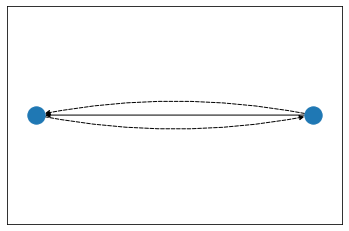

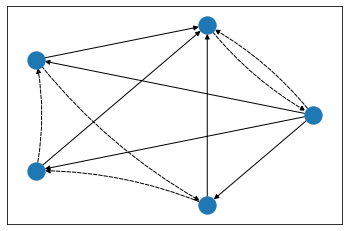

In [60]:
# Examples

l = lattice_with_neg(reflexive_closure([],[0]))

display_lattice_with_neg(l)

l = lattice_with_neg(reflexive_closure([(0,1),(1,2),(2,0)],range(3)))

display_lattice_with_neg(l)


In [61]:
def lattices_with_neg(rels):
    """given a collection rels of relations, returns all the fixpoint lattices with neg operation up to isomorphism"""

    lattices = []

    for rel in tqdm(rels):
        l = lattice_with_neg(rel)
        newlat = True
        for l2 in lattices:
            if nx.is_isomorphic(l,l2):
                newlat = False
                break
        if newlat:
            lattices.append(l)
       
    return lattices

In [62]:
def lattices_with_neg_keep_rels(rels):
    """given a collection rels of relations, returns all the fixpoint lattices with neg operation up to isomorphism,
    plus the relation from which each came"""

    rel_lat = []

    for rel in tqdm(rels):
        l = lattice_with_neg(rel)
        newlat = True
        for pair in rel_lat:
            l2 = pair[1]
            if nx.is_isomorphic(l,l2):
                newlat = False
                break
        if newlat:
            rel_lat.append((rel,l))
       
    return rel_lat

  0%|          | 0/218 [00:00<?, ?it/s]

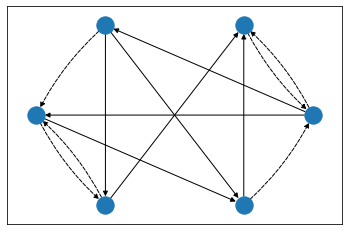

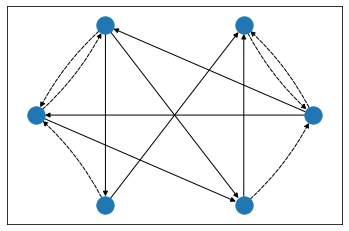

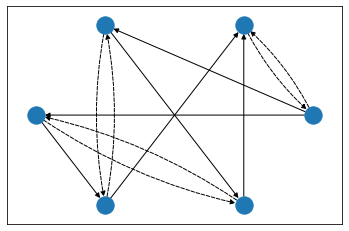

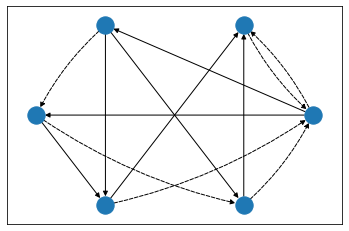

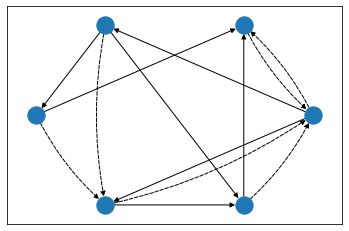

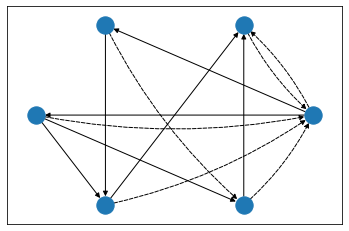

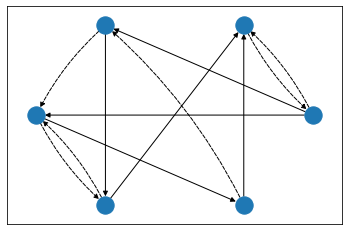

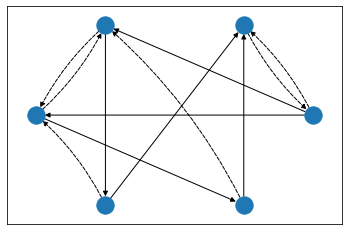

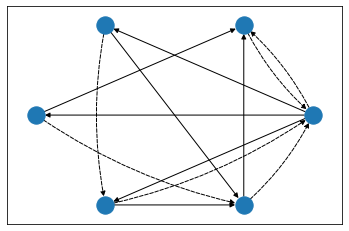

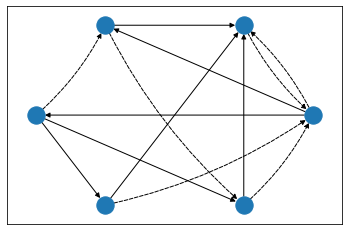

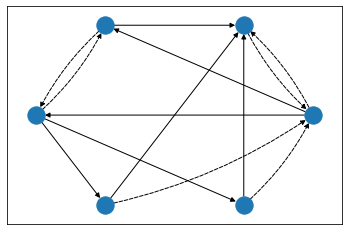

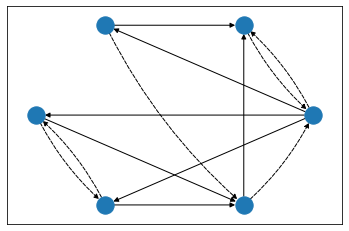

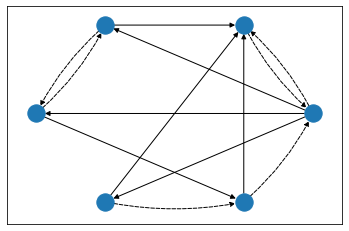

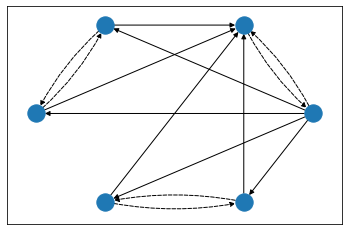

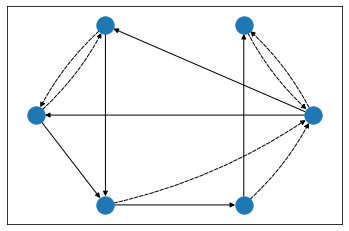

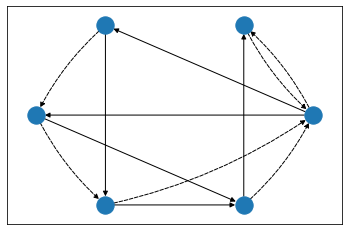

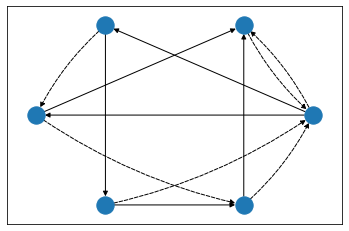

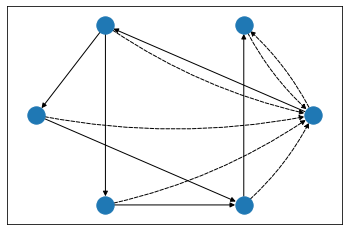

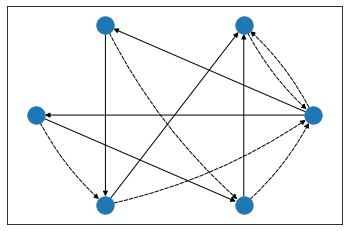

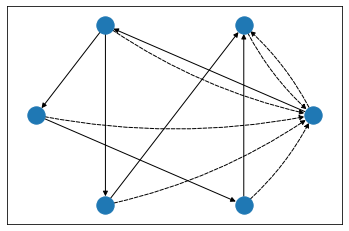

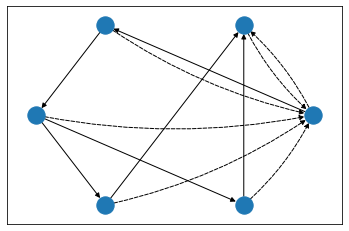

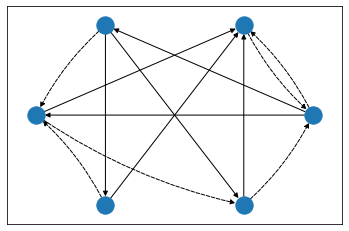

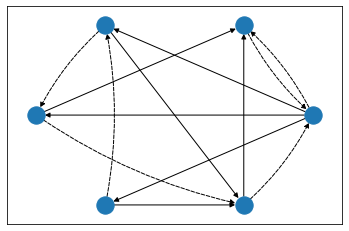

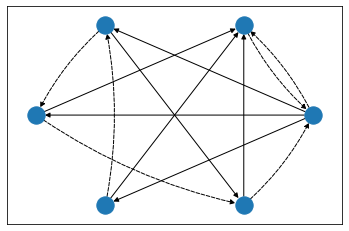

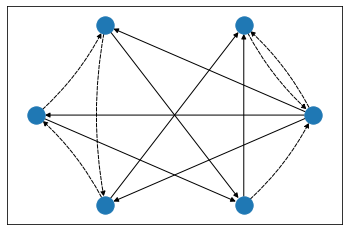

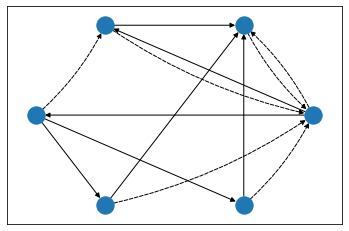

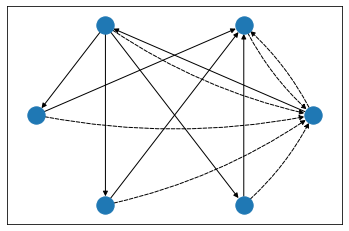

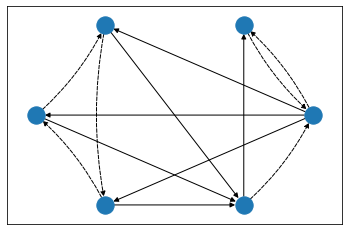

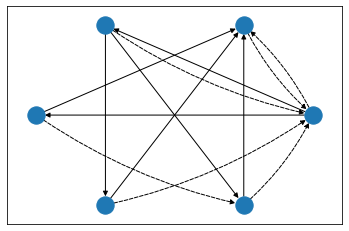

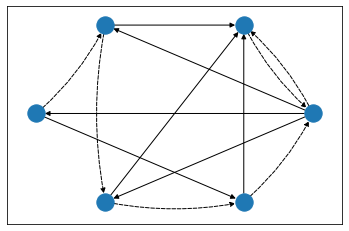

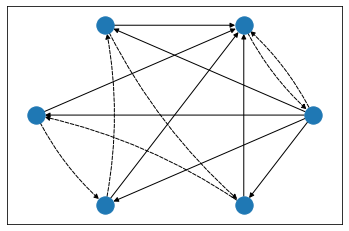

In [63]:
# Examples

for pair in lattices_with_neg_keep_rels(comp_frames_size(4)):
    if len(pair[1].nodes)==6:
        display_lattice_with_neg(pair[1])

### Lattices with $\neg$ from compatibility frames of size 1-4

In [64]:
lattices_with_neg_from_comp_frames_size = {n: lattices_with_neg(comp_frames_size(n)) for n in range(1,5)}

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

In [65]:
for n in range(1,5):
    print(f"Number of compatibility frames of size {n} up to iso: {len(comp_frames_size(n))}")
    print(f"Number of lattices up to iso from compatibility frames of size {n}: {len(lattices_from_comp_frames_size[n])}")
    print(f"Number of lattices with neg up to iso from compatibility frames of size {n}: {len(lattices_with_neg_from_comp_frames_size[n])}")
    print("\n")

Number of compatibility frames of size 1 up to iso: 1
Number of lattices up to iso from compatibility frames of size 1: 1
Number of lattices with neg up to iso from compatibility frames of size 1: 1


Number of compatibility frames of size 2 up to iso: 3
Number of lattices up to iso from compatibility frames of size 2: 3
Number of lattices with neg up to iso from compatibility frames of size 2: 3


Number of compatibility frames of size 3 up to iso: 16
Number of lattices up to iso from compatibility frames of size 3: 10
Number of lattices with neg up to iso from compatibility frames of size 3: 11


Number of compatibility frames of size 4 up to iso: 218
Number of lattices up to iso from compatibility frames of size 4: 59
Number of lattices with neg up to iso from compatibility frames of size 4: 103




In [66]:
for n in range(3,5):
    d_n = num_each_size(lattices_from_comp_frames_size[n])
    d_neg_n = num_each_size(lattices_with_neg_from_comp_frames_size[n])
    print(f"Number of lattices of each size arising from digraphs of size {n}:")
    pprint(d_n)
    print(f"Number of lattices with neg of each size arising from digraphs of size {n}:")
    pprint(d_neg_n)
    print("\n")

Number of lattices of each size arising from digraphs of size 3:
{2: 1, 3: 1, 4: 2, 5: 4, 6: 1, 8: 1}
Number of lattices with neg of each size arising from digraphs of size 3:
{2: 1, 3: 1, 4: 3, 5: 4, 6: 1, 8: 1}


Number of lattices of each size arising from digraphs of size 4:
{2: 1, 3: 1, 4: 2, 5: 5, 6: 14, 7: 14, 8: 6, 9: 9, 10: 5, 12: 1, 16: 1}
Number of lattices with neg of each size arising from digraphs of size 4:
{2: 1, 3: 1, 4: 4, 5: 17, 6: 31, 7: 23, 8: 10, 9: 9, 10: 5, 12: 1, 16: 1}




### Lattices with $\neg$ from compatibility frames of size 5

We separate the generation of lattices with $\neg$ from compatibility frames of size 5, since this takes a bit longer.

In [67]:
lattices_with_neg_from_comp_frames_size[5] = lattices_with_neg(comp_frames_size(5))

  0%|          | 0/9608 [00:00<?, ?it/s]

In [68]:
n=5

print(f"Number of compatibility frames of size {n} up to iso: {len(comp_frames_size(n))}")
print(f"Number of lattices up to iso from compatibility frames of size {n}: {len(lattices_from_comp_frames_size[n])}")
print(f"Number of lattices with neg up to iso from compatibility frames of size {n}: {len(lattices_with_neg_from_comp_frames_size[n])}")

Number of compatibility frames of size 5 up to iso: 9608
Number of lattices up to iso from compatibility frames of size 5: 876
Number of lattices with neg up to iso from compatibility frames of size 5: 3788


In [69]:
n=5

d_n = num_each_size(lattices_from_comp_frames_size[n])
d_neg_n = num_each_size(lattices_with_neg_from_comp_frames_size[n])
print(f"Number of lattices of each size arising from compatibility frames of size {n}:")
pprint(d_n)
print(f"Number of lattices with neg of each size arising from compatibility frames of size {n}:")
pprint(d_neg_n)

Number of lattices of each size arising from compatibility frames of size 5:
{2: 1,
 3: 1,
 4: 2,
 5: 5,
 6: 15,
 7: 52,
 8: 112,
 9: 130,
 10: 151,
 11: 159,
 12: 91,
 13: 60,
 14: 41,
 15: 15,
 16: 9,
 17: 16,
 18: 9,
 20: 5,
 24: 1,
 32: 1}
Number of lattices with neg of each size arising from compatibility frames of size 5:
{2: 1,
 3: 1,
 4: 4,
 5: 21,
 6: 131,
 7: 396,
 8: 657,
 9: 771,
 10: 743,
 11: 516,
 12: 264,
 13: 131,
 14: 79,
 15: 22,
 16: 19,
 17: 16,
 18: 9,
 20: 5,
 24: 1,
 32: 1}


# II Supplement to Section 3.1  <a id='II'></a>

In this section, we compute for a given lattice $L$, anti-inflationary operation $\neg$ on $L$, and set $\mathrm{V}$ of nonzero elements of $L$, the compatibility frame $(\mathrm{V},\vartriangleleft^\neg_\mathrm{V})$ from Def. 3.5(i) in the paper.

The lattice $L$ is always given as the lattice of fixpoints of some compatibility frame.

## II.I The compatibility relation of Def. 3.5(i)  <a id='II.I'></a>

In [70]:
def escapes(A,B,neg,V):
    """checks if A escapes B in V with neg, where neg is represented as a dictionary"""
    
    Aset = set(A)
    Bset = set(B)
    if not Aset == set() and not Bset == set():
        for C in V:
            negCset = set(neg[C])
            if not Aset.issubset(negCset) and Bset.issubset(negCset):
                return True
            
    return False

In [71]:
def compat(rel,neg,V,X=None):
    """where L is the fixpoint lattice of rel, returns the compatibility relation
    defined from L, neg, and V as in Def. 3.5(i)"""
    
    if X is None:
        X = domain(rel)
    
    fixpts = fixpoints(rel,X)
    
    comp = []
    for A in V:
        Aset = set(A)
        negAset = set(neg[A])
        for B in V:
            Bset = set(B)
            if not Bset.issubset(negAset):
                passes = True
                for C in fixpts:
                    Cset = set(C)
                    if Bset.issubset(Cset) and not Aset.issubset(Cset):
                          if not escapes(A,C,neg,V):
                                passes = False
                                break
                if passes:
                    comp.append((A,B))
    return comp

## II.II Finding join-irreducibles in the fixpoint lattice  <a id='II.II'></a>

In [72]:
def is_join_irr(A,rel,X = None):
    """checks if A is join-irreducible in the fixpoint lattice of rel"""
    
    if X is None:
        X = domain(rel)
        
    fixpts = fixpoints(rel,X)
    Aset = set(A)
    
    if Aset == set():
        return False
    
    for B in fixpts:
        Bset = set(B)
        for C in fixpts:
            Cset = set(C)
            if not Bset == Aset and not Cset == Aset:
                union = Bset.union(Cset)
                closure_union = set(closure(union,rel,X))
                if Aset == closure_union:
                    return False
        
    return True

In [73]:
def join_irrs(rel,X = None):
    """Returns the list of all join-irreducibles in the fixpoint lattice of rel"""
    
    if X is None:
        X = domain(rel)
    
    ji = []
    fixpts = fixpoints(rel,X)
    
    for A in fixpts:
        if is_join_irr(A,rel,X):
            ji.append(A)
            
    return ji

In [74]:
rel = reflexive_closure([(1,0),(2,1)],range(3))

print(fixpoints(rel))

print(join_irrs(rel))

[(), (0, 1, 2), (0,), (2,), (1, 2)]
[(0,), (2,), (1, 2)]


### Example

In [75]:
rel = reflexive_closure([(0,1),(1,2),(2,0)],range(3))
print(f"Original compatibility frame: {rel}")

fixpts = fixpoints(rel)
print(f"Original fixpoints: {fixpts}")

print("\n")

l1 = lattice(rel) # This is the lattice we will try to obtain via the representation of Section 3.1

# To represent l1 as in Section 3.1, we need to pick neg and V

neg = neg_dict(rel) # neg is the protocomplementation defined from rel on the fixpoints lattice of rel
V = join_irrs(rel) # V is the set of join-irreducible elements of the fixpoints lattice of rel

compat_rel = compat(rel, neg, V) # This is the relation on V defined from l1 and neg as in Definition 3.5(i)
print(f"New compatibility frame: {compat_rel}")
compat_fixpts = fixpoints(compat_rel)
print(f"New fixpoints: {compat_fixpts}")

l2 = lattice(compat_rel)
               
nx.is_isomorphic(l1,l2)

Original compatibility frame: [(0, 1), (1, 2), (2, 0), (0, 0), (1, 1), (2, 2)]
Original fixpoints: [(), (0, 1, 2), (0,), (1,), (2,)]


New compatibility frame: [((0,), (0,)), ((0,), (1,)), ((1,), (1,)), ((1,), (2,)), ((2,), (0,)), ((2,), (2,))]
New fixpoints: [(), ((0,), (1,), (2,)), ((0,),), ((1,),), ((2,),)]


True

## II.III Generating anti-inflationary functions <a id='II.III'></a>

In [76]:
def anti_inflationary(f,dom):
    """checks whether funtion f with domain dom is anti-inflationary with respect to set inclusion"""
    
    for A in dom:
        Aset = set(A)
        fAset = set(f(A))
        if not Aset == set() and Aset.issubset(fAset):
            return False
        
    return True

In [77]:
def anti_inflationary_negs(lt,X):
    """generates all the anti-inflationary functions on the fixpoint lattice lt
    up to isomorphism of the resulting lattice expansion"""
    
    ltset = set(lt)
    
    cover = covering(propsubrel(lt))
    
    lat_exps_of_lt = []
    fs = []
    Xtuple = tuple(X)
    
    for f in f_generator(ltset,ltset):
        if anti_inflationary(f,ltset):
            newlat = True
            
            l = nx.MultiDiGraph()
            l.add_nodes_from(lt)
            l.add_edges_from(cover, weight=0)
            
            for A in ltset:
                l.add_edge(A,f(A), weight=1)
            
            for l2 in lat_exps_of_lt:
                if nx.is_isomorphic(l,l2):
                    newlat = False

            if newlat:
                lat_exps_of_lt.append(l)
                f_dict = {A: f(A) for A in ltset}
                fs.append(f_dict)
                    
    return fs

In [78]:
def anti_inflationary_negs_V(lt,V,X):
    """like the previous function be we only look at anti-inflationary functions from V to lt"""
    
    Vset = set(V)
    ltset = set(lt)
    
    cover = covering(propsubrel(lt))
    
    lat_exps_of_lt = []
    fs = []
    Xtuple = tuple(X)
    
    for f in f_generator(Vset,ltset):
        if anti_inflationary(f,Vset):
            newlat = True
            
            l = nx.MultiDiGraph()
            l.add_nodes_from(lt)
            l.add_edges_from(cover, weight=0)
            
            for A in Vset:
                l.add_edge(A,f(A), weight=1)
            
            for l2 in lat_exps_of_lt:
                if nx.is_isomorphic(l,l2):
                    newlat = False

            if newlat:
                lat_exps_of_lt.append(l)
                f_dict = {A: f(A) for A in Vset}
                fs.append(f_dict)
                    
    return fs

## II.IV Checking whether lattice(s) can be represented as in Def. 3.5(i) <a id='II.IV'></a>

In [79]:
def represent_lat(rel):
    """checks whether the fixpoint lattice of rel is representable as in Section 3.1"""

    fixpts = fixpoints(rel)
    print(f"Original compatibility relation: {rel}")
    print(f"Lattice of fixpoints: {fixpts}")
    l1 = lattice(rel)
    nx.draw(l1)
    plt.show()
    
    k = len(domain(rel))
    can_rep = False
    ji = join_irrs(rel)
    
    for f in anti_inflationary_negs_V(fixpts,ji,range(k)):
        comp = compat(rel,f,ji,domain(rel))
        l2 = lattice(comp)
        if nx.is_isomorphic(l1,l2):
            can_rep = True
            print("Can find a neg and V to represent lattice via Def. 3.5(i).")
            print(f"V is the set of join-irreducibles: {ji}")
            print(f"The neg operation is: {f}")
            print(f"The compatibility relation from Def. 3.5(i) is: {comp}")
            print("\n")
            break
            
    if can_rep == False:
        for V in powerset(fixpts):
            if () not in V:
                for f in anti_inflationary_negs_V(fixpts,V,range(k)):
                    comp = compat(rel,f,V,domain(rel))
                    l2 = lattice(comp)
                    if nx.is_isomorphic(l1,l2):
                        can_rep = True
                        print("Can find a neg and V to represent lattice via Def. 3.5(i).")
                        print(f"The subset V is: {V}")
                        print(f"The neg operation is: {f}")
                        print(f"The compatibility relation from Def. 3.5(i) is: {comp}")
                        print("\n")
                        break
            if can_rep == True:
                break
        
    if can_rep == False:
        print("Can't find a neg and V to represent lattice via Def. 3.5(i).")
        print("\n")

Next we verify that for every lattice $L$ of size $\leq 6$, there is a $\neg$ and $\mathrm{V}$ such that $L$ is isomorphic to $\mathfrak{L}(\mathrm{V},\vartriangleleft^\neg_\mathrm{V})$. We will verify this for every lattices of size $\leq 7$ in Section II.V below.

Original compatibility relation: [(0, 0)]
Lattice of fixpoints: [(), (0,)]


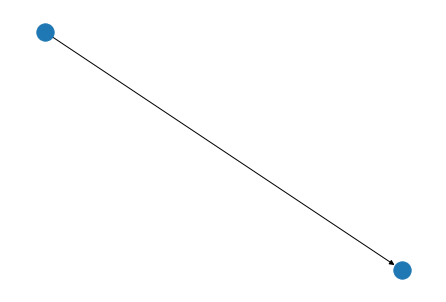

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0,)]
The neg operation is: {(0,): ()}
The compatibility relation from Def. 3.5(i) is: [((0,), (0,))]


Original compatibility relation: [(0, 0), (0, 1), (1, 1)]
Lattice of fixpoints: [(), (0, 1), (0,)]


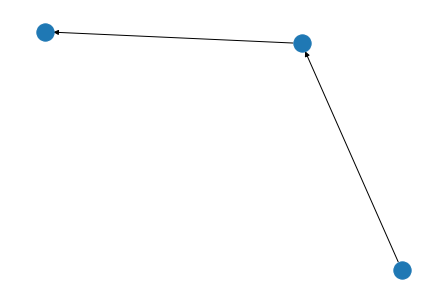

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1), (0,)]
The neg operation is: {(0, 1): (), (0,): ()}
The compatibility relation from Def. 3.5(i) is: [((0, 1), (0, 1)), ((0,), (0, 1)), ((0,), (0,))]


Original compatibility relation: [(0, 0), (1, 1)]
Lattice of fixpoints: [(), (0, 1), (0,), (1,)]


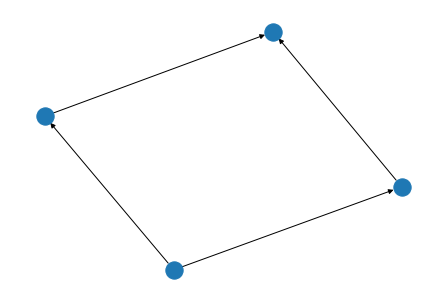

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0,), (1,)]
The neg operation is: {(0,): (1,), (1,): ()}
The compatibility relation from Def. 3.5(i) is: [((0,), (0,)), ((1,), (1,))]


Original compatibility relation: [(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)]
Lattice of fixpoints: [(), (0, 1, 2), (0,), (0, 1)]


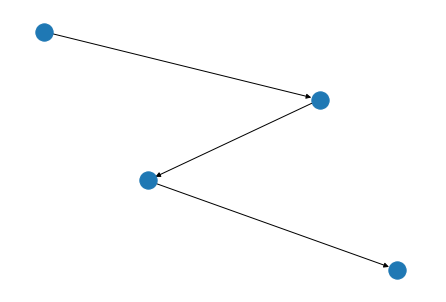

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1, 2), (0,), (0, 1)]
The neg operation is: {(0, 1, 2): (0, 1), (0,): (), (0, 1): ()}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2), (0, 1, 2)), ((0,), (0, 1, 2)), ((0,), (0,)), ((0,), (0, 1)), ((0, 1), (0, 1, 2)), ((0, 1), (0, 1))]


Original compatibility relation: [(0, 2), (1, 2), (0, 0), (1, 1), (2, 2)]
Lattice of fixpoints: [(), (0, 1, 2), (0,), (1,), (0, 1)]


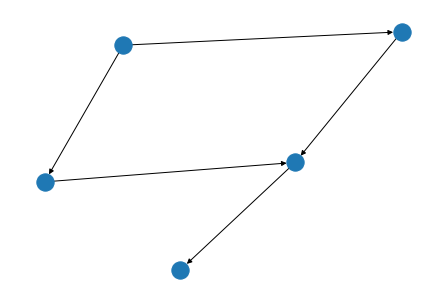

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1, 2), (0,), (1,)]
The neg operation is: {(0, 1, 2): (0, 1), (1,): (0,), (0,): (1,)}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2), (0, 1, 2)), ((0,), (0, 1, 2)), ((0,), (0,)), ((1,), (0, 1, 2)), ((1,), (1,))]


Original compatibility relation: [(0, 2), (2, 1), (0, 0), (1, 1), (2, 2)]
Lattice of fixpoints: [(), (0, 1, 2), (0,), (1,), (0, 2)]


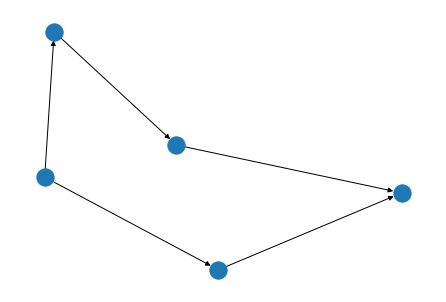

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0,), (1,), (0, 2)]
The neg operation is: {(0,): (1,), (1,): (0,), (0, 2): (0,)}
The compatibility relation from Def. 3.5(i) is: [((0,), (0,)), ((0,), (0, 2)), ((1,), (1,)), ((0, 2), (1,)), ((0, 2), (0, 2))]


Original compatibility relation: [(2, 0), (2, 1), (0, 0), (1, 1), (2, 2)]
Lattice of fixpoints: [(), (0, 1, 2), (2,), (0, 2), (1, 2)]


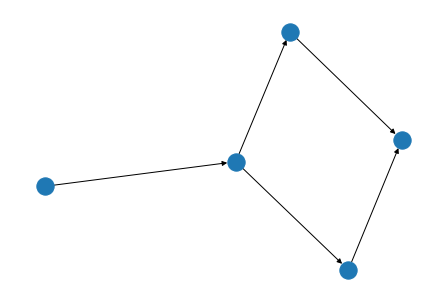

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(2,), (0, 2), (1, 2)]
The neg operation is: {(1, 2): (2,), (0, 2): (1, 2), (2,): ()}
The compatibility relation from Def. 3.5(i) is: [((2,), (2,)), ((2,), (0, 2)), ((2,), (1, 2)), ((0, 2), (0, 2)), ((1, 2), (1, 2))]


Original compatibility relation: [(0, 1), (2, 0), (1, 2), (0, 0), (1, 1), (2, 2)]
Lattice of fixpoints: [(), (0, 1, 2), (0,), (1,), (2,)]


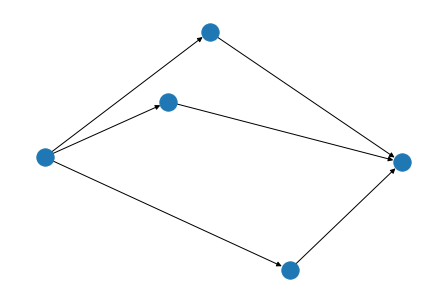

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0,), (1,), (2,)]
The neg operation is: {(0,): (2,), (1,): (0,), (2,): (1,)}
The compatibility relation from Def. 3.5(i) is: [((0,), (0,)), ((0,), (1,)), ((1,), (1,)), ((1,), (2,)), ((2,), (0,)), ((2,), (2,))]


Original compatibility relation: [(0, 0), (0, 1), (0, 2), (0, 3), (1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (0, 1), (0, 1, 2)]


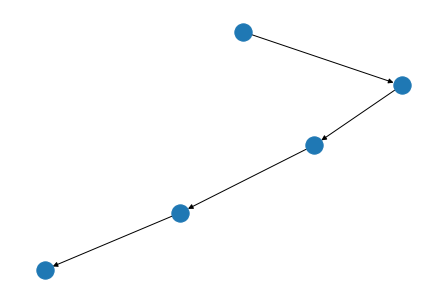

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1, 2, 3), (0,), (0, 1), (0, 1, 2)]
The neg operation is: {(0,): (), (0, 1, 2, 3): (0, 1), (0, 1, 2): (0, 1), (0, 1): (0,)}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2, 3), (0, 1, 2, 3)), ((0,), (0, 1, 2, 3)), ((0,), (0,)), ((0,), (0, 1)), ((0,), (0, 1, 2)), ((0, 1), (0, 1, 2, 3)), ((0, 1), (0, 1)), ((0, 1), (0, 1, 2)), ((0, 1, 2), (0, 1, 2, 3)), ((0, 1, 2), (0, 1, 2))]


Original compatibility relation: [(0, 2), (2, 0), (1, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (1,), (0, 2), (1, 3), (0, 1, 2)]


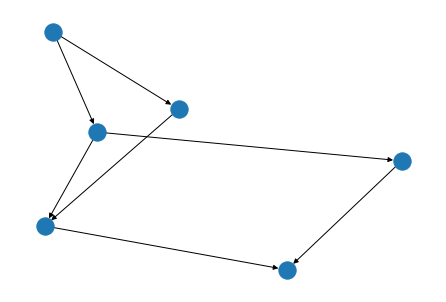

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(1,), (0, 2), (1, 3)]
The neg operation is: {(1,): (0, 2), (0, 2): (1,), (1, 3): (1,)}
The compatibility relation from Def. 3.5(i) is: [((1,), (1,)), ((1,), (1, 3)), ((0, 2), (0, 2)), ((1, 3), (1, 3))]


Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (1, 3), (3, 1), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (1,), (2,), (0, 2), (1, 3)]


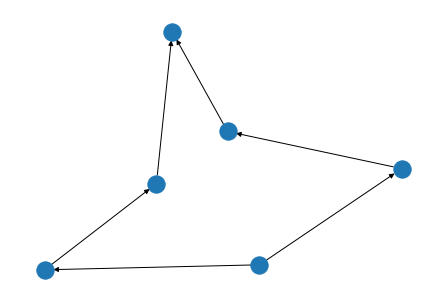

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(1,), (2,), (0, 2), (1, 3)]
The neg operation is: {(1,): (2,), (0, 2): (1,), (2,): (1, 3), (1, 3): (0, 2)}
The compatibility relation from Def. 3.5(i) is: [((1,), (1,)), ((1,), (0, 2)), ((1,), (1, 3)), ((2,), (2,)), ((2,), (0, 2)), ((0, 2), (2,)), ((0, 2), (0, 2)), ((0, 2), (1, 3)), ((1, 3), (1,)), ((1, 3), (1, 3))]


Original compatibility relation: [(0, 2), (2, 0), (0, 3), (2, 1), (1, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (1,), (3,), (0, 2), (0, 1, 2)]


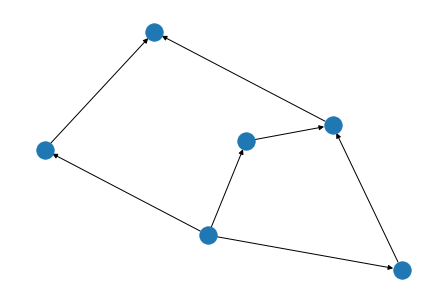

Can find a neg and V to represent lattice via Def. 3.5(i).
The subset V is: ((0, 1, 2, 3), (1,), (3,), (0, 2))
The neg operation is: {(1,): (0, 2), (0, 2): (1,), (0, 1, 2, 3): (3,), (3,): (0, 1, 2)}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2, 3), (0, 1, 2, 3)), ((0, 1, 2, 3), (1,)), ((0, 1, 2, 3), (0, 2)), ((1,), (0, 1, 2, 3)), ((1,), (1,)), ((1,), (3,)), ((3,), (0, 1, 2, 3)), ((3,), (3,)), ((0, 2), (0, 1, 2, 3)), ((0, 2), (3,)), ((0, 2), (0, 2))]


Original compatibility relation: [(0, 2), (2, 0), (3, 0), (1, 2), (1, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (1, 2), (1, 3)]


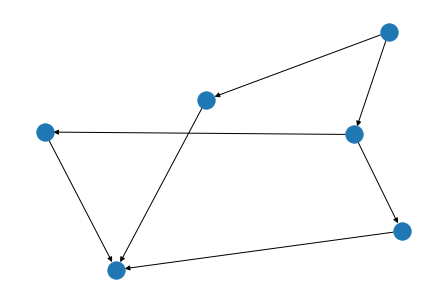

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0,), (1,), (1, 2), (1, 3)]
The neg operation is: {(0,): (1, 2), (1,): (0,), (1, 2): (1, 3), (1, 3): (1, 2)}
The compatibility relation from Def. 3.5(i) is: [((0,), (0,)), ((0,), (1, 3)), ((1,), (1,)), ((1,), (1, 2)), ((1,), (1, 3)), ((1, 2), (0,)), ((1, 2), (1, 2)), ((1, 3), (0,)), ((1, 3), (1, 3))]


Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (1, 2), (2, 1), (1, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (3,), (1, 2)]


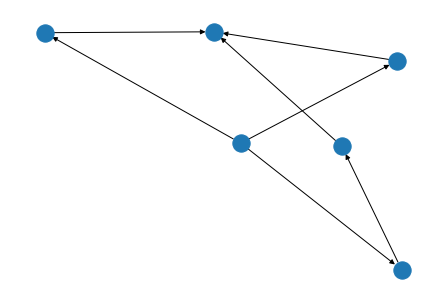

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0,), (1,), (3,), (1, 2)]
The neg operation is: {(0,): (1, 2), (1,): (0,), (1, 2): (3,), (3,): (1,)}
The compatibility relation from Def. 3.5(i) is: [((0,), (0,)), ((0,), (3,)), ((1,), (1,)), ((1,), (3,)), ((1,), (1, 2)), ((3,), (0,)), ((3,), (3,)), ((3,), (1, 2)), ((1, 2), (0,)), ((1, 2), (1,)), ((1, 2), (1, 2))]


Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (1, 2), (2, 1), (1, 3), (3, 1), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (2,), (3,)]


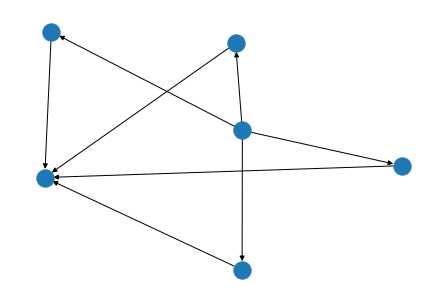

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0,), (1,), (2,), (3,)]
The neg operation is: {(0,): (2,), (1,): (0,), (2,): (3,), (3,): (1,)}
The compatibility relation from Def. 3.5(i) is: [((0,), (0,)), ((0,), (1,)), ((0,), (3,)), ((1,), (1,)), ((1,), (2,)), ((1,), (3,)), ((2,), (0,)), ((2,), (1,)), ((2,), (2,)), ((3,), (0,)), ((3,), (2,)), ((3,), (3,))]


Original compatibility relation: [(0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (0, 1), (0, 1, 2)]


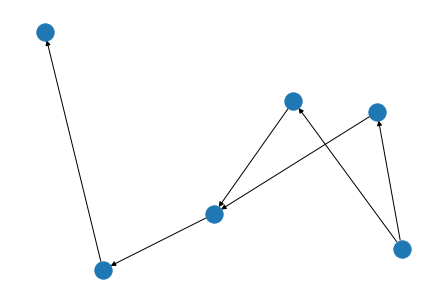

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1, 2, 3), (0,), (1,), (0, 1, 2)]
The neg operation is: {(0,): (1,), (1,): (0,), (0, 1, 2, 3): (0, 1), (0, 1, 2): (0, 1)}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2, 3), (0, 1, 2, 3)), ((0,), (0, 1, 2, 3)), ((0,), (0,)), ((0,), (0, 1, 2)), ((1,), (0, 1, 2, 3)), ((1,), (1,)), ((1,), (0, 1, 2)), ((0, 1, 2), (0, 1, 2, 3)), ((0, 1, 2), (0, 1, 2))]


Original compatibility relation: [(0, 2), (0, 3), (1, 2), (3, 1), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (0, 3), (0, 1, 3)]


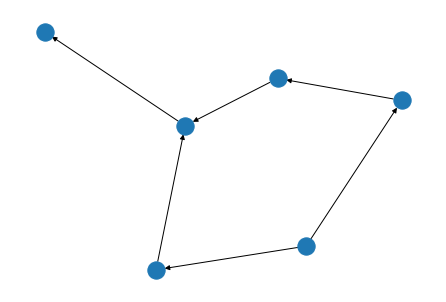

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1, 2, 3), (0,), (1,), (0, 3)]
The neg operation is: {(0,): (1,), (1,): (0, 3), (0, 1, 2, 3): (0, 1, 3), (0, 3): (0,)}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2, 3), (0, 1, 2, 3)), ((0,), (0, 1, 2, 3)), ((0,), (0,)), ((0,), (0, 3)), ((1,), (0, 1, 2, 3)), ((1,), (1,)), ((0, 3), (0, 1, 2, 3)), ((0, 3), (1,)), ((0, 3), (0, 3))]


Original compatibility relation: [(0, 2), (0, 3), (2, 1), (3, 1), (2, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (0, 2), (0, 2, 3)]


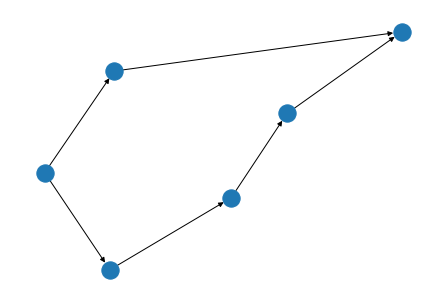

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0,), (1,), (0, 2), (0, 2, 3)]
The neg operation is: {(0,): (1,), (1,): (0, 2, 3), (0, 2): (0,), (0, 2, 3): (0, 2)}
The compatibility relation from Def. 3.5(i) is: [((0,), (0,)), ((0,), (0, 2)), ((0,), (0, 2, 3)), ((1,), (1,)), ((0, 2), (1,)), ((0, 2), (0, 2)), ((0, 2), (0, 2, 3)), ((0, 2, 3), (1,)), ((0, 2, 3), (0, 2, 3))]


Original compatibility relation: [(0, 2), (3, 0), (1, 2), (3, 1), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (3,), (0, 3), (1, 3), (0, 1, 3)]


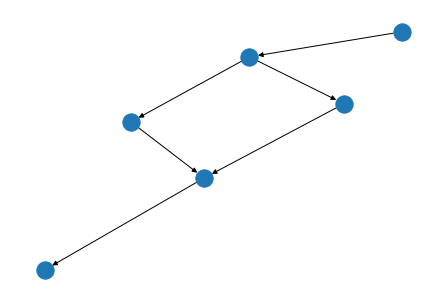

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1, 2, 3), (3,), (0, 3), (1, 3)]
The neg operation is: {(1, 3): (0, 3), (0, 1, 2, 3): (0, 1, 3), (3,): (), (0, 3): (3,)}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2, 3), (0, 1, 2, 3)), ((3,), (0, 1, 2, 3)), ((3,), (3,)), ((3,), (0, 3)), ((3,), (1, 3)), ((0, 3), (0, 1, 2, 3)), ((0, 3), (0, 3)), ((1, 3), (0, 1, 2, 3)), ((1, 3), (1, 3))]


Original compatibility relation: [(0, 2), (3, 0), (2, 1), (3, 1), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (3,), (0, 3), (1, 3), (0, 2, 3)]


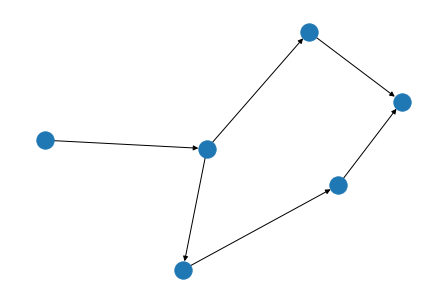

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(3,), (0, 3), (1, 3), (0, 2, 3)]
The neg operation is: {(0, 2, 3): (0, 3), (1, 3): (0, 3), (0, 3): (1, 3), (3,): ()}
The compatibility relation from Def. 3.5(i) is: [((3,), (3,)), ((3,), (0, 3)), ((3,), (1, 3)), ((3,), (0, 2, 3)), ((0, 3), (0, 3)), ((0, 3), (0, 2, 3)), ((1, 3), (1, 3)), ((0, 2, 3), (1, 3)), ((0, 2, 3), (0, 2, 3))]


Original compatibility relation: [(2, 0), (3, 0), (2, 1), (3, 1), (2, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (2,), (2, 3), (0, 2, 3), (1, 2, 3)]


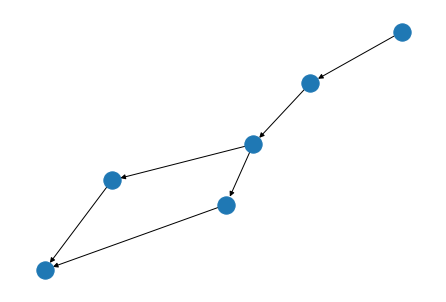

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(2,), (2, 3), (0, 2, 3), (1, 2, 3)]
The neg operation is: {(2, 3): (2,), (2,): (), (0, 2, 3): (2,), (1, 2, 3): (2,)}
The compatibility relation from Def. 3.5(i) is: [((2,), (2,)), ((2,), (2, 3)), ((2,), (0, 2, 3)), ((2,), (1, 2, 3)), ((2, 3), (2, 3)), ((2, 3), (0, 2, 3)), ((2, 3), (1, 2, 3)), ((0, 2, 3), (0, 2, 3)), ((1, 2, 3), (1, 2, 3))]


Original compatibility relation: [(0, 1), (0, 2), (0, 3), (1, 2), (3, 1), (2, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (0, 1), (0, 2), (0, 3)]


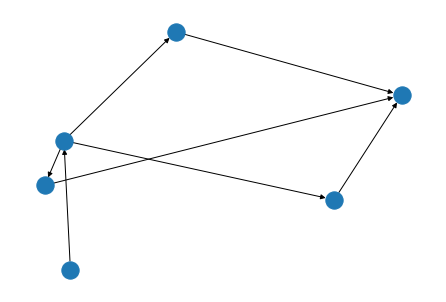

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0,), (0, 1), (0, 2), (0, 3)]
The neg operation is: {(0,): (), (0, 2): (0, 1), (0, 3): (0, 2), (0, 1): (0, 3)}
The compatibility relation from Def. 3.5(i) is: [((0,), (0,)), ((0,), (0, 1)), ((0,), (0, 2)), ((0,), (0, 3)), ((0, 1), (0, 1)), ((0, 1), (0, 2)), ((0, 2), (0, 2)), ((0, 2), (0, 3)), ((0, 3), (0, 1)), ((0, 3), (0, 3))]


Original compatibility relation: [(0, 1), (0, 2), (3, 0), (1, 2), (1, 3), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (3,), (0, 1, 3)]


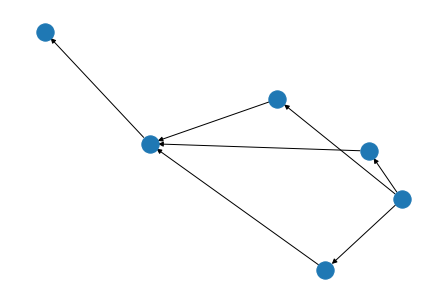

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1, 2, 3), (0,), (1,), (3,)]
The neg operation is: {(0,): (1,), (1,): (3,), (0, 1, 2, 3): (0, 1, 3), (3,): (0,)}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2, 3), (0, 1, 2, 3)), ((0,), (0, 1, 2, 3)), ((0,), (0,)), ((0,), (3,)), ((1,), (0, 1, 2, 3)), ((1,), (0,)), ((1,), (1,)), ((3,), (0, 1, 2, 3)), ((3,), (1,)), ((3,), (3,))]


Original compatibility relation: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 1), (1, 2), (1, 3), (1, 4), (2, 2), (2, 3), (2, 4), (3, 3), (3, 4), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (0, 1), (0, 1, 2), (0, 1, 2, 3)]


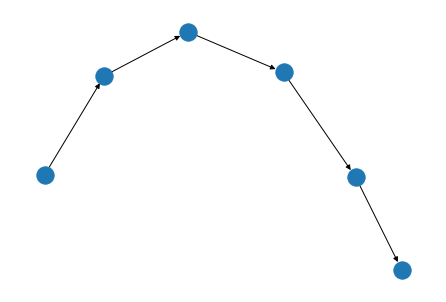

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1, 2, 3, 4), (0,), (0, 1), (0, 1, 2), (0, 1, 2, 3)]
The neg operation is: {(0, 1): (), (0, 1, 2): (0, 1), (0, 1, 2, 3): (0, 1), (0,): (), (0, 1, 2, 3, 4): (0, 1)}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((0,), (0, 1, 2, 3, 4)), ((0,), (0,)), ((0,), (0, 1)), ((0,), (0, 1, 2)), ((0,), (0, 1, 2, 3)), ((0, 1), (0, 1, 2, 3, 4)), ((0, 1), (0, 1)), ((0, 1), (0, 1, 2)), ((0, 1), (0, 1, 2, 3)), ((0, 1, 2), (0, 1, 2, 3, 4)), ((0, 1, 2), (0, 1, 2)), ((0, 1, 2), (0, 1, 2, 3)), ((0, 1, 2, 3), (0, 1, 2, 3, 4)), ((0, 1, 2, 3), (0, 1, 2, 3))]




In [80]:
for n in range(2,7):
    for rel in comp_frames_for_lats_size[n]:
        represent_lat(rel)

Among lattice up to size 6, for all but one, we can take $\mathrm{V}$ in the representation to be the set of join-irreducible elements. The one exception is the following.

Original compatibility relation: [(0, 2), (2, 0), (0, 3), (0, 4), (4, 0), (1, 3), (3, 1), (4, 1), (2, 4), (4, 2), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (3,), (1, 3), (0, 2, 4)]


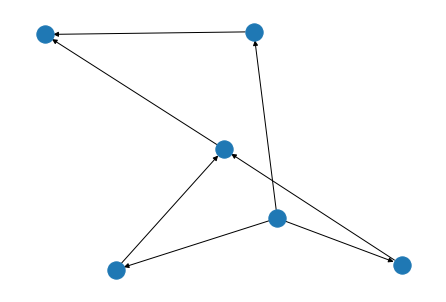

Can find a neg and V to represent lattice via Def. 3.5(i).
The subset V is: ((0, 1, 2, 3, 4), (1,), (3,), (0, 2, 4))
The neg operation is: {(1,): (0, 2, 4), (0, 1, 2, 3, 4): (1, 3), (3,): (), (0, 2, 4): (3,)}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((0, 1, 2, 3, 4), (0, 2, 4)), ((1,), (0, 1, 2, 3, 4)), ((1,), (1,)), ((1,), (3,)), ((3,), (0, 1, 2, 3, 4)), ((3,), (3,)), ((3,), (0, 2, 4)), ((0, 2, 4), (0, 1, 2, 3, 4)), ((0, 2, 4), (1,)), ((0, 2, 4), (0, 2, 4))]




In [81]:
rel = [(0, 2), (2, 0), (0, 3), (0, 4), (4, 0), (1, 3), (3, 1), (4, 1), (2, 4), (4, 2), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]

represent_lat(rel)

## II.V Checking whether a lattice can be represented as in Def. 3.5(i) for a given $\neg$ and/or $\mathrm{V}$ <a id='II.V'></a>

In [82]:
def represent_lat_with_neg_V(rel, neg, V):
    """checks whether the fixpoint lattice of rel is successfully represented
    by the compatibility relation defined from f and V as in Definition 3.5(i)"""
    
    fixpts = fixpoints(rel)
    print(f"Original compatibility relation: {rel}")
    print(f"Lattice of fixpoints: {fixpts}")
    l1 = lattice(rel)
    nx.draw(l1)
    plt.show()
    
    can_rep = False
    
    comp = compat(rel,neg,V,domain(rel))
    l2 = lattice(comp)
    if nx.is_isomorphic(l1,l2):
        print("Can represent lattice via Def. 3.5(i) with the given neg and V.")
        print(f"The subset V is: {V}")
        print(f"The neg operation is: {neg}")
        print(f"The compatibility relation from Definition 3.5(i) is: {comp}") 
        can_rep = True
    
    if can_rep == False:
        print("Can't represent lattice via Def. 3.5(i) with the given neg and V.")
        print("\n")

Original compatibility relation: [(0, 2), (2, 0), (0, 3), (1, 3), (3, 1), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (1,), (0, 2), (1, 3)]


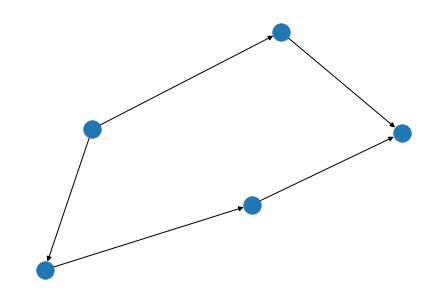

Can't represent lattice via Def. 3.5(i) with the given neg and V.




In [83]:
# An example

rel = [(0, 2), (2, 0), (0, 3), (1, 3), (3, 1), (0, 0), (1, 1), (2, 2), (3, 3)]

neg = neg_dict(rel)

V = join_irrs(rel)

represent_lat_with_neg_V(rel,neg,V)

In [84]:
def represent_lat_with_neg(rel,neg):
    """checks whether there is a V such that fixpoint lattice of rel is successfully represented
    by the compatibility relation defined from neg and V as in Definition 3.5(i)"""
    
    fixpts = fixpoints(rel)
    print(f"Original compatibility relation: {rel}")
    print(f"Lattice of fixpoints: {fixpts}")
    l1 = lattice(rel)
    nx.draw(l1)
    plt.show()
    
    k = len(domain(rel))
    can_rep = False
    ji = join_irrs(rel)
    
    comp = compat(rel,neg,ji,domain(rel))
    l2 = lattice(comp)
    if nx.is_isomorphic(l1,l2):
        can_rep = True
        print("Can find a V to represent lattice via Def. 3.5(i) with the given neg.")
        print(f"V is the set of join-irreducibles: {ji}")
        print(f"The anti-inflationary operation is: {neg}")
        print(f"The compatibility relation from Def. 3.5(i) is: {comp}")
        print("\n")

    if can_rep == False:
        for V in powerset(fixpts):
            if () not in V:
                comp = compat(rel,neg,V,domain(rel))
                l2 = lattice(comp)
                if nx.is_isomorphic(l1,l2):
                    can_rep = True
                    print("Can find a V to represent lattice via Def. 3.5(i) with the given neg.")
                    print(f"The subset V is: {V}")
                    print(f"The neg operation is: {neg}")
                    print(f"The compatibility relation from Def. 3.5(i) is: {comp}")
                    print("\n")
                    break
        
    if can_rep == False:
        print("Can't find a V to represent lattice via Def. 3.5(i) with the given neg.")
        print("\n")

Original compatibility relation: [(0, 2), (2, 0), (0, 3), (1, 3), (3, 1), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (1,), (0, 2), (1, 3)]


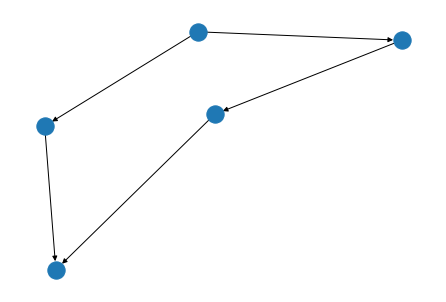

Can't find a V to represent lattice via Def. 3.5(i) with the given neg.




In [85]:
# Continuing the previous example

rel = [(0, 2), (2, 0), (0, 3), (1, 3), (3, 1), (0, 0), (1, 1), (2, 2), (3, 3)]

neg = neg_dict(rel)

represent_lat_with_neg(rel,neg)

In [86]:
def represent_lat_with_V(rel, V):
    """checks whether there is a neg such that fixpoint lattice of rel is successfully represented
    by the compatibility relation defined from neg and V as in Definition 3.5(i)"""

    fixpts = fixpoints(rel)
    print(f"Original compatibility relation: {rel}")
    print(f"Lattice of fixpoints: {fixpts}")
    l1 = lattice(rel)
    nx.draw(l1)
    plt.show()
    
    k = len(domain(rel))
    can_rep = False

    for neg in anti_inflationary_negs_V(fixpts,V,range(k)):
        comp = compat(rel,neg,V,domain(rel))
        l2 = lattice(comp)
        if nx.is_isomorphic(l1,l2):
            can_rep = True
            print("Can find a neg to represent lattice via Def. 3.5(i) with the given V.")
            print(f"The subset V is: {V}")
            print(f"The neg operation is: {neg}")
            print(f"The compatibility relation from Def. 3.5(i) is: {comp}")
            print("\n")
            break
        
    if can_rep == False:
        print("Can't find a neg to represent lattice via Def. 3.5(i) with the given V.")
        print("\n")

Original compatibility relation: [(0, 2), (2, 0), (0, 3), (1, 3), (3, 1), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (1,), (0, 2), (1, 3)]


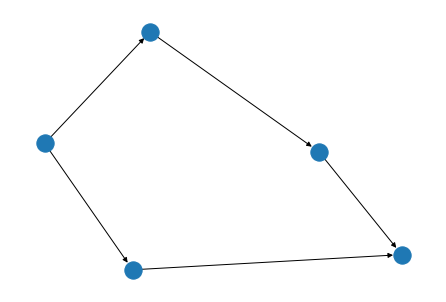

Can find a neg to represent lattice via Def. 3.5(i) with the given V.
The subset V is: [(1,), (0, 2), (1, 3)]
The neg operation is: {(1,): (0, 2), (0, 2): (1,), (1, 3): (1,)}
The compatibility relation from Def. 3.5(i) is: [((1,), (1,)), ((1,), (1, 3)), ((0, 2), (0, 2)), ((1, 3), (0, 2)), ((1, 3), (1, 3))]




In [87]:
# Continuing the previous example

rel = [(0, 2), (2, 0), (0, 3), (1, 3), (3, 1), (0, 0), (1, 1), (2, 2), (3, 3)]

V = join_irrs(rel)

represent_lat_with_V(rel,V)

## II.VI All lattices of size $\leq 7$ can be represented as in Def. 3.5(i)<a id='II.VI'></a>

We already saw in Section II.IV that all lattices of size $\leq 6$ can be represented by compatibility frames via Def. 3.5(i). In this section, we establish this for lattices of size $\leq 7$.

Running the code from Section II.IV for comp_frames_for_lats_size[7] takes a long time. I did so and saved all the relevant data in a pickle file: the file generate/rels_for_lats_size_7_with_neg_and_V.pkl stores triples $(\mathcal{F}, \neg, \mathrm{V})$ where $\mathcal{F}$ is a compatibility frame that gives rise to a lattice $L$ of size $7$, and $\neg$ and $\mathrm{V}$ are such that $L$ is isomorphic to $\mathfrak{L}(\mathrm{V},\vartriangleleft^\neg_\mathrm{V})$. There are 53 such triples, one for each of the lattices of size $7$.

In [88]:
rels_for_lats_size_7_with_neg_and_V = pickle.load(open("generated/rels_for_lats_size_7_with_neg_and_V.pkl", 'rb'))

In [89]:
len(rels_for_lats_size_7_with_neg_and_V)

53

1
Original compatibility relation: [(0, 2), (0, 4), (1, 3), (3, 1), (1, 4), (2, 4), (4, 2), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (0, 2), (1, 3), (0, 1, 3), (0, 2, 4)]


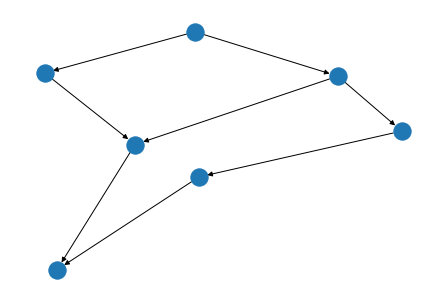

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0,), (0, 2), (1, 3), (0, 2, 4)]
The neg operation is: {(0, 2, 4): (), (0, 1, 3): (0, 2, 4), (): (0, 2, 4), (0, 2): (0, 1, 3), (0,): (1, 3), (0, 1, 2, 3, 4): (0, 2, 4), (1, 3): (0, 2, 4)}
The compatibility relation from Definition 3.5(i) is: [((0,), (0,)), ((0,), (0, 2)), ((0,), (0, 2, 4)), ((0, 2), (0, 2)), ((0, 2), (0, 2, 4)), ((1, 3), (1, 3)), ((0, 2, 4), (1, 3)), ((0, 2, 4), (0, 2, 4))]


2
Original compatibility relation: [(0, 2), (0, 4), (4, 0), (1, 3), (3, 1), (4, 1), (4, 2), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (3,), (0, 4), (1, 3), (0, 2, 4), (0, 1, 3, 4)]


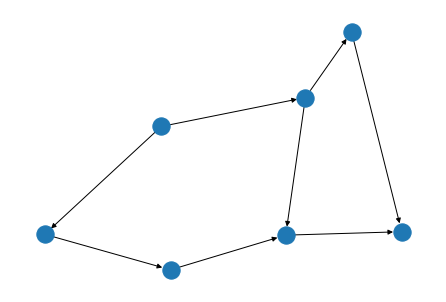

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(3,), (0, 4), (1, 3), (0, 2, 4)]
The neg operation is: {(0, 1, 3, 4): (0, 4), (0, 4): (), (0, 2, 4): (0, 1, 3, 4), (): (0, 1, 3, 4), (3,): (0, 2, 4), (0, 1, 2, 3, 4): (0, 1, 3, 4), (1, 3): ()}
The compatibility relation from Definition 3.5(i) is: [((3,), (3,)), ((3,), (1, 3)), ((0, 4), (0, 4)), ((0, 4), (0, 2, 4)), ((1, 3), (0, 4)), ((1, 3), (1, 3)), ((1, 3), (0, 2, 4)), ((0, 2, 4), (0, 2, 4))]


3
Original compatibility relation: [(0, 2), (2, 0), (0, 4), (3, 1), (1, 4), (4, 1), (2, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (3,), (0, 2), (1, 3), (0, 2, 3), (0, 2, 4)]


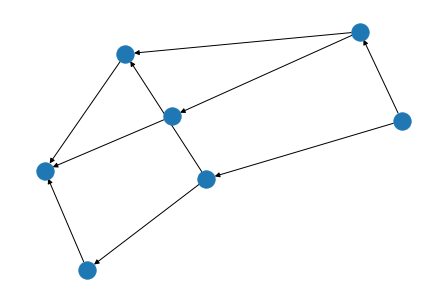

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(3,), (0, 2), (1, 3), (0, 2, 4)]
The neg operation is: {(1, 3): (0, 2, 4), (0, 2, 4): (0, 2, 3), (): (1, 3), (0, 2, 3): (1, 3), (0, 2): (1, 3), (0, 1, 2, 3, 4): (1, 3), (3,): (0, 2, 4)}
The compatibility relation from Definition 3.5(i) is: [((3,), (3,)), ((3,), (1, 3)), ((0, 2), (0, 2)), ((0, 2), (0, 2, 4)), ((1, 3), (3,)), ((1, 3), (1, 3)), ((0, 2, 4), (1, 3)), ((0, 2, 4), (0, 2, 4))]


4
Original compatibility relation: [(0, 2), (2, 0), (4, 0), (1, 3), (1, 4), (4, 1), (4, 2), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (3,), (0, 2), (1, 4), (1, 3, 4), (0, 1, 2, 4)]


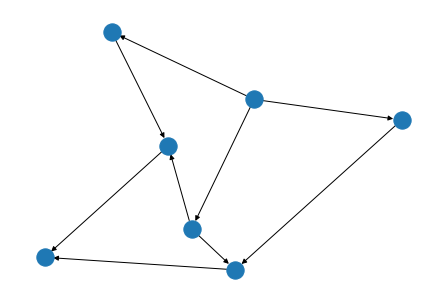

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: ((3,), (0, 2), (1, 4), (1, 3, 4), (0, 1, 2, 4))
The neg operation is: {(0, 1, 2, 4): (1, 3, 4), (1, 3, 4): (0, 1, 2, 4), (1, 4): (0, 2), (0, 2): (3,), (3,): (0, 1, 2, 4)}
The compatibility relation from Definition 3.5(i) is: [((3,), (3,)), ((3,), (1, 3, 4)), ((0, 2), (0, 2)), ((0, 2), (1, 4)), ((0, 2), (1, 3, 4)), ((0, 2), (0, 1, 2, 4)), ((1, 4), (3,)), ((1, 4), (1, 4)), ((1, 4), (1, 3, 4)), ((1, 4), (0, 1, 2, 4)), ((1, 3, 4), (3,)), ((1, 3, 4), (1, 3, 4)), ((0, 1, 2, 4), (0, 2)), ((0, 1, 2, 4), (0, 1, 2, 4))]


5
Original compatibility relation: [(0, 2), (2, 0), (0, 4), (1, 3), (1, 4), (2, 4), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (0, 2), (1, 3), (0, 1, 2), (0, 1, 2, 3)]


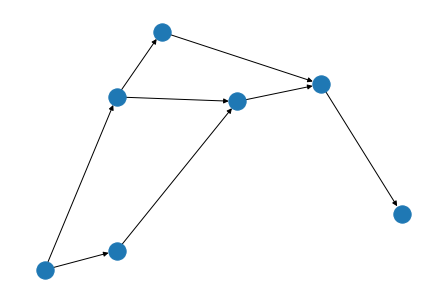

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0, 1, 2, 3, 4), (1,), (0, 2), (1, 3)]
The neg operation is: {(): (), (1,): (), (0, 2): (), (0, 1, 2, 3): (), (0, 1, 2): (), (0, 1, 2, 3, 4): (), (1, 3): ()}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((1,), (0, 1, 2, 3, 4)), ((1,), (1,)), ((1,), (1, 3)), ((0, 2), (0, 1, 2, 3, 4)), ((0, 2), (0, 2)), ((1, 3), (0, 1, 2, 3, 4)), ((1, 3), (1, 3))]


6
Original compatibility relation: [(0, 2), (2, 0), (0, 4), (1, 3), (1, 4), (2, 4), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (0, 2), (1, 3), (0, 1, 2), (0, 1, 2, 4)]


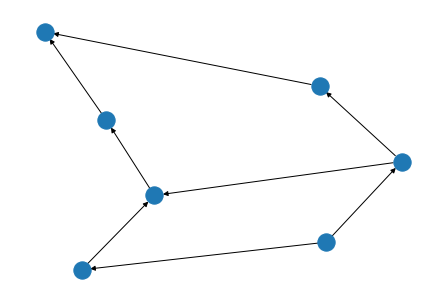

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(1,), (0, 2), (1, 3), (0, 1, 2, 4)]
The neg operation is: {(): (), (0, 1, 2, 4): (), (1,): (), (0, 2): (1, 3), (0, 1, 2): (), (0, 1, 2, 3, 4): (), (1, 3): ()}
The compatibility relation from Definition 3.5(i) is: [((1,), (1,)), ((1,), (1, 3)), ((1,), (0, 1, 2, 4)), ((0, 2), (0, 2)), ((0, 2), (0, 1, 2, 4)), ((1, 3), (1, 3)), ((0, 1, 2, 4), (1, 3)), ((0, 1, 2, 4), (0, 1, 2, 4))]


7
Original compatibility relation: [(0, 2), (2, 0), (4, 0), (1, 3), (1, 4), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (0, 2), (1, 4), (1, 3, 4), (0, 1, 2, 4)]


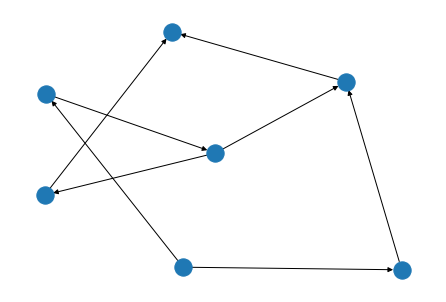

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(1,), (0, 2), (1, 4), (1, 3, 4)]
The neg operation is: {(): (), (0, 1, 2, 4): (), (1, 4): (), (1, 3, 4): (), (1,): (0, 2), (0, 2): (), (0, 1, 2, 3, 4): ()}
The compatibility relation from Definition 3.5(i) is: [((1,), (1,)), ((1,), (1, 4)), ((1,), (1, 3, 4)), ((0, 2), (0, 2)), ((1, 4), (0, 2)), ((1, 4), (1, 4)), ((1, 4), (1, 3, 4)), ((1, 3, 4), (1, 3, 4))]


8
Original compatibility relation: [(0, 2), (2, 0), (4, 0), (1, 3), (4, 1), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (4,), (1, 4), (0, 2, 4), (1, 3, 4), (0, 1, 2, 4)]


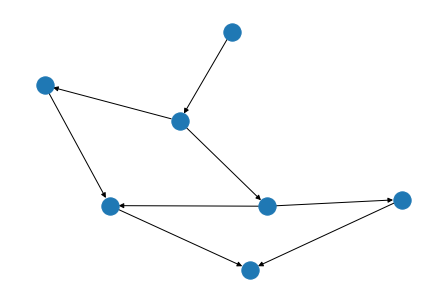

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(4,), (1, 4), (0, 2, 4), (1, 3, 4)]
The neg operation is: {(0, 2, 4): (), (): (0, 2, 4), (0, 1, 2, 4): (0, 2, 4), (1, 4): (0, 2, 4), (4,): (), (1, 3, 4): (0, 2, 4), (0, 1, 2, 3, 4): (0, 2, 4)}
The compatibility relation from Definition 3.5(i) is: [((4,), (4,)), ((4,), (1, 4)), ((4,), (0, 2, 4)), ((4,), (1, 3, 4)), ((1, 4), (1, 4)), ((1, 4), (1, 3, 4)), ((0, 2, 4), (0, 2, 4)), ((1, 3, 4), (1, 3, 4))]


9
Original compatibility relation: [(0, 2), (0, 3), (0, 4), (4, 0), (1, 3), (3, 1), (4, 1), (4, 2), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (3,), (0, 4), (0, 2, 4), (0, 1, 3, 4)]


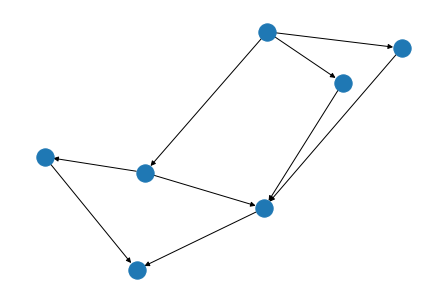

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(1,), (3,), (0, 4), (0, 2, 4)]
The neg operation is: {(0, 1, 3, 4): (0, 4), (0, 4): (1,), (0, 2, 4): (0, 1, 3, 4), (): (0, 1, 3, 4), (1,): (3,), (0, 1, 2, 3, 4): (0, 1, 3, 4), (3,): (0, 2, 4)}
The compatibility relation from Definition 3.5(i) is: [((1,), (1,)), ((1,), (0, 4)), ((1,), (0, 2, 4)), ((3,), (1,)), ((3,), (3,)), ((0, 4), (3,)), ((0, 4), (0, 4)), ((0, 4), (0, 2, 4)), ((0, 2, 4), (0, 2, 4))]


10
Original compatibility relation: [(2, 0), (3, 0), (0, 4), (4, 0), (1, 3), (3, 1), (1, 4), (2, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (2,), (0, 2), (1, 3), (2, 4), (1, 2, 3)]


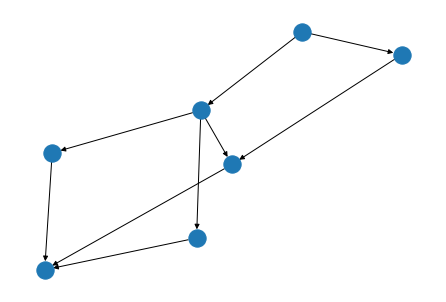

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(2,), (0, 2), (1, 3), (2, 4)]
The neg operation is: {(2, 4): (1, 2, 3), (2,): (), (): (2, 4), (1, 2, 3): (2, 4), (0, 2): (2, 4), (0, 1, 2, 3, 4): (2, 4), (1, 3): (0, 2)}
The compatibility relation from Definition 3.5(i) is: [((2,), (2,)), ((2,), (0, 2)), ((2,), (2, 4)), ((0, 2), (0, 2)), ((0, 2), (1, 3)), ((1, 3), (1, 3)), ((1, 3), (2, 4)), ((2, 4), (0, 2)), ((2, 4), (2, 4))]


11
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (4, 0), (1, 3), (1, 4), (2, 4), (4, 2), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (0, 2), (1, 3), (1, 4), (0, 1, 2, 4)]


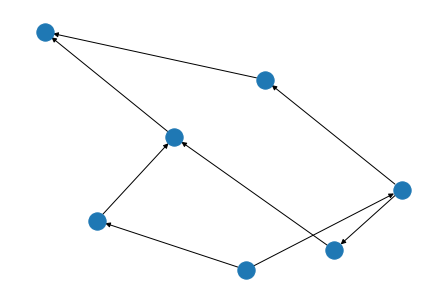

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(1,), (0, 2), (1, 3), (1, 4)]
The neg operation is: {(): (), (0, 1, 2, 4): (), (1, 4): (1, 3), (1,): (0, 2), (0, 2): (), (0, 1, 2, 3, 4): (0, 1, 2, 4), (1, 3): ()}
The compatibility relation from Definition 3.5(i) is: [((1,), (1,)), ((1,), (1, 3)), ((1,), (1, 4)), ((0, 2), (0, 2)), ((0, 2), (1, 3)), ((1, 3), (1, 3)), ((1, 4), (0, 2)), ((1, 4), (1, 4))]


12
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (4, 0), (1, 3), (3, 1), (1, 4), (2, 4), (4, 2), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (2,), (0, 2), (1, 3), (2, 4)]


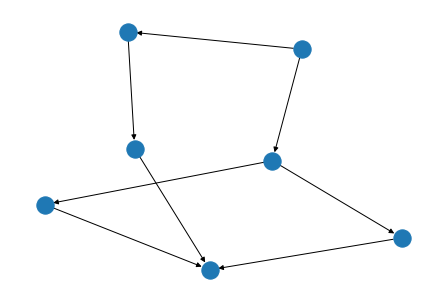

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(1,), (2,), (0, 2), (1, 3), (2, 4)]
The neg operation is: {(2, 4): (2,), (2,): (1,), (): (2, 4), (1,): (2, 4), (0, 2): (1, 3), (0, 1, 2, 3, 4): (2, 4), (1, 3): (0, 2)}
The compatibility relation from Definition 3.5(i) is: [((1,), (1,)), ((1,), (0, 2)), ((1,), (1, 3)), ((2,), (2,)), ((2,), (0, 2)), ((2,), (1, 3)), ((2,), (2, 4)), ((0, 2), (2,)), ((0, 2), (0, 2)), ((0, 2), (2, 4)), ((1, 3), (1,)), ((1, 3), (1, 3)), ((1, 3), (2, 4)), ((2, 4), (1,)), ((2, 4), (0, 2)), ((2, 4), (1, 3)), ((2, 4), (2, 4))]


13
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (4, 0), (1, 3), (3, 1), (4, 1), (2, 4), (4, 2), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (3,), (1, 3), (2, 4), (0, 2, 4)]


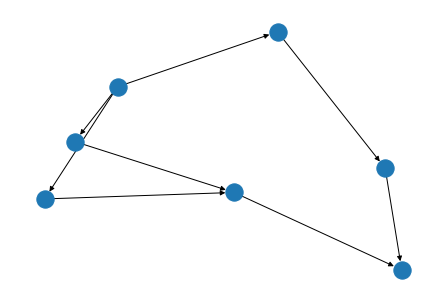

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: ((1,), (3,), (1, 3), (2, 4), (0, 2, 4))
The neg operation is: {(1, 3): (2, 4), (2, 4): (1, 3), (0, 2, 4): (1,), (1,): (3,), (3,): (0, 2, 4)}
The compatibility relation from Definition 3.5(i) is: [((1,), (1,)), ((1,), (1, 3)), ((1,), (2, 4)), ((1,), (0, 2, 4)), ((3,), (1,)), ((3,), (3,)), ((3,), (1, 3)), ((1, 3), (1,)), ((1, 3), (3,)), ((1, 3), (1, 3)), ((1, 3), (0, 2, 4)), ((2, 4), (2, 4)), ((2, 4), (0, 2, 4)), ((0, 2, 4), (3,)), ((0, 2, 4), (1, 3)), ((0, 2, 4), (2, 4)), ((0, 2, 4), (0, 2, 4))]


14
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (0, 4), (1, 3), (3, 1), (4, 1), (2, 4), (4, 2), (3, 4), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (1,), (0, 2), (1, 3), (0, 2, 4)]


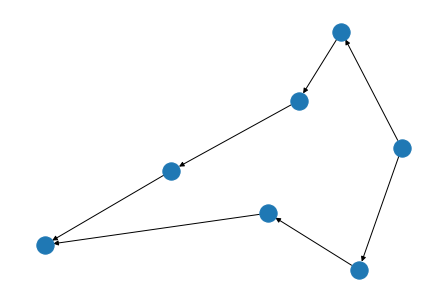

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0,), (1,), (0, 2), (1, 3), (0, 2, 4)]
The neg operation is: {(0, 2, 4): (), (): (0, 2, 4), (1,): (0, 2, 4), (0, 2): (), (0,): (1, 3), (0, 1, 2, 3, 4): (0, 2, 4), (1, 3): ()}
The compatibility relation from Definition 3.5(i) is: [((0,), (0,)), ((0,), (0, 2)), ((0,), (0, 2, 4)), ((1,), (1,)), ((1,), (1, 3)), ((0, 2), (1,)), ((0, 2), (0, 2)), ((0, 2), (1, 3)), ((0, 2), (0, 2, 4)), ((1, 3), (0,)), ((1, 3), (0, 2)), ((1, 3), (1, 3)), ((1, 3), (0, 2, 4)), ((0, 2, 4), (1,)), ((0, 2, 4), (1, 3)), ((0, 2, 4), (0, 2, 4))]


15
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (4, 0), (1, 3), (3, 1), (1, 4), (4, 2), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (0, 2), (1, 3), (1, 4), (1, 3, 4)]


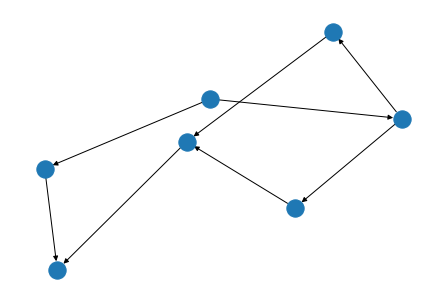

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(1,), (0, 2), (1, 3), (1, 4)]
The neg operation is: {(): (), (1, 4): (), (1, 3, 4): (), (1,): (0, 2), (0, 2): (), (0, 1, 2, 3, 4): (), (1, 3): ()}
The compatibility relation from Definition 3.5(i) is: [((1,), (1,)), ((1,), (1, 3)), ((1,), (1, 4)), ((0, 2), (0, 2)), ((1, 3), (0, 2)), ((1, 3), (1, 3)), ((1, 4), (0, 2)), ((1, 4), (1, 4))]


16
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (4, 0), (1, 3), (3, 1), (1, 4), (4, 1), (2, 4), (4, 2), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (3,), (0, 2), (1, 3), (1, 4)]


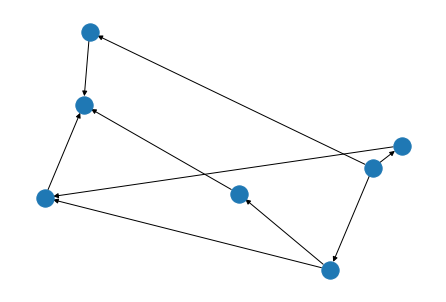

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(1,), (3,), (0, 2), (1, 4)]
The neg operation is: {(1, 3): (), (): (1, 3), (1, 4): (1, 3), (1,): (), (0, 2): (1, 4), (0, 1, 2, 3, 4): (1, 3), (3,): (0, 2)}
The compatibility relation from Definition 3.5(i) is: [((1,), (1,)), ((1,), (0, 2)), ((1,), (1, 4)), ((3,), (1,)), ((3,), (3,)), ((3,), (1, 4)), ((0, 2), (3,)), ((0, 2), (0, 2)), ((1, 4), (0, 2)), ((1, 4), (1, 4))]


17
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (1, 3), (3, 1), (1, 4), (2, 4), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (2,), (0, 2), (1, 3), (0, 1, 2, 3)]


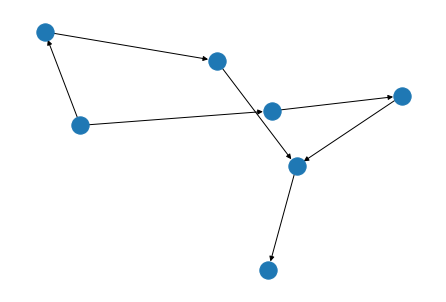

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0, 1, 2, 3, 4), (1,), (2,), (0, 2), (1, 3)]
The neg operation is: {(2,): (1,), (): (2,), (1,): (2,), (0, 2): (1, 3), (0, 1, 2, 3): (2,), (0, 1, 2, 3, 4): (2,), (1, 3): (0, 2)}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((1,), (0, 1, 2, 3, 4)), ((1,), (1,)), ((1,), (0, 2)), ((1,), (1, 3)), ((2,), (0, 1, 2, 3, 4)), ((2,), (2,)), ((2,), (0, 2)), ((2,), (1, 3)), ((0, 2), (0, 1, 2, 3, 4)), ((0, 2), (2,)), ((0, 2), (0, 2)), ((1, 3), (0, 1, 2, 3, 4)), ((1, 3), (1,)), ((1, 3), (1, 3))]


18
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (4, 0), (1, 3), (3, 1), (4, 1), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (4,), (1, 4), (2, 4), (0, 2, 4), (1, 3, 4)]


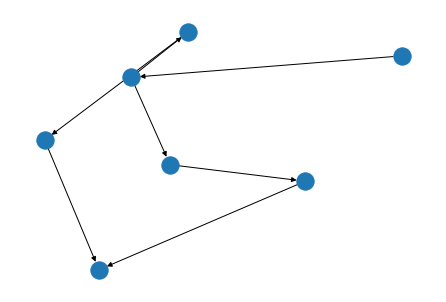

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(4,), (1, 4), (2, 4), (0, 2, 4), (1, 3, 4)]
The neg operation is: {(2, 4): (1, 4), (0, 2, 4): (1, 3, 4), (): (2, 4), (1, 4): (2, 4), (4,): (), (1, 3, 4): (0, 2, 4), (0, 1, 2, 3, 4): (2, 4)}
The compatibility relation from Definition 3.5(i) is: [((4,), (4,)), ((4,), (1, 4)), ((4,), (2, 4)), ((4,), (0, 2, 4)), ((4,), (1, 3, 4)), ((1, 4), (1, 4)), ((1, 4), (0, 2, 4)), ((1, 4), (1, 3, 4)), ((2, 4), (2, 4)), ((2, 4), (0, 2, 4)), ((2, 4), (1, 3, 4)), ((0, 2, 4), (2, 4)), ((0, 2, 4), (0, 2, 4)), ((1, 3, 4), (1, 4)), ((1, 3, 4), (1, 3, 4))]


19
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (3, 1), (1, 4), (4, 1), (2, 3), (2, 4), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (2,), (0, 2), (2, 4), (0, 2, 3)]


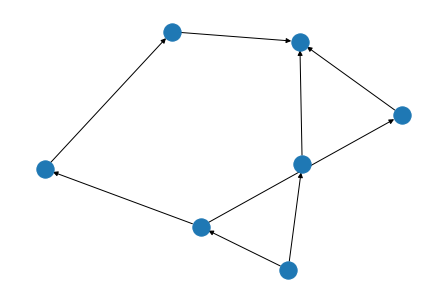

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(1,), (2,), (0, 2), (2, 4), (0, 2, 3)]
The neg operation is: {(2, 4): (2,), (2,): (1,), (): (2, 4), (0, 2, 3): (2,), (1,): (2,), (0, 2): (2, 4), (0, 1, 2, 3, 4): (2, 4)}
The compatibility relation from Definition 3.5(i) is: [((1,), (1,)), ((1,), (2, 4)), ((2,), (2,)), ((2,), (0, 2)), ((2,), (2, 4)), ((2,), (0, 2, 3)), ((0, 2), (1,)), ((0, 2), (0, 2)), ((0, 2), (0, 2, 3)), ((2, 4), (1,)), ((2, 4), (2, 4)), ((0, 2, 3), (1,)), ((0, 2, 3), (2, 4)), ((0, 2, 3), (0, 2, 3))]


20
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (1, 3), (3, 1), (4, 1), (2, 3), (2, 4), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (2,), (0, 2), (0, 2, 3), (0, 2, 4)]


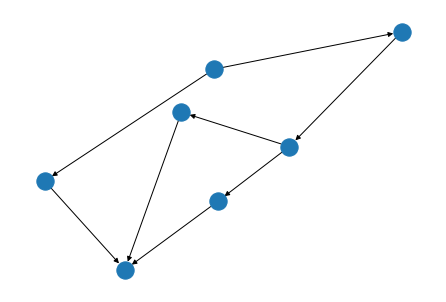

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(1,), (2,), (0, 2), (0, 2, 3), (0, 2, 4)]
The neg operation is: {(2,): (), (0, 2, 4): (2,), (): (2,), (0, 2, 3): (0, 2, 4), (1,): (0, 2, 3), (0, 2): (1,), (0, 1, 2, 3, 4): (2,)}
The compatibility relation from Definition 3.5(i) is: [((1,), (1,)), ((1,), (0, 2, 4)), ((2,), (1,)), ((2,), (2,)), ((2,), (0, 2)), ((2,), (0, 2, 3)), ((2,), (0, 2, 4)), ((0, 2), (2,)), ((0, 2), (0, 2)), ((0, 2), (0, 2, 3)), ((0, 2), (0, 2, 4)), ((0, 2, 3), (1,)), ((0, 2, 3), (0, 2, 3)), ((0, 2, 4), (1,)), ((0, 2, 4), (0, 2)), ((0, 2, 4), (0, 2, 3)), ((0, 2, 4), (0, 2, 4))]


21
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (1, 3), (3, 1), (1, 4), (4, 1), (3, 2), (2, 4), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (1,), (4,), (0, 2), (1, 3)]


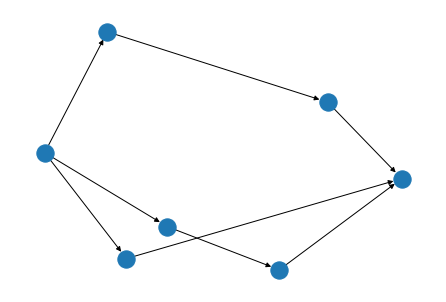

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0,), (1,), (4,), (0, 2), (1, 3)]
The neg operation is: {(): (), (4,): (1,), (1,): (4,), (0, 2): (), (0,): (1, 3), (0, 1, 2, 3, 4): (), (1, 3): (0, 2)}
The compatibility relation from Definition 3.5(i) is: [((0,), (0,)), ((0,), (4,)), ((0,), (0, 2)), ((1,), (0,)), ((1,), (1,)), ((1,), (0, 2)), ((1,), (1, 3)), ((4,), (0,)), ((4,), (4,)), ((4,), (0, 2)), ((4,), (1, 3)), ((0, 2), (1,)), ((0, 2), (4,)), ((0, 2), (0, 2)), ((0, 2), (1, 3)), ((1, 3), (1,)), ((1, 3), (4,)), ((1, 3), (1, 3))]


22
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (4, 0), (1, 3), (1, 4), (4, 1), (3, 2), (4, 2), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (3,), (0, 2), (1, 4), (1, 3, 4)]


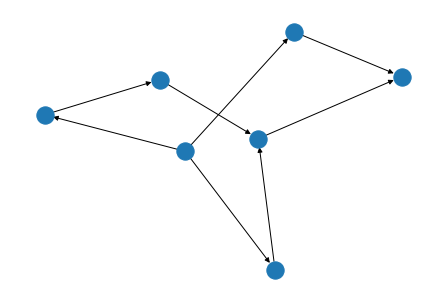

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: ((1,), (3,), (0, 2), (1, 4), (1, 3, 4))
The neg operation is: {(1, 3, 4): (1, 4), (1, 4): (1,), (1,): (3,), (0, 2): (1, 3, 4), (3,): (0, 2)}
The compatibility relation from Definition 3.5(i) is: [((1,), (1,)), ((1,), (0, 2)), ((1,), (1, 4)), ((1,), (1, 3, 4)), ((3,), (1,)), ((3,), (3,)), ((3,), (1, 4)), ((3,), (1, 3, 4)), ((0, 2), (0, 2)), ((1, 4), (3,)), ((1, 4), (0, 2)), ((1, 4), (1, 4)), ((1, 4), (1, 3, 4)), ((1, 3, 4), (3,)), ((1, 3, 4), (0, 2)), ((1, 3, 4), (1, 3, 4))]


23
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (4, 0), (1, 3), (3, 1), (1, 4), (3, 2), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (4,), (0, 2), (1, 4), (1, 3, 4)]


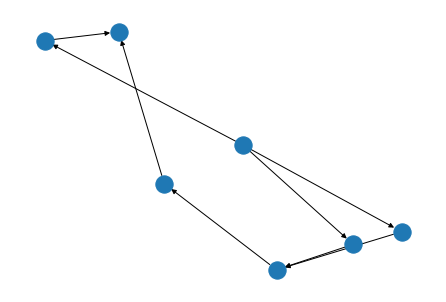

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: ((0, 1, 2, 3, 4), (1,), (4,), (0, 2), (1, 3, 4))
The neg operation is: {(1, 3, 4): (4,), (4,): (1,), (1,): (4,), (0, 2): (1, 3, 4), (0, 1, 2, 3, 4): (0, 2)}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((0, 1, 2, 3, 4), (1,)), ((0, 1, 2, 3, 4), (4,)), ((0, 1, 2, 3, 4), (1, 3, 4)), ((1,), (0, 1, 2, 3, 4)), ((1,), (1,)), ((1,), (0, 2)), ((1,), (1, 3, 4)), ((4,), (0, 1, 2, 3, 4)), ((4,), (4,)), ((4,), (0, 2)), ((4,), (1, 3, 4)), ((0, 2), (0, 1, 2, 3, 4)), ((0, 2), (0, 2)), ((1, 3, 4), (0, 1, 2, 3, 4)), ((1, 3, 4), (0, 2)), ((1, 3, 4), (1, 3, 4))]


24
Original compatibility relation: [(0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 4), (4, 2), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (1,), (0, 1), (0, 1, 3), (0, 1, 2, 4)]


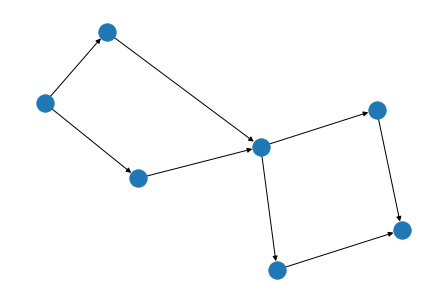

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0,), (1,), (0, 1, 3), (0, 1, 2, 4)]
The neg operation is: {(0, 1): (), (0, 1, 3): (0, 1), (): (0, 1), (0, 1, 2, 4): (0, 1), (1,): (), (0,): (), (0, 1, 2, 3, 4): (0, 1)}
The compatibility relation from Definition 3.5(i) is: [((0,), (0,)), ((0,), (0, 1, 3)), ((0,), (0, 1, 2, 4)), ((1,), (1,)), ((1,), (0, 1, 3)), ((1,), (0, 1, 2, 4)), ((0, 1, 3), (0, 1, 3)), ((0, 1, 2, 4), (0, 1, 2, 4))]


25
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (1, 2), (2, 1), (1, 3), (3, 1), (1, 4), (2, 4), (4, 2), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (1,), (3,), (2, 4), (0, 1, 3)]


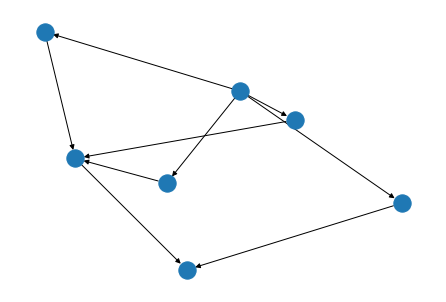

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: ((0,), (1,), (3,), (2, 4), (0, 1, 3))
The neg operation is: {(2, 4): (0, 1, 3), (0, 1, 3): (2, 4), (1,): (0,), (0,): (3,), (3,): (1,)}
The compatibility relation from Definition 3.5(i) is: [((0,), (0,)), ((0,), (1,)), ((0,), (2, 4)), ((0,), (0, 1, 3)), ((1,), (1,)), ((1,), (3,)), ((1,), (2, 4)), ((1,), (0, 1, 3)), ((3,), (0,)), ((3,), (3,)), ((3,), (2, 4)), ((3,), (0, 1, 3)), ((2, 4), (2, 4)), ((0, 1, 3), (0,)), ((0, 1, 3), (1,)), ((0, 1, 3), (3,)), ((0, 1, 3), (0, 1, 3))]


26
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (4, 0), (1, 2), (2, 1), (1, 3), (3, 1), (4, 1), (2, 4), (4, 2), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (3,), (4,), (0, 4), (1, 4), (2, 4)]


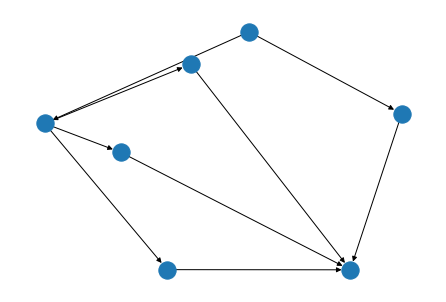

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(3,), (4,), (0, 4), (1, 4), (2, 4)]
The neg operation is: {(2, 4): (0, 4), (0, 4): (2, 4), (): (2, 4), (4,): (), (1, 4): (3,), (0, 1, 2, 3, 4): (2, 4), (3,): (1, 4)}
The compatibility relation from Definition 3.5(i) is: [((3,), (3,)), ((3,), (0, 4)), ((3,), (2, 4)), ((4,), (3,)), ((4,), (4,)), ((4,), (0, 4)), ((4,), (1, 4)), ((4,), (2, 4)), ((0, 4), (3,)), ((0, 4), (0, 4)), ((0, 4), (1, 4)), ((1, 4), (4,)), ((1, 4), (0, 4)), ((1, 4), (1, 4)), ((1, 4), (2, 4)), ((2, 4), (3,)), ((2, 4), (1, 4)), ((2, 4), (2, 4))]


27
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (4, 0), (1, 2), (2, 1), (1, 3), (3, 1), (1, 4), (2, 4), (4, 2), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (1,), (3,), (1, 3), (2, 4)]


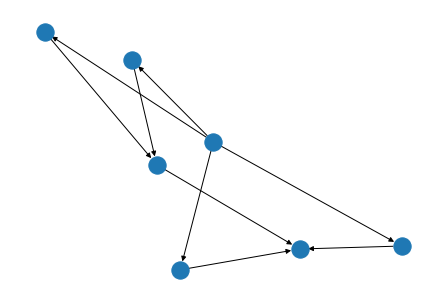

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: ((0,), (1,), (3,), (1, 3), (2, 4))
The neg operation is: {(1, 3): (2, 4), (2, 4): (1, 3), (1,): (0,), (0,): (3,), (3,): (1,)}
The compatibility relation from Definition 3.5(i) is: [((0,), (0,)), ((0,), (1,)), ((0,), (1, 3)), ((0,), (2, 4)), ((1,), (1,)), ((1,), (3,)), ((1,), (1, 3)), ((1,), (2, 4)), ((3,), (0,)), ((3,), (3,)), ((3,), (1, 3)), ((3,), (2, 4)), ((1, 3), (0,)), ((1, 3), (1,)), ((1, 3), (3,)), ((1, 3), (1, 3)), ((2, 4), (0,)), ((2, 4), (2, 4))]


28
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (4, 0), (1, 2), (2, 1), (1, 3), (3, 1), (4, 1), (2, 4), (4, 2), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (3,), (4,), (0, 4), (2, 4)]


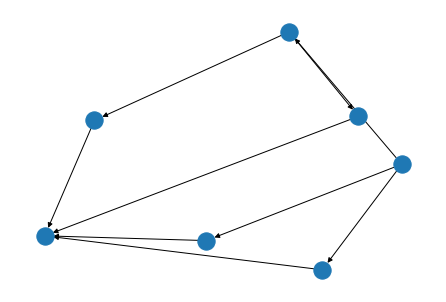

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(1,), (3,), (4,), (0, 4), (2, 4)]
The neg operation is: {(2, 4): (0, 4), (0, 4): (2, 4), (): (2, 4), (4,): (), (1,): (3,), (0, 1, 2, 3, 4): (2, 4), (3,): (1,)}
The compatibility relation from Definition 3.5(i) is: [((1,), (1,)), ((1,), (4,)), ((1,), (0, 4)), ((1,), (2, 4)), ((3,), (3,)), ((3,), (4,)), ((3,), (0, 4)), ((3,), (2, 4)), ((4,), (1,)), ((4,), (3,)), ((4,), (4,)), ((4,), (0, 4)), ((4,), (2, 4)), ((0, 4), (1,)), ((0, 4), (3,)), ((0, 4), (0, 4)), ((2, 4), (1,)), ((2, 4), (3,)), ((2, 4), (2, 4))]


29
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (0, 4), (2, 1), (1, 3), (1, 4), (2, 4), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (3,), (0, 2), (0, 1, 2), (0, 1, 2, 3)]


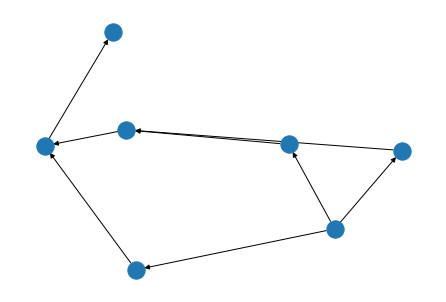

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: ((0, 1, 2, 3, 4), (1,), (3,), (0, 2), (0, 1, 2))
The neg operation is: {(1,): (0, 2), (0, 2): (1,), (0, 1, 2): (3,), (0, 1, 2, 3, 4): (1,), (3,): (1,)}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((1,), (0, 1, 2, 3, 4)), ((1,), (1,)), ((1,), (3,)), ((1,), (0, 1, 2)), ((3,), (0, 1, 2, 3, 4)), ((3,), (3,)), ((0, 2), (0, 1, 2, 3, 4)), ((0, 2), (3,)), ((0, 2), (0, 2)), ((0, 2), (0, 1, 2)), ((0, 1, 2), (0, 1, 2, 3, 4)), ((0, 1, 2), (1,)), ((0, 1, 2), (0, 2)), ((0, 1, 2), (0, 1, 2))]


30
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (4, 0), (2, 1), (1, 3), (4, 1), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (4,), (1, 4), (3, 4), (0, 2, 4), (0, 1, 2, 4)]


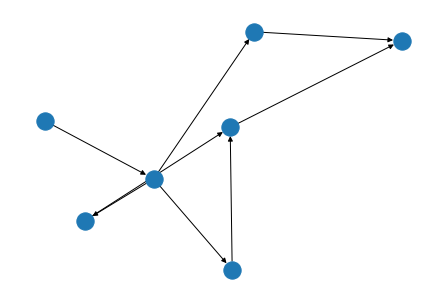

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: ((), (1, 4), (3, 4), (0, 2, 4))
The neg operation is: {(): (3, 4), (3, 4): (), (1, 4): (), (0, 2, 4): ()}
The compatibility relation from Definition 3.5(i) is: [((), (1, 4)), ((), (0, 2, 4)), ((1, 4), (1, 4)), ((1, 4), (3, 4)), ((3, 4), (3, 4)), ((0, 2, 4), (3, 4)), ((0, 2, 4), (0, 2, 4))]


31
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (0, 4), (4, 0), (2, 1), (1, 3), (3, 1), (4, 1), (2, 4), (3, 4), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (1,), (2,), (3,), (0, 2), (0, 2, 4)]


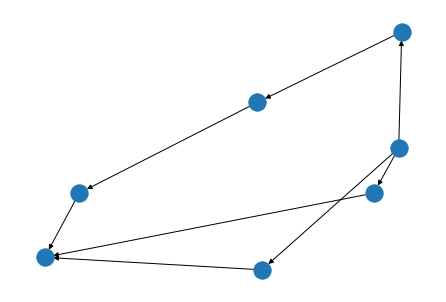

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(1,), (2,), (3,), (0, 2), (0, 2, 4)]
The neg operation is: {(2,): (1,), (0, 2, 4): (2,), (): (2,), (1,): (2,), (0, 2): (3,), (0, 1, 2, 3, 4): (2,), (3,): (0, 2, 4)}
The compatibility relation from Definition 3.5(i) is: [((1,), (1,)), ((1,), (3,)), ((1,), (0, 2)), ((1,), (0, 2, 4)), ((2,), (2,)), ((2,), (3,)), ((2,), (0, 2)), ((2,), (0, 2, 4)), ((3,), (1,)), ((3,), (3,)), ((0, 2), (1,)), ((0, 2), (2,)), ((0, 2), (0, 2)), ((0, 2), (0, 2, 4)), ((0, 2, 4), (1,)), ((0, 2, 4), (3,)), ((0, 2, 4), (0, 2, 4))]


32
Original compatibility relation: [(0, 2), (2, 0), (3, 0), (0, 4), (1, 2), (1, 3), (1, 4), (2, 4), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (1,), (1, 2), (1, 3), (0, 1, 2, 3)]


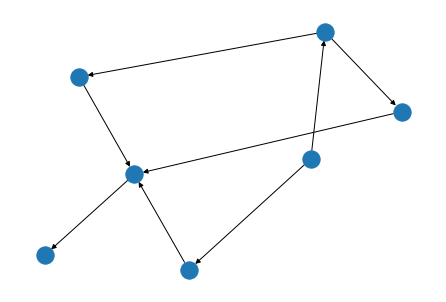

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0, 1, 2, 3, 4), (0,), (1,), (1, 2), (1, 3)]
The neg operation is: {(1, 2): (), (): (1, 2), (1,): (0,), (0, 1, 2, 3): (1, 2), (0,): (), (0, 1, 2, 3, 4): (1, 2), (1, 3): (1, 2)}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((0,), (0, 1, 2, 3, 4)), ((0,), (0,)), ((0,), (1, 2)), ((1,), (0, 1, 2, 3, 4)), ((1,), (1,)), ((1,), (1, 2)), ((1,), (1, 3)), ((1, 2), (0, 1, 2, 3, 4)), ((1, 2), (0,)), ((1, 2), (1, 2)), ((1, 3), (0, 1, 2, 3, 4)), ((1, 3), (0,)), ((1, 3), (1, 3))]


33
Original compatibility relation: [(0, 2), (2, 0), (3, 0), (4, 0), (1, 2), (1, 3), (4, 1), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (4,), (0, 4), (1, 4), (1, 2, 4), (1, 3, 4)]


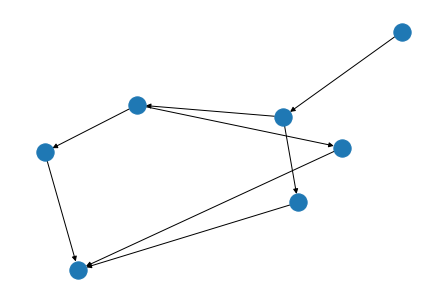

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(4,), (0, 4), (1, 4), (1, 2, 4), (1, 3, 4)]
The neg operation is: {(0, 4): (), (): (0, 4), (1, 4): (0, 4), (4,): (), (1, 3, 4): (), (0, 1, 2, 3, 4): (0, 4), (1, 2, 4): (1, 3, 4)}
The compatibility relation from Definition 3.5(i) is: [((4,), (4,)), ((4,), (0, 4)), ((4,), (1, 4)), ((4,), (1, 2, 4)), ((4,), (1, 3, 4)), ((0, 4), (0, 4)), ((0, 4), (1, 3, 4)), ((1, 4), (1, 4)), ((1, 4), (1, 2, 4)), ((1, 4), (1, 3, 4)), ((1, 2, 4), (0, 4)), ((1, 2, 4), (1, 2, 4)), ((1, 3, 4), (0, 4)), ((1, 3, 4), (1, 3, 4))]


34
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (1, 2), (2, 1), (1, 3), (1, 4), (2, 4), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (1,), (3,), (1, 2), (0, 1, 2, 3)]


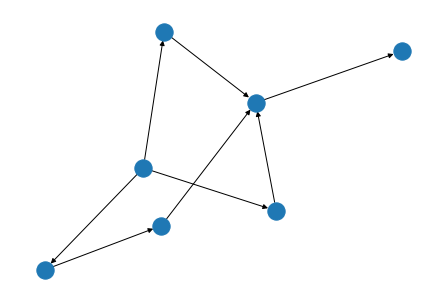

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0, 1, 2, 3, 4), (0,), (1,), (3,), (1, 2)]
The neg operation is: {(1, 2): (), (): (1, 2), (1,): (0,), (0, 1, 2, 3): (1, 2), (0,): (3,), (0, 1, 2, 3, 4): (1, 2), (3,): (1, 2)}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((0,), (0, 1, 2, 3, 4)), ((0,), (0,)), ((0,), (1,)), ((0,), (1, 2)), ((1,), (0, 1, 2, 3, 4)), ((1,), (1,)), ((1,), (3,)), ((1,), (1, 2)), ((3,), (0, 1, 2, 3, 4)), ((3,), (0,)), ((3,), (3,)), ((1, 2), (0, 1, 2, 3, 4)), ((1, 2), (0,)), ((1, 2), (3,)), ((1, 2), (1, 2))]


35
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (1, 2), (2, 1), (1, 3), (3, 1), (1, 4), (2, 4), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (1,), (2,), (3,), (0, 1, 2, 3)]


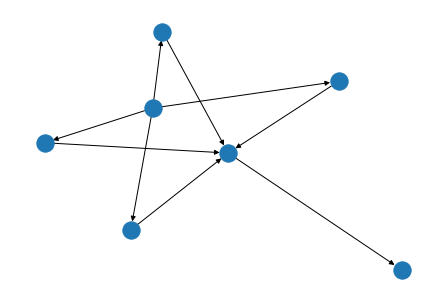

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0, 1, 2, 3, 4), (0,), (1,), (2,), (3,)]
The neg operation is: {(2,): (1,), (): (2,), (1,): (2,), (0, 1, 2, 3): (2,), (0,): (3,), (0, 1, 2, 3, 4): (2,), (3,): (0,)}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((0,), (0, 1, 2, 3, 4)), ((0,), (0,)), ((0,), (1,)), ((0,), (2,)), ((1,), (0, 1, 2, 3, 4)), ((1,), (0,)), ((1,), (1,)), ((1,), (3,)), ((2,), (0, 1, 2, 3, 4)), ((2,), (0,)), ((2,), (2,)), ((2,), (3,)), ((3,), (0, 1, 2, 3, 4)), ((3,), (1,)), ((3,), (2,)), ((3,), (3,))]


36
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (4, 0), (1, 2), (2, 1), (1, 3), (4, 1), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (4,), (0, 4), (1, 4), (3, 4), (1, 2, 4)]


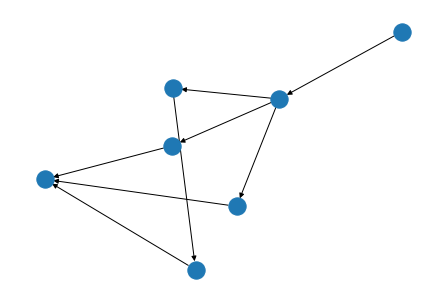

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(4,), (0, 4), (1, 4), (3, 4), (1, 2, 4)]
The neg operation is: {(0, 4): (3, 4), (3, 4): (1, 2, 4), (): (0, 4), (1, 4): (0, 4), (4,): (), (0, 1, 2, 3, 4): (0, 4), (1, 2, 4): ()}
The compatibility relation from Definition 3.5(i) is: [((4,), (4,)), ((4,), (0, 4)), ((4,), (1, 4)), ((4,), (3, 4)), ((4,), (1, 2, 4)), ((0, 4), (0, 4)), ((0, 4), (1, 4)), ((0, 4), (1, 2, 4)), ((1, 4), (1, 4)), ((1, 4), (3, 4)), ((1, 4), (1, 2, 4)), ((3, 4), (0, 4)), ((3, 4), (3, 4)), ((1, 2, 4), (0, 4)), ((1, 2, 4), (3, 4)), ((1, 2, 4), (1, 2, 4))]


37
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (4, 0), (1, 2), (2, 1), (1, 3), (3, 1), (4, 1), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (4,), (0, 4), (1, 4), (2, 4), (3, 4)]


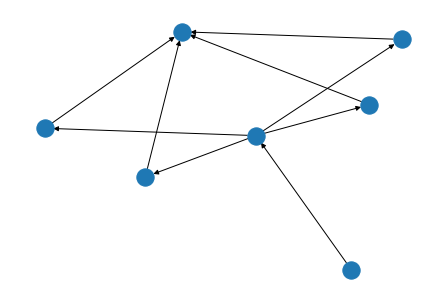

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(4,), (0, 4), (1, 4), (2, 4), (3, 4)]
The neg operation is: {(2, 4): (0, 4), (0, 4): (2, 4), (3, 4): (1, 4), (): (2, 4), (1, 4): (3, 4), (4,): (), (0, 1, 2, 3, 4): (2, 4)}
The compatibility relation from Definition 3.5(i) is: [((4,), (4,)), ((4,), (0, 4)), ((4,), (1, 4)), ((4,), (2, 4)), ((4,), (3, 4)), ((0, 4), (0, 4)), ((0, 4), (1, 4)), ((0, 4), (3, 4)), ((1, 4), (0, 4)), ((1, 4), (1, 4)), ((1, 4), (2, 4)), ((2, 4), (1, 4)), ((2, 4), (2, 4)), ((2, 4), (3, 4)), ((3, 4), (0, 4)), ((3, 4), (2, 4)), ((3, 4), (3, 4))]


38
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (4, 0), (1, 2), (2, 1), (1, 3), (3, 1), (1, 4), (4, 1), (2, 4), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (1,), (2,), (3,), (2, 4)]


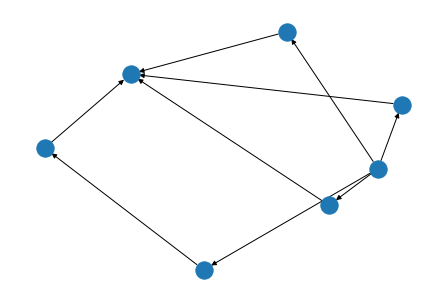

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0,), (1,), (2,), (3,), (2, 4)]
The neg operation is: {(2, 4): (2,), (2,): (1,), (): (2, 4), (1,): (2, 4), (0,): (3,), (0, 1, 2, 3, 4): (2, 4), (3,): (0,)}
The compatibility relation from Definition 3.5(i) is: [((0,), (0,)), ((0,), (1,)), ((0,), (2,)), ((0,), (2, 4)), ((1,), (0,)), ((1,), (1,)), ((1,), (3,)), ((2,), (0,)), ((2,), (2,)), ((2,), (3,)), ((2,), (2, 4)), ((3,), (1,)), ((3,), (2,)), ((3,), (3,)), ((3,), (2, 4)), ((2, 4), (0,)), ((2, 4), (1,)), ((2, 4), (3,)), ((2, 4), (2, 4))]


39
Original compatibility relation: [(0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (1,), (0, 1), (0, 1, 2), (0, 1, 2, 3)]


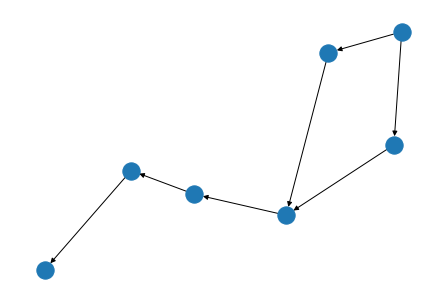

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0, 1, 2, 3, 4), (0,), (1,), (0, 1, 2), (0, 1, 2, 3)]
The neg operation is: {(0, 1): (), (0, 1, 2): (0, 1), (): (0, 1), (1,): (), (0, 1, 2, 3): (0, 1), (0,): (), (0, 1, 2, 3, 4): (0, 1)}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((0,), (0, 1, 2, 3, 4)), ((0,), (0,)), ((0,), (0, 1, 2)), ((0,), (0, 1, 2, 3)), ((1,), (0, 1, 2, 3, 4)), ((1,), (1,)), ((1,), (0, 1, 2)), ((1,), (0, 1, 2, 3)), ((0, 1, 2), (0, 1, 2, 3, 4)), ((0, 1, 2), (0, 1, 2)), ((0, 1, 2), (0, 1, 2, 3)), ((0, 1, 2, 3), (0, 1, 2, 3, 4)), ((0, 1, 2, 3), (0, 1, 2, 3))]


40
Original compatibility relation: [(0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (4, 1), (2, 3), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (1,), (0, 4), (0, 1, 4), (0, 1, 2, 4)]


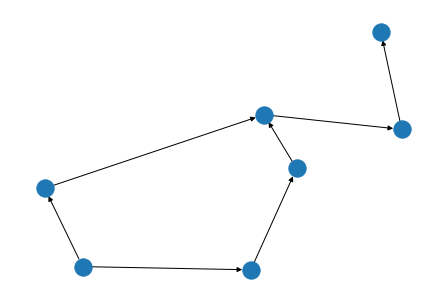

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0, 1, 2, 3, 4), (0,), (1,), (0, 4), (0, 1, 2, 4)]
The neg operation is: {(0, 1, 4): (0, 4), (0, 4): (), (): (0, 1, 4), (0, 1, 2, 4): (0, 1, 4), (1,): (0, 4), (0,): (1,), (0, 1, 2, 3, 4): (0, 1, 4)}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((0,), (0, 1, 2, 3, 4)), ((0,), (0,)), ((0,), (0, 4)), ((0,), (0, 1, 2, 4)), ((1,), (0, 1, 2, 3, 4)), ((1,), (1,)), ((1,), (0, 1, 2, 4)), ((0, 4), (0, 1, 2, 3, 4)), ((0, 4), (1,)), ((0, 4), (0, 4)), ((0, 4), (0, 1, 2, 4)), ((0, 1, 2, 4), (0, 1, 2, 3, 4)), ((0, 1, 2, 4), (0, 1, 2, 4))]


41
Original compatibility relation: [(0, 2), (0, 3), (0, 4), (1, 2), (3, 1), (4, 1), (3, 2), (4, 2), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (1,), (0, 3), (0, 3, 4), (0, 1, 3, 4)]


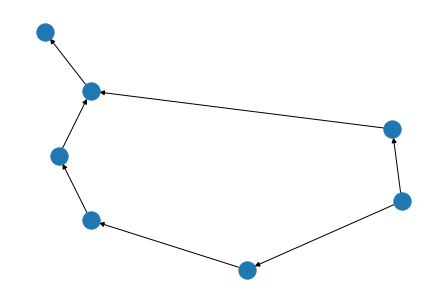

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0, 1, 2, 3, 4), (0,), (1,), (0, 3), (0, 3, 4)]
The neg operation is: {(0, 1, 3, 4): (0, 3, 4), (0, 3, 4): (), (): (0, 1, 3, 4), (0, 3): (), (1,): (0, 3, 4), (0,): (1,), (0, 1, 2, 3, 4): (0, 1, 3, 4)}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((0,), (0, 1, 2, 3, 4)), ((0,), (0,)), ((0,), (0, 3)), ((0,), (0, 3, 4)), ((1,), (0, 1, 2, 3, 4)), ((1,), (1,)), ((0, 3), (0, 1, 2, 3, 4)), ((0, 3), (1,)), ((0, 3), (0, 3)), ((0, 3), (0, 3, 4)), ((0, 3, 4), (0, 1, 2, 3, 4)), ((0, 3, 4), (1,)), ((0, 3, 4), (0, 3, 4))]


42
Original compatibility relation: [(0, 2), (0, 3), (0, 4), (2, 1), (3, 1), (4, 1), (2, 3), (2, 4), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (1,), (0, 2), (0, 2, 3), (0, 2, 3, 4)]


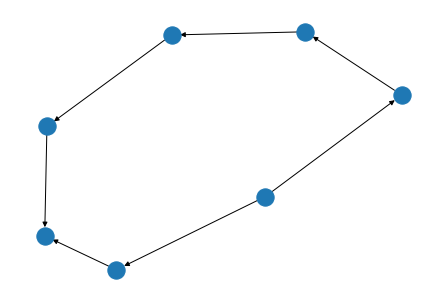

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0,), (1,), (0, 2), (0, 2, 3), (0, 2, 3, 4)]
The neg operation is: {(): (), (0, 2, 3): (), (1,): (), (0, 2): (), (0, 2, 3, 4): (), (0,): (1,), (0, 1, 2, 3, 4): ()}
The compatibility relation from Definition 3.5(i) is: [((0,), (0,)), ((0,), (0, 2)), ((0,), (0, 2, 3)), ((0,), (0, 2, 3, 4)), ((1,), (1,)), ((0, 2), (1,)), ((0, 2), (0, 2)), ((0, 2), (0, 2, 3)), ((0, 2), (0, 2, 3, 4)), ((0, 2, 3), (1,)), ((0, 2, 3), (0, 2, 3)), ((0, 2, 3), (0, 2, 3, 4)), ((0, 2, 3, 4), (1,)), ((0, 2, 3, 4), (0, 2, 3, 4))]


43
Original compatibility relation: [(0, 2), (0, 3), (4, 0), (1, 2), (1, 3), (4, 1), (2, 3), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (4,), (0, 4), (1, 4), (0, 1, 4), (0, 1, 2, 4)]


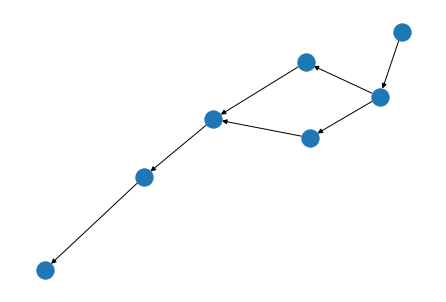

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0, 1, 2, 3, 4), (4,), (0, 4), (1, 4), (0, 1, 2, 4)]
The neg operation is: {(0, 1, 4): (0, 4), (0, 4): (), (): (0, 1, 4), (0, 1, 2, 4): (0, 1, 4), (1, 4): (0, 4), (4,): (), (0, 1, 2, 3, 4): (0, 1, 4)}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((4,), (0, 1, 2, 3, 4)), ((4,), (4,)), ((4,), (0, 4)), ((4,), (1, 4)), ((4,), (0, 1, 2, 4)), ((0, 4), (0, 1, 2, 3, 4)), ((0, 4), (0, 4)), ((0, 4), (0, 1, 2, 4)), ((1, 4), (0, 1, 2, 3, 4)), ((1, 4), (1, 4)), ((1, 4), (0, 1, 2, 4)), ((0, 1, 2, 4), (0, 1, 2, 3, 4)), ((0, 1, 2, 4), (0, 1, 2, 4))]


44
Original compatibility relation: [(0, 2), (0, 3), (4, 0), (1, 2), (3, 1), (4, 1), (3, 2), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (4,), (0, 4), (1, 4), (0, 3, 4), (0, 1, 3, 4)]


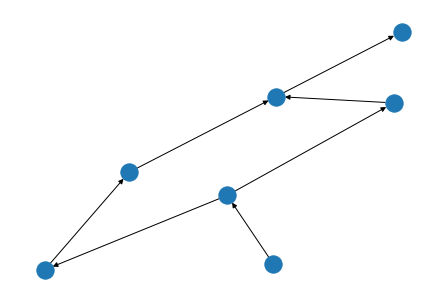

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0, 1, 2, 3, 4), (4,), (0, 4), (1, 4), (0, 3, 4)]
The neg operation is: {(0, 1, 3, 4): (0, 4), (0, 4): (1, 4), (0, 3, 4): (0, 4), (): (0, 1, 3, 4), (1, 4): (0, 4), (4,): (), (0, 1, 2, 3, 4): (0, 1, 3, 4)}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((4,), (0, 1, 2, 3, 4)), ((4,), (4,)), ((4,), (0, 4)), ((4,), (1, 4)), ((4,), (0, 3, 4)), ((0, 4), (0, 1, 2, 3, 4)), ((0, 4), (0, 4)), ((0, 4), (0, 3, 4)), ((1, 4), (0, 1, 2, 3, 4)), ((1, 4), (1, 4)), ((0, 3, 4), (0, 1, 2, 3, 4)), ((0, 3, 4), (1, 4)), ((0, 3, 4), (0, 3, 4))]


45
Original compatibility relation: [(0, 2), (0, 3), (4, 0), (2, 1), (3, 1), (4, 1), (2, 3), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (4,), (0, 4), (1, 4), (0, 2, 4), (0, 2, 3, 4)]


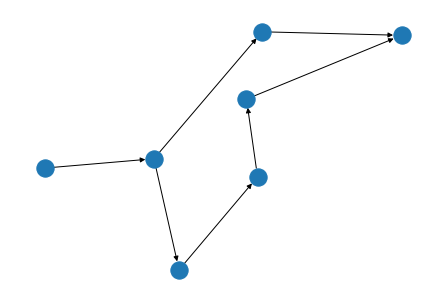

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(4,), (0, 4), (1, 4), (0, 2, 4), (0, 2, 3, 4)]
The neg operation is: {(0, 4): (1, 4), (0, 2, 4): (0, 4), (): (0, 4), (1, 4): (0, 4), (4,): (), (0, 2, 3, 4): (0, 4), (0, 1, 2, 3, 4): (0, 4)}
The compatibility relation from Definition 3.5(i) is: [((4,), (4,)), ((4,), (0, 4)), ((4,), (1, 4)), ((4,), (0, 2, 4)), ((4,), (0, 2, 3, 4)), ((0, 4), (0, 4)), ((0, 4), (0, 2, 4)), ((0, 4), (0, 2, 3, 4)), ((1, 4), (1, 4)), ((0, 2, 4), (1, 4)), ((0, 2, 4), (0, 2, 4)), ((0, 2, 4), (0, 2, 3, 4)), ((0, 2, 3, 4), (1, 4)), ((0, 2, 3, 4), (0, 2, 3, 4))]


46
Original compatibility relation: [(0, 2), (3, 0), (4, 0), (1, 2), (3, 1), (4, 1), (3, 2), (4, 2), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (3,), (3, 4), (0, 3, 4), (1, 3, 4), (0, 1, 3, 4)]


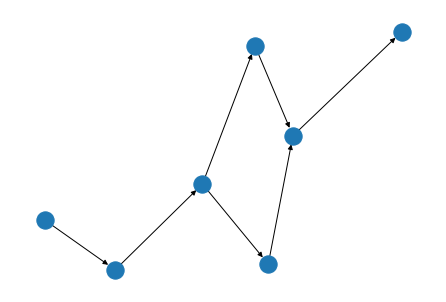

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0, 1, 2, 3, 4), (3,), (3, 4), (0, 3, 4), (1, 3, 4)]
The neg operation is: {(0, 1, 3, 4): (3, 4), (3, 4): (), (0, 3, 4): (3, 4), (): (0, 1, 3, 4), (1, 3, 4): (3, 4), (0, 1, 2, 3, 4): (0, 1, 3, 4), (3,): ()}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((3,), (0, 1, 2, 3, 4)), ((3,), (3,)), ((3,), (3, 4)), ((3,), (0, 3, 4)), ((3,), (1, 3, 4)), ((3, 4), (0, 1, 2, 3, 4)), ((3, 4), (3, 4)), ((3, 4), (0, 3, 4)), ((3, 4), (1, 3, 4)), ((0, 3, 4), (0, 1, 2, 3, 4)), ((0, 3, 4), (0, 3, 4)), ((1, 3, 4), (0, 1, 2, 3, 4)), ((1, 3, 4), (1, 3, 4))]


47
Original compatibility relation: [(0, 2), (3, 0), (4, 0), (2, 1), (3, 1), (4, 1), (3, 2), (4, 2), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (3,), (3, 4), (0, 3, 4), (1, 3, 4), (0, 2, 3, 4)]


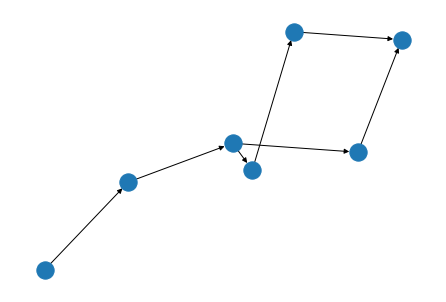

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(3,), (3, 4), (0, 3, 4), (1, 3, 4), (0, 2, 3, 4)]
The neg operation is: {(3, 4): (), (0, 3, 4): (1, 3, 4), (): (3, 4), (1, 3, 4): (3, 4), (0, 2, 3, 4): (3, 4), (0, 1, 2, 3, 4): (3, 4), (3,): ()}
The compatibility relation from Definition 3.5(i) is: [((3,), (3,)), ((3,), (3, 4)), ((3,), (0, 3, 4)), ((3,), (1, 3, 4)), ((3,), (0, 2, 3, 4)), ((3, 4), (3, 4)), ((3, 4), (0, 3, 4)), ((3, 4), (1, 3, 4)), ((3, 4), (0, 2, 3, 4)), ((0, 3, 4), (0, 3, 4)), ((0, 3, 4), (0, 2, 3, 4)), ((1, 3, 4), (1, 3, 4)), ((0, 2, 3, 4), (1, 3, 4)), ((0, 2, 3, 4), (0, 2, 3, 4))]


48
Original compatibility relation: [(2, 0), (3, 0), (4, 0), (2, 1), (3, 1), (4, 1), (2, 3), (2, 4), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (2,), (2, 3), (2, 3, 4), (0, 2, 3, 4), (1, 2, 3, 4)]


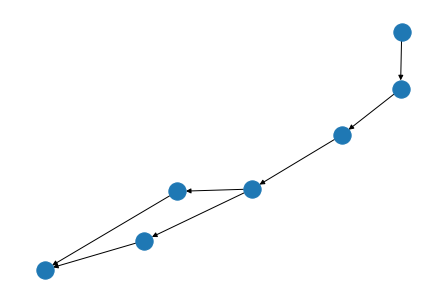

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(2,), (2, 3), (2, 3, 4), (0, 2, 3, 4), (1, 2, 3, 4)]
The neg operation is: {(2,): (), (): (2,), (2, 3): (2,), (0, 2, 3, 4): (2,), (1, 2, 3, 4): (2,), (2, 3, 4): (2,), (0, 1, 2, 3, 4): (2,)}
The compatibility relation from Definition 3.5(i) is: [((2,), (2,)), ((2,), (2, 3)), ((2,), (2, 3, 4)), ((2,), (0, 2, 3, 4)), ((2,), (1, 2, 3, 4)), ((2, 3), (2, 3)), ((2, 3), (2, 3, 4)), ((2, 3), (0, 2, 3, 4)), ((2, 3), (1, 2, 3, 4)), ((2, 3, 4), (2, 3, 4)), ((2, 3, 4), (0, 2, 3, 4)), ((2, 3, 4), (1, 2, 3, 4)), ((0, 2, 3, 4), (0, 2, 3, 4)), ((1, 2, 3, 4), (1, 2, 3, 4))]


49
Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (4, 0), (1, 2), (2, 1), (1, 3), (3, 1), (1, 4), (4, 1), (2, 3), (4, 2), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (1,), (2,), (3,), (4,)]


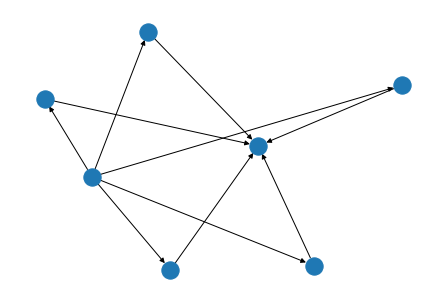

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0,), (1,), (2,), (3,), (4,)]
The neg operation is: {(2,): (4,), (): (2,), (4,): (2,), (1,): (0,), (0,): (3,), (0, 1, 2, 3, 4): (2,), (3,): (1,)}
The compatibility relation from Definition 3.5(i) is: [((0,), (0,)), ((0,), (1,)), ((0,), (2,)), ((0,), (4,)), ((1,), (1,)), ((1,), (2,)), ((1,), (3,)), ((1,), (4,)), ((2,), (0,)), ((2,), (1,)), ((2,), (2,)), ((2,), (3,)), ((3,), (0,)), ((3,), (2,)), ((3,), (3,)), ((3,), (4,)), ((4,), (0,)), ((4,), (1,)), ((4,), (3,)), ((4,), (4,))]


50
Original compatibility relation: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (4, 2), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (0, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4)]


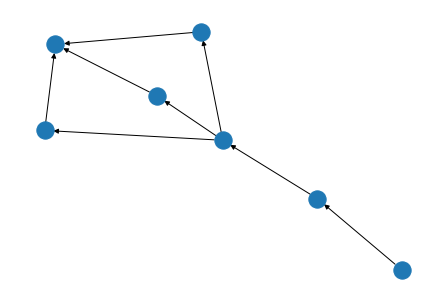

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0,), (0, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4)]
The neg operation is: {(0, 1): (), (0, 1, 4): (0, 1, 2), (0, 1, 2): (0, 1, 3), (0, 1, 3): (0, 1, 4), (): (0, 1), (0,): (), (0, 1, 2, 3, 4): (0, 1)}
The compatibility relation from Definition 3.5(i) is: [((0,), (0,)), ((0,), (0, 1)), ((0,), (0, 1, 2)), ((0,), (0, 1, 3)), ((0,), (0, 1, 4)), ((0, 1), (0, 1)), ((0, 1), (0, 1, 2)), ((0, 1), (0, 1, 3)), ((0, 1), (0, 1, 4)), ((0, 1, 2), (0, 1, 2)), ((0, 1, 2), (0, 1, 4)), ((0, 1, 3), (0, 1, 2)), ((0, 1, 3), (0, 1, 3)), ((0, 1, 4), (0, 1, 3)), ((0, 1, 4), (0, 1, 4))]


51
Original compatibility relation: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (4, 1), (2, 3), (2, 4), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (0, 1), (0, 2), (0, 4), (0, 1, 2, 4)]


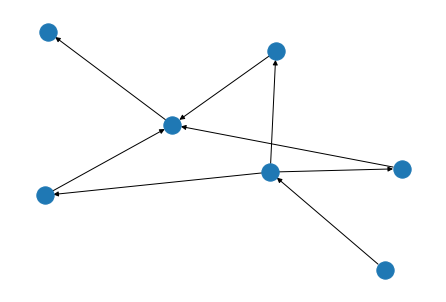

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0, 1, 2, 3, 4), (0,), (0, 1), (0, 2), (0, 4)]
The neg operation is: {(0, 1): (0, 4), (0, 4): (0, 2), (): (0, 1), (0, 1, 2, 4): (0, 1), (0, 2): (0, 1), (0,): (), (0, 1, 2, 3, 4): (0, 1)}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((0,), (0, 1, 2, 3, 4)), ((0,), (0,)), ((0,), (0, 1)), ((0,), (0, 2)), ((0,), (0, 4)), ((0, 1), (0, 1, 2, 3, 4)), ((0, 1), (0, 1)), ((0, 1), (0, 2)), ((0, 2), (0, 1, 2, 3, 4)), ((0, 2), (0, 2)), ((0, 2), (0, 4)), ((0, 4), (0, 1, 2, 3, 4)), ((0, 4), (0, 1)), ((0, 4), (0, 4))]


52
Original compatibility relation: [(0, 1), (0, 2), (0, 3), (4, 0), (1, 2), (1, 3), (1, 4), (2, 3), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (1,), (4,), (0, 1, 4), (0, 1, 2, 4)]


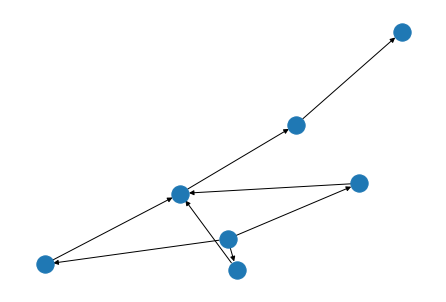

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0, 1, 2, 3, 4), (0,), (1,), (4,), (0, 1, 2, 4)]
The neg operation is: {(0, 1, 4): (), (): (0, 1, 4), (0, 1, 2, 4): (0, 1, 4), (4,): (1,), (1,): (0,), (0,): (4,), (0, 1, 2, 3, 4): (0, 1, 4)}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((0,), (0, 1, 2, 3, 4)), ((0,), (0,)), ((0,), (1,)), ((0,), (0, 1, 2, 4)), ((1,), (0, 1, 2, 3, 4)), ((1,), (1,)), ((1,), (4,)), ((1,), (0, 1, 2, 4)), ((4,), (0, 1, 2, 3, 4)), ((4,), (0,)), ((4,), (4,)), ((4,), (0, 1, 2, 4)), ((0, 1, 2, 4), (0, 1, 2, 3, 4)), ((0, 1, 2, 4), (0, 1, 2, 4))]


53
Original compatibility relation: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 2), (2, 3), (2, 4), (2, 5), (3, 3), (3, 4), (3, 5), (4, 4), (4, 5), (5, 5)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4, 5), (0,), (0, 1), (0, 1, 2), (0, 1, 2, 3), (0, 1, 2, 3, 4)]


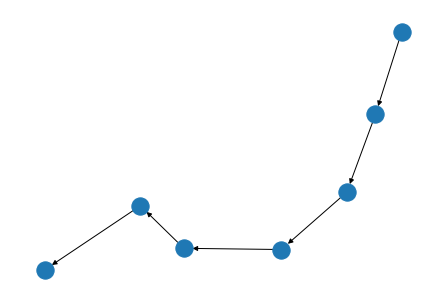

Can represent lattice via Def. 3.5(i) with the given neg and V.
The subset V is: [(0, 1, 2, 3, 4, 5), (0,), (0, 1), (0, 1, 2), (0, 1, 2, 3), (0, 1, 2, 3, 4)]
The neg operation is: {(): (0, 1, 2, 3, 4, 5), (0, 1, 2, 3, 4, 5): (), (0,): (), (0, 1): (), (0, 1, 2): (), (0, 1, 2, 3): (), (0, 1, 2, 3, 4): ()}
The compatibility relation from Definition 3.5(i) is: [((0, 1, 2, 3, 4, 5), (0, 1, 2, 3, 4, 5)), ((0,), (0, 1, 2, 3, 4, 5)), ((0,), (0,)), ((0,), (0, 1)), ((0,), (0, 1, 2)), ((0,), (0, 1, 2, 3)), ((0,), (0, 1, 2, 3, 4)), ((0, 1), (0, 1, 2, 3, 4, 5)), ((0, 1), (0, 1)), ((0, 1), (0, 1, 2)), ((0, 1), (0, 1, 2, 3)), ((0, 1), (0, 1, 2, 3, 4)), ((0, 1, 2), (0, 1, 2, 3, 4, 5)), ((0, 1, 2), (0, 1, 2)), ((0, 1, 2), (0, 1, 2, 3)), ((0, 1, 2), (0, 1, 2, 3, 4)), ((0, 1, 2, 3), (0, 1, 2, 3, 4, 5)), ((0, 1, 2, 3), (0, 1, 2, 3)), ((0, 1, 2, 3), (0, 1, 2, 3, 4)), ((0, 1, 2, 3, 4), (0, 1, 2, 3, 4, 5)), ((0, 1, 2, 3, 4), (0, 1, 2, 3, 4))]




In [90]:
for n in range(0,53):
    print(n+1)
    triple = rels_for_lats_size_7_with_neg_and_V[n]
    represent_lat_with_neg_V(triple[0], triple[1], triple[2])
    print("\n")

## II.VII Verification of Conjecture 3.13 for lattices up to size 14<a id='II.VII'></a>

In this section, we check the sufficient condition in Footnote 5 for a finite lattice to be representable by a smaller compatibility frame as in Conjecture 3.13. 

As our source of lattices, we use the catalogue generated by Gebhardt and Tawn:

Gebhardt, V. and S. Tawn (2020), "Constructing unlabelled lattices," *Journal of Algebra*, Vol. 545, pp. 213–236.

Their lattices of size $n\leq 12$ can be found in lattices/unlabelled-$n$.cats.txt. 

I ran the code below on lattices of size $13$ and $14$ as well, but the files for these lattices are too big for GitHub. They can be found at https://research-data.westernsydney.edu.au/published/ff5d9c10519311ecb15399911543e199/

To find the minimum edge covering for a bipartite graph, we use the min_edge_cover function in networkx, which is based on:

J. E. Hopcroft and R. M. Karp (1973), "An $n^{5/2}$ algorithm for maximum matchings in bipartite graphs," *SIAM J. Comput*, Vol. 2, No. 4, pp. 225-231.

## Lattices

In [91]:
def readlats(filename,n):
    """Read in lattices of size n represented by their covering relations 
    in the format of Gebhardt and Tawn"""
    
    file = open(filename)
    lines = file.readlines()
    lats = []

    for line in tqdm(lines):
        cover_rel = []
        l = list(line)

        for A in range(1,n+1):
            for B in range(1,n+1):
                if A<B:
                    if l[int((((B-1)*(B-2))/2)+A)-1] == '1':
                        cover_rel.append((A,B))
        
        lats.append(cover_rel)

    return lats

In [92]:
lats_size = {}

for n in range(2,13):
    lats_size[n] = readlats(f"lattices/lattices{n}.txt",n)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/5994 [00:00<?, ?it/s]

  0%|          | 0/37622 [00:00<?, ?it/s]

  0%|          | 0/262776 [00:00<?, ?it/s]

In [93]:
def graph_from_cover(cover, n):
    """Given a covering relation of a lattice of size n, 
    return a digraph where an arrow from y to x means that x covers y"""
    
    g = nx.DiGraph()
    g.add_nodes_from(range(1,n+1))
    
    for x in range(1,n+1):
        for y in range(1,n+1):
            if (x,y) in cover:
                g.add_edge(y,x)
    return g

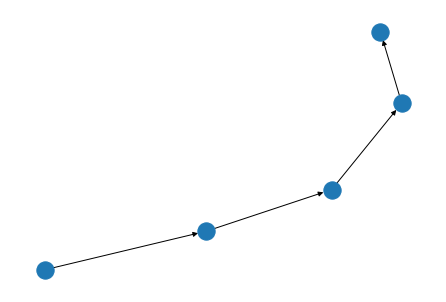

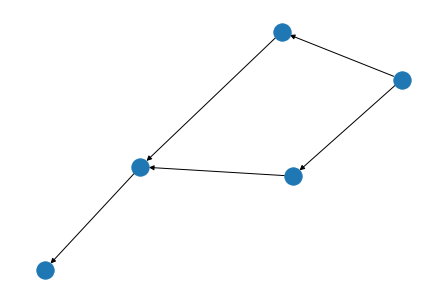

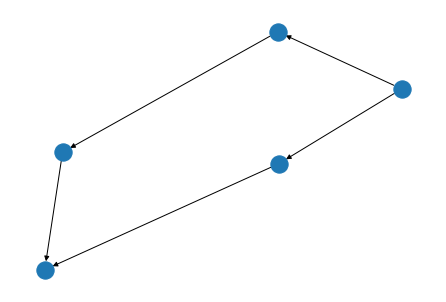

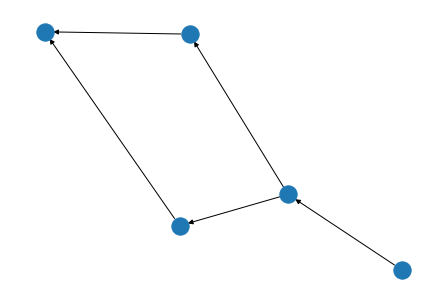

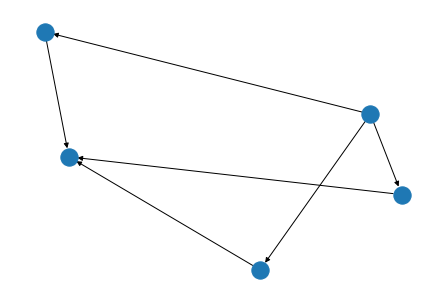

In [94]:
for lat in lats_size[5]:

    g = graph_from_cover(lat,5)

    nx.draw(g)
    plt.show()

In [95]:
def join_irreducibles(cover,n):
    """Given a covering relation of a lattice of size n, return the join-irreducibles"""
    
    ji = []
    for x in range(1,n+1):
        if len([y for y in range(1,n+1) if (x,y) in cover ])==1:
            ji.append(x)
            
    return ji

In [96]:
def meet_irreducibles(cover,n):
    """Given a covering relation of a lattice of size n, return the meet-irreducibles"""
    
    mi = []
    for x in range(1,n+1):
        if len([y for y in range(1,n+1) if (y,x) in cover ])==1:
            mi.append(x)
            
    return mi

In [97]:
join_irreducibles(lats_size[11][42],11)

[1, 2, 3, 4, 7, 8, 9, 10]

In [98]:
meet_irreducibles(lats_size[11][42],11)

[2, 3, 4, 5, 6, 7, 8, 9]

### The bipartite graph of irreducibles

In [99]:
from networkx import bipartite

In [100]:
def bipartite_of_irreducibles(cover,n):
    """Given the covering relation of a lattice of size n, return the bipartite graph of join- and meet-irreducibles
    as in Footnote 5"""
    
    mi = meet_irreducibles(cover,n)
    ji = join_irreducibles(cover,n)
    g = graph_from_cover(cover,n)
    
    gt = nx.transitive_closure(g,reflexive=True) 
    # We use gt to check that a given join-irreducible is not under a meet-irreducible in the lattice
    
    b = nx.Graph()
    b.add_nodes_from([(x,0) for x in mi],bipartite=0)
    b.add_nodes_from([(x,1) for x in ji],bipartite=1)
    
    for x in ji:
        for y in mi:
            if not (x,y) in gt.edges:
                b.add_edge((x,1),(y,0))
                
    return b

In [101]:
def display_bipartite(b):
    """Display the bipartite graph b using networkx's bipartite layout"""
    
    top_nodes = {n for n, d in b.nodes(data=True) if d["bipartite"] == 0}
    pos = nx.bipartite_layout(b,top_nodes)
    nx.draw(b, pos)
    plt.show()

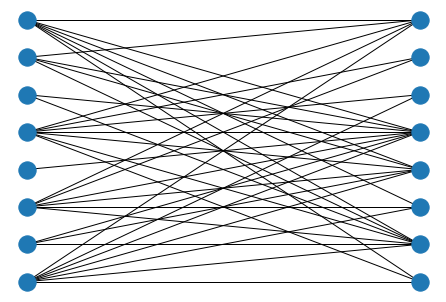

In [102]:
b = bipartite_of_irreducibles(lats_size[11][42],11)

display_bipartite(b)

### Minimum edge covering

In [103]:
bipartite_of_irreducibles(lats_size[5][0],5).edges

EdgeView([((2, 0), (1, 1)), ((3, 0), (1, 1)), ((3, 0), (2, 1)), ((4, 0), (1, 1)), ((4, 0), (2, 1)), ((4, 0), (3, 1)), ((5, 0), (1, 1)), ((5, 0), (2, 1)), ((5, 0), (3, 1)), ((5, 0), (4, 1))])

In [104]:
nx.min_edge_cover(bipartite_of_irreducibles(lats_size[5][0],5))

{((1, 1), (2, 0)), ((2, 1), (3, 0)), ((3, 1), (4, 0)), ((5, 0), (4, 1))}

The networkx min_edge_cover function sometimes outputs a redundant representation of a mininum edge covering containing both $(x,y)$ and $(y,x)$ to represent an undirected edge between $x$ and $y$, so we need the following.

In [105]:
def non_redundant(rel):
    """Turns rel into a non-redundant representation of an undirected graph"""
    newrel = []
    
    for pair in rel:
        if not pair in newrel and not (pair[1],pair[0]) in newrel:
            newrel.append(pair)
            
    return newrel
    

### Finding an edge covering smaller than the lattice

In [106]:
def smaller_min_edge_cover(lat,n):
    """Checks for a given lattice of size n whether the minimum edge cover for 
    its bipartite graph of join-irreducibles and meet-irreducibles
    is smaller than the lattice itself"""
    
    b = bipartite_of_irreducibles(lat,n)
    
    smaller = True
    
    if len(b.edges) >= n:
        if len(non_redundant(nx.min_edge_cover(b))) >= n:
            smaller = False
            
    return smaller

In [135]:
for n in range(2,13):
    
    # n=12 takes about 10 minutes
    # n=13 takes about an hour
    # n=14 takes 8 hours

    verified = True

    for lat in tqdm(lats_size[n]):
        b = bipartite_of_irreducibles(lat,n)
        if not smaller_min_edge_cover(lat,n): 
                print("Minimum edge cover not smaller than lattice.")
                print(lat)
                verified = False
                break

    if verified == True:
        print(f"Conjecture 3.13 verified for lattices of size {n}.")

  0%|          | 0/1 [00:00<?, ?it/s]

Conjecture 3.13 verified for lattices of size 2.


  0%|          | 0/1 [00:00<?, ?it/s]

Conjecture 3.13 verified for lattices of size 3.


  0%|          | 0/2 [00:00<?, ?it/s]

Conjecture 3.13 verified for lattices of size 4.


  0%|          | 0/5 [00:00<?, ?it/s]

Conjecture 3.13 verified for lattices of size 5.


  0%|          | 0/15 [00:00<?, ?it/s]

Conjecture 3.13 verified for lattices of size 6.


  0%|          | 0/53 [00:00<?, ?it/s]

Conjecture 3.13 verified for lattices of size 7.


  0%|          | 0/222 [00:00<?, ?it/s]

Conjecture 3.13 verified for lattices of size 8.


  0%|          | 0/1078 [00:00<?, ?it/s]

Conjecture 3.13 verified for lattices of size 9.


  0%|          | 0/5994 [00:00<?, ?it/s]

Conjecture 3.13 verified for lattices of size 10.


  0%|          | 0/37622 [00:00<?, ?it/s]

Conjecture 3.13 verified for lattices of size 11.


  0%|          | 0/262776 [00:00<?, ?it/s]

Conjecture 3.13 verified for lattices of size 12.


As noted above, I ran the code for $n=13$ and $n=14$ and verified Conjecture 3.13 for lattices up to size $14$.

# III. Supplement to Appendix A.1 <a id='III'></a>

## III.I Generating protocomplementations <a id='III.I'></a>

In this section, we take a lattice arising from a compatibility frame and expand it with all possible protocomplementations as in Definition 2.14 in the paper, not just the protocomplementation arising from the compatibility frame.

In [136]:
def antitonesemi(f,dom):
    """checks whether a function on dom is an antitone semicomplementation (see Def. 2.14)
    wrt set inclusion and intersection"""
    
    for A in dom:
        Aset = set(A)
        fAset = set(f(A))
        if not Aset.intersection(fAset) == set(): # make sure f is a semicomplementation wrt intersection
            return False
        
        for B in dom:
            Bset = set(B)
            fBset = set(f(B))         
            if Aset.issubset(Bset) and not fBset.issubset(fAset): # make sure f is antitone wrt inclusion
                return False
            
    return True

In [137]:
def expand_with_protocomps(lt, X):
    """given a list of tuples representing a bounded meet-semilattice L of subsets of X
    return all nonisomorphic expansions of L with a protocomplementation"""
    
    ltset = set(lt)
    
    cover = covering(propsubrel(lt))
    
    lat_exps_of_lt = []
    Xtuple = tuple(X)
    
    for f in f_generator(ltset,ltset):
        if f(()) == Xtuple: # make sure $f(0) = 1$ as required for a protocomplementation
            if antitonesemi(f,ltset):
                newlat = True
            
                l = nx.MultiDiGraph()
                l.add_nodes_from(lt)
                l.add_edges_from(cover, weight=0)
            
                for A in ltset:
                    l.add_edge(A,f(A), weight=1)
            
                for l2 in lat_exps_of_lt:
                    if nx.is_isomorphic(l,l2):
                        newlat = False
                        break
                if newlat:
                    lat_exps_of_lt.append(l)
            
    return lat_exps_of_lt

In [138]:
def expand_all_with_protocomps(lts,X):
    
    lat_exps_of_lts = []
    for lt in lts:
        lat_exps = expand_with_protocomps(lt, X)
        lat_exps_of_lts = lat_exps_of_lts + lat_exps
    
    return lat_exps_of_lts

In [139]:
def protocomps(lt, X):
    """given a list of tuples representing a bounded meet-semilattice L of subsets of X
    returns all protocomplementations up to isomorphism of the expansion of L"""
    
    ltset = set(lt)
    
    cover = covering(propsubrel(lt))
    
    lat_exps_of_lt = []
    fs = []
    Xtuple = tuple(X)
    
    for f in f_generator(ltset,ltset):
        if f(()) == Xtuple: # make sure $f(0) = 1$ as required for a protocomplementation
            if antitonesemi(f,ltset):
                newlat = True
            
                l = nx.MultiDiGraph()
                l.add_nodes_from(lt)
                l.add_edges_from(cover, weight=0)
            
                for A in ltset:
                    l.add_edge(A,f(A), weight=1)
            
                for l2 in lat_exps_of_lt:
                    if nx.is_isomorphic(l,l2):
                        newlat = False

                if newlat:
                    lat_exps_of_lt.append(l)
                    f_dict = {A: f(A) for A in ltset}
                    fs.append(f_dict)
                    
    return fs

In [140]:
# An example

rel = reflexive_closure([(1,0),(2,1)],range(3))

for d in protocomps(fixpoints(rel),range(3)):
    print(d)

{(1, 2): (0,), (2,): (0,), (0,): (1, 2), (0, 1, 2): (), (): (0, 1, 2)}
{(1, 2): (0,), (2,): (0,), (0,): (2,), (0, 1, 2): (), (): (0, 1, 2)}
{(1, 2): (0,), (2,): (0,), (0,): (), (0, 1, 2): (), (): (0, 1, 2)}
{(1, 2): (), (2,): (0,), (0,): (1, 2), (0, 1, 2): (), (): (0, 1, 2)}
{(1, 2): (), (2,): (0,), (0,): (2,), (0, 1, 2): (), (): (0, 1, 2)}
{(1, 2): (), (2,): (0,), (0,): (), (0, 1, 2): (), (): (0, 1, 2)}
{(1, 2): (), (2,): (), (0,): (1, 2), (0, 1, 2): (), (): (0, 1, 2)}
{(1, 2): (), (2,): (), (0,): (2,), (0, 1, 2): (), (): (0, 1, 2)}
{(1, 2): (), (2,): (), (0,): (), (0, 1, 2): (), (): (0, 1, 2)}


In [141]:
rel = [(0, 2), (2, 0), (0, 3), (4, 0), (2, 1), (1, 3), (3, 1), (4, 1), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
# The fixpoint lattice of this rel admits only one protocomplementation

print(protocomps(fixpoints(rel),range(5)))

[{(3, 4): (), (0, 2, 4): (), (): (0, 1, 2, 3, 4), (1, 4): (), (4,): (), (0, 1, 2, 3, 4): ()}]


## III.II Lattices for which no protocomplementation makes the representation of Def. 3.5(i) apply <a id='III.IV'></a>

So far, for every finite lattice $L$ we have tested, we have found an anti-inflationry operation $\neg$ and set $\mathrm{V}$ of nonzero elements such that $L$ is isomorphic to $\mathfrak{L}(\mathrm{V},\vartriangleleft^\neg_\mathrm{V})$. However, we will now see that we cannot always do this with a protocomplementation $\neg$.


In [142]:
def represent_lat_using_proto(rel):
    """checks whether the fixpoint lattice of rel is representable as in Section 3.1
    when neg is a protocomplementation"""

    fixpts = fixpoints(rel)
    print(f"Original compatibility relation: {rel}")
    print(f"Lattice of fixpoints: {fixpts}")
    l1 = lattice(rel)
    nx.draw(l1)
    plt.show()
    
    k = len(domain(rel))
    can_rep = False
    ji = join_irrs(rel)
    
    for f in protocomps(fixpts,range(k)):
        comp = compat(rel,f,ji)
        l2 = lattice(comp)
        if nx.is_isomorphic(l1,l2):
            can_rep = True
            print("Can find a protocomplementation and V to represent lattice via Def. 3.5(i).")
            print(f"V is the set of join-irreducibles: {ji}")
            print(f"The protocomplementation is: {f}")
            print(f"The compatibility relation from Def. 3.5(i) is: {comp}")
            print("\n")
            break
    
    if can_rep == False:
        for V in powerset(fixpts):
            if () not in V:
                for f in protocomps(fixpts,range(k)):
                    comp = compat(rel,f,V,domain(rel))
                    l2 = lattice(comp)
                    if nx.is_isomorphic(l1,l2):
                        can_rep = True
                        print("Can find a protocomplementation and V to represent lattice via Def. 3.5.1.")
                        print(f"The subset V is: {V}")
                        print(f"The protocomplementation is: {f}")
                        print(f"The compatibility relation from Def. 3.5(i) is: {comp}")
                        print("\n")
                        break
            if can_rep == True:
                break
        
    if can_rep == False:
        print("Can't find a protocomplementation and V to represent lattice via Def. 3.5(i).")
        print("\n")

Original compatibility relation: [(0, 2), (1, 2), (0, 0), (1, 1), (2, 2)]
Lattice of fixpoints: [(), (0, 1, 2), (0,), (1,), (0, 1)]


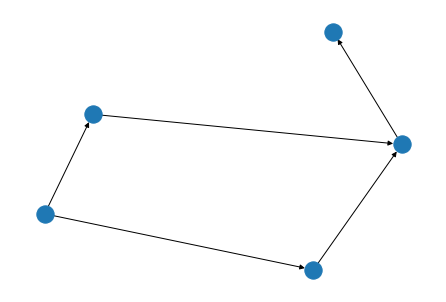

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1, 2), (0,), (1,)]
The protocomplementation is: {(0, 1): (), (0,): (1,), (1,): (0,), (0, 1, 2): (), (): (0, 1, 2)}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2), (0, 1, 2)), ((0,), (0, 1, 2)), ((0,), (0,)), ((1,), (0, 1, 2)), ((1,), (1,))]


Original compatibility relation: [(0, 2), (2, 1), (0, 0), (1, 1), (2, 2)]
Lattice of fixpoints: [(), (0, 1, 2), (0,), (1,), (0, 2)]


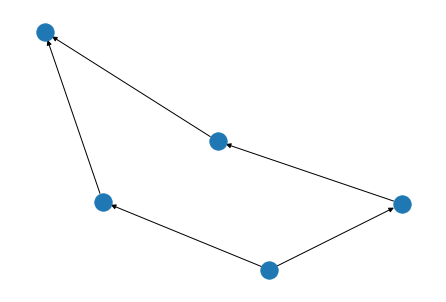

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0,), (1,), (0, 2)]
The protocomplementation is: {(0,): (1,), (1,): (0, 2), (0, 2): (), (0, 1, 2): (), (): (0, 1, 2)}
The compatibility relation from Def. 3.5(i) is: [((0,), (0,)), ((0,), (0, 2)), ((1,), (1,)), ((0, 2), (1,)), ((0, 2), (0, 2))]


Original compatibility relation: [(2, 0), (2, 1), (0, 0), (1, 1), (2, 2)]
Lattice of fixpoints: [(), (0, 1, 2), (2,), (0, 2), (1, 2)]


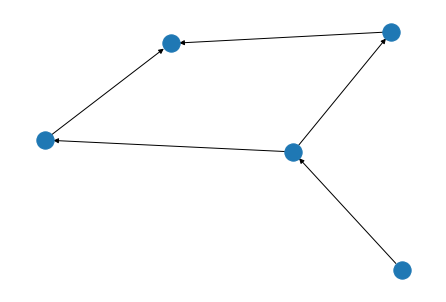

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(2,), (0, 2), (1, 2)]
The protocomplementation is: {(1, 2): (), (2,): (), (0, 2): (), (0, 1, 2): (), (): (0, 1, 2)}
The compatibility relation from Def. 3.5(i) is: [((2,), (2,)), ((2,), (0, 2)), ((2,), (1, 2)), ((0, 2), (0, 2)), ((1, 2), (1, 2))]


Original compatibility relation: [(0, 1), (2, 0), (1, 2), (0, 0), (1, 1), (2, 2)]
Lattice of fixpoints: [(), (0, 1, 2), (0,), (1,), (2,)]


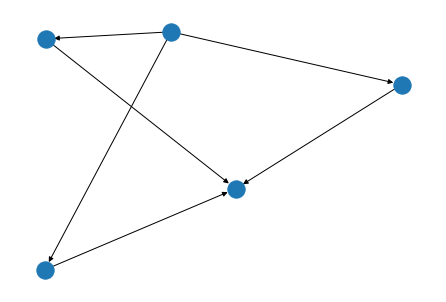

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0,), (1,), (2,)]
The protocomplementation is: {(2,): (0,), (0,): (1,), (1,): (2,), (0, 1, 2): (), (): (0, 1, 2)}
The compatibility relation from Def. 3.5(i) is: [((0,), (0,)), ((0,), (2,)), ((1,), (0,)), ((1,), (1,)), ((2,), (1,)), ((2,), (2,))]


Original compatibility relation: [(0, 0), (0, 1), (0, 2), (0, 3), (1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (0, 1), (0, 1, 2)]


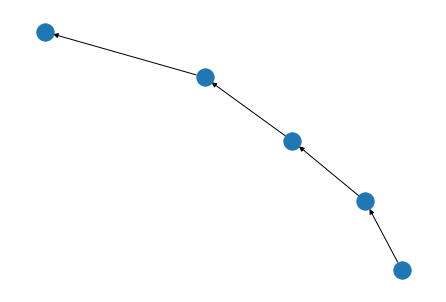

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1, 2, 3), (0,), (0, 1), (0, 1, 2)]
The protocomplementation is: {(0, 1): (), (0, 1, 2): (), (0, 1, 2, 3): (), (0,): (), (): (0, 1, 2, 3)}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2, 3), (0, 1, 2, 3)), ((0,), (0, 1, 2, 3)), ((0,), (0,)), ((0,), (0, 1)), ((0,), (0, 1, 2)), ((0, 1), (0, 1, 2, 3)), ((0, 1), (0, 1)), ((0, 1), (0, 1, 2)), ((0, 1, 2), (0, 1, 2, 3)), ((0, 1, 2), (0, 1, 2))]


Original compatibility relation: [(0, 2), (2, 0), (1, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (1,), (0, 2), (1, 3), (0, 1, 2)]


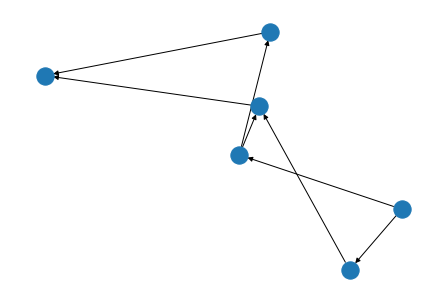

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(1,), (0, 2), (1, 3)]
The protocomplementation is: {(1,): (0, 2), (0, 2): (1,), (0, 1, 2, 3): (), (0, 1, 2): (), (): (0, 1, 2, 3), (1, 3): (0, 2)}
The compatibility relation from Def. 3.5(i) is: [((1,), (1,)), ((1,), (1, 3)), ((0, 2), (0, 2)), ((1, 3), (1, 3))]


Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (1, 3), (3, 1), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (1,), (2,), (0, 2), (1, 3)]


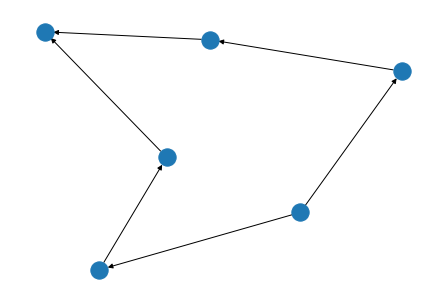

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(1,), (2,), (0, 2), (1, 3)]
The protocomplementation is: {(2,): (1, 3), (1,): (0, 2), (0, 2): (1,), (0, 1, 2, 3): (), (): (0, 1, 2, 3), (1, 3): (2,)}
The compatibility relation from Def. 3.5(i) is: [((1,), (1,)), ((1,), (1, 3)), ((2,), (2,)), ((2,), (0, 2)), ((0, 2), (2,)), ((0, 2), (0, 2)), ((0, 2), (1, 3)), ((1, 3), (1,)), ((1, 3), (0, 2)), ((1, 3), (1, 3))]


Original compatibility relation: [(0, 2), (2, 0), (0, 3), (2, 1), (1, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (1,), (3,), (0, 2), (0, 1, 2)]


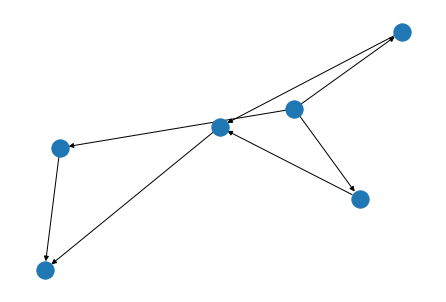

Can't find a protocomplementation and V to represent lattice via Def. 3.5(i).


Original compatibility relation: [(0, 2), (2, 0), (3, 0), (1, 2), (1, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (1, 2), (1, 3)]


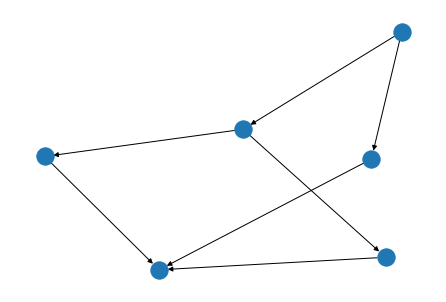

Can't find a protocomplementation and V to represent lattice via Def. 3.5(i).


Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (1, 2), (2, 1), (1, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (3,), (1, 2)]


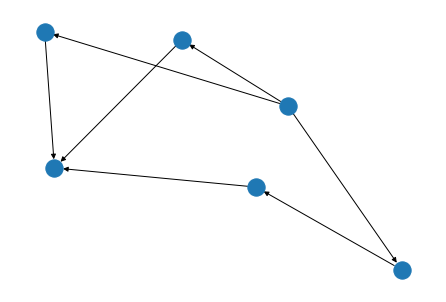

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0,), (1,), (3,), (1, 2)]
The protocomplementation is: {(1, 2): (), (1,): (0,), (0, 1, 2, 3): (), (0,): (3,), (): (0, 1, 2, 3), (3,): (1, 2)}
The compatibility relation from Def. 3.5(i) is: [((0,), (0,)), ((0,), (1,)), ((0,), (1, 2)), ((1,), (1,)), ((1,), (3,)), ((1,), (1, 2)), ((3,), (0,)), ((3,), (3,)), ((1, 2), (0,)), ((1, 2), (3,)), ((1, 2), (1, 2))]


Original compatibility relation: [(0, 2), (2, 0), (0, 3), (3, 0), (1, 2), (2, 1), (1, 3), (3, 1), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (2,), (3,)]


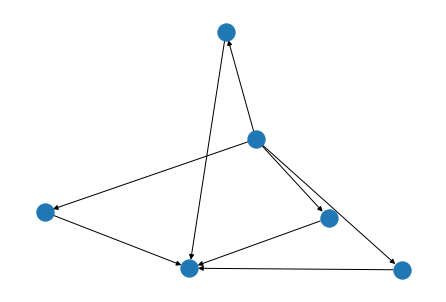

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0,), (1,), (2,), (3,)]
The protocomplementation is: {(2,): (1,), (1,): (2,), (0, 1, 2, 3): (), (0,): (3,), (): (0, 1, 2, 3), (3,): (0,)}
The compatibility relation from Def. 3.5(i) is: [((0,), (0,)), ((0,), (1,)), ((0,), (2,)), ((1,), (0,)), ((1,), (1,)), ((1,), (3,)), ((2,), (0,)), ((2,), (2,)), ((2,), (3,)), ((3,), (1,)), ((3,), (2,)), ((3,), (3,))]


Original compatibility relation: [(0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (0, 1), (0, 1, 2)]


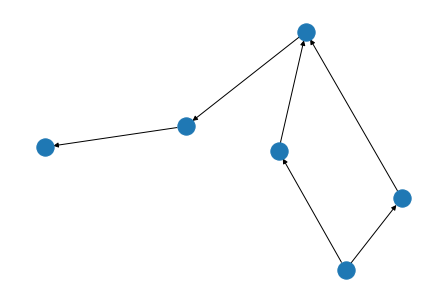

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1, 2, 3), (0,), (1,), (0, 1, 2)]
The protocomplementation is: {(0, 1): (), (0, 1, 2): (), (1,): (0,), (0, 1, 2, 3): (), (0,): (1,), (): (0, 1, 2, 3)}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2, 3), (0, 1, 2, 3)), ((0,), (0, 1, 2, 3)), ((0,), (0,)), ((0,), (0, 1, 2)), ((1,), (0, 1, 2, 3)), ((1,), (1,)), ((1,), (0, 1, 2)), ((0, 1, 2), (0, 1, 2, 3)), ((0, 1, 2), (0, 1, 2))]


Original compatibility relation: [(0, 2), (0, 3), (1, 2), (3, 1), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (0, 3), (0, 1, 3)]


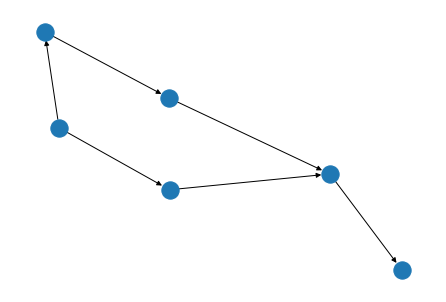

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1, 2, 3), (0,), (1,), (0, 3)]
The protocomplementation is: {(0, 1, 3): (), (0, 3): (), (1,): (0, 3), (0, 1, 2, 3): (), (0,): (1,), (): (0, 1, 2, 3)}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2, 3), (0, 1, 2, 3)), ((0,), (0, 1, 2, 3)), ((0,), (0,)), ((0,), (0, 3)), ((1,), (0, 1, 2, 3)), ((1,), (1,)), ((0, 3), (0, 1, 2, 3)), ((0, 3), (1,)), ((0, 3), (0, 3))]


Original compatibility relation: [(0, 2), (0, 3), (2, 1), (3, 1), (2, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (0, 2), (0, 2, 3)]


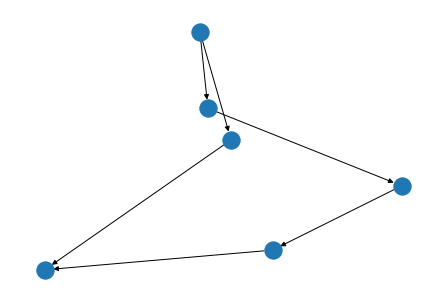

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0,), (1,), (0, 2), (0, 2, 3)]
The protocomplementation is: {(0, 2, 3): (), (1,): (0, 2, 3), (0, 2): (), (0, 1, 2, 3): (), (0,): (1,), (): (0, 1, 2, 3)}
The compatibility relation from Def. 3.5(i) is: [((0,), (0,)), ((0,), (0, 2)), ((0,), (0, 2, 3)), ((1,), (1,)), ((0, 2), (1,)), ((0, 2), (0, 2)), ((0, 2), (0, 2, 3)), ((0, 2, 3), (1,)), ((0, 2, 3), (0, 2, 3))]


Original compatibility relation: [(0, 2), (3, 0), (1, 2), (3, 1), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (3,), (0, 3), (1, 3), (0, 1, 3)]


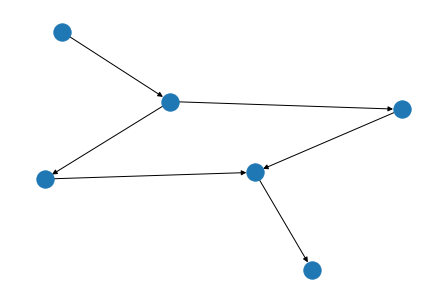

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1, 2, 3), (3,), (0, 3), (1, 3)]
The protocomplementation is: {(0, 1, 3): (), (0, 3): (), (0, 1, 2, 3): (), (3,): (), (): (0, 1, 2, 3), (1, 3): ()}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2, 3), (0, 1, 2, 3)), ((3,), (0, 1, 2, 3)), ((3,), (3,)), ((3,), (0, 3)), ((3,), (1, 3)), ((0, 3), (0, 1, 2, 3)), ((0, 3), (0, 3)), ((1, 3), (0, 1, 2, 3)), ((1, 3), (1, 3))]


Original compatibility relation: [(0, 2), (3, 0), (2, 1), (3, 1), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (3,), (0, 3), (1, 3), (0, 2, 3)]


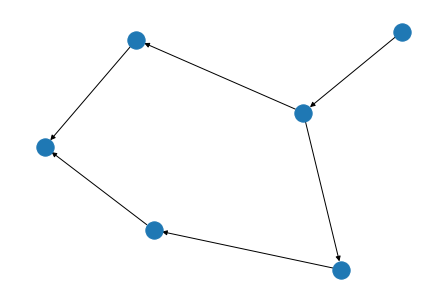

Can't find a protocomplementation and V to represent lattice via Def. 3.5(i).


Original compatibility relation: [(2, 0), (3, 0), (2, 1), (3, 1), (2, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (2,), (2, 3), (0, 2, 3), (1, 2, 3)]


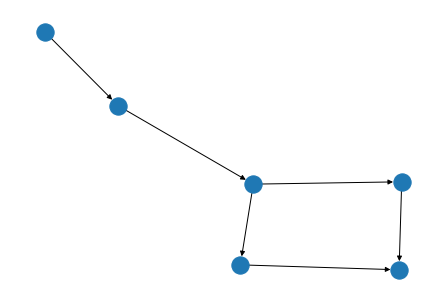

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(2,), (2, 3), (0, 2, 3), (1, 2, 3)]
The protocomplementation is: {(2,): (), (1, 2, 3): (), (0, 2, 3): (), (2, 3): (), (0, 1, 2, 3): (), (): (0, 1, 2, 3)}
The compatibility relation from Def. 3.5(i) is: [((2,), (2,)), ((2,), (2, 3)), ((2,), (0, 2, 3)), ((2,), (1, 2, 3)), ((2, 3), (2, 3)), ((2, 3), (0, 2, 3)), ((2, 3), (1, 2, 3)), ((0, 2, 3), (0, 2, 3)), ((1, 2, 3), (1, 2, 3))]


Original compatibility relation: [(0, 1), (0, 2), (0, 3), (1, 2), (3, 1), (2, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (0, 1), (0, 2), (0, 3)]


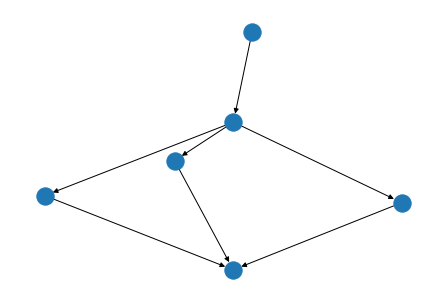

Can't find a protocomplementation and V to represent lattice via Def. 3.5(i).


Original compatibility relation: [(0, 1), (0, 2), (3, 0), (1, 2), (1, 3), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
Lattice of fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (3,), (0, 1, 3)]


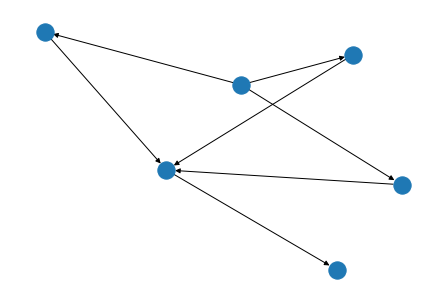

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1, 2, 3), (0,), (1,), (3,)]
The protocomplementation is: {(0, 1, 3): (), (1,): (0,), (0, 1, 2, 3): (), (0,): (3,), (): (0, 1, 2, 3), (3,): (1,)}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2, 3), (0, 1, 2, 3)), ((0,), (0, 1, 2, 3)), ((0,), (0,)), ((0,), (1,)), ((1,), (0, 1, 2, 3)), ((1,), (1,)), ((1,), (3,)), ((3,), (0, 1, 2, 3)), ((3,), (0,)), ((3,), (3,))]


Original compatibility relation: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 1), (1, 2), (1, 3), (1, 4), (2, 2), (2, 3), (2, 4), (3, 3), (3, 4), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (0,), (0, 1), (0, 1, 2), (0, 1, 2, 3)]


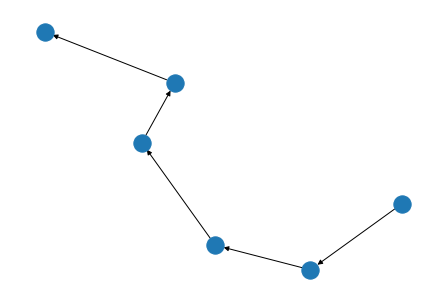

Can find a protocomplementation and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(0, 1, 2, 3, 4), (0,), (0, 1), (0, 1, 2), (0, 1, 2, 3)]
The protocomplementation is: {(0, 1): (), (0, 1, 2): (), (): (0, 1, 2, 3, 4), (0, 1, 2, 3): (), (0,): (), (0, 1, 2, 3, 4): ()}
The compatibility relation from Def. 3.5(i) is: [((0, 1, 2, 3, 4), (0, 1, 2, 3, 4)), ((0,), (0, 1, 2, 3, 4)), ((0,), (0,)), ((0,), (0, 1)), ((0,), (0, 1, 2)), ((0,), (0, 1, 2, 3)), ((0, 1), (0, 1, 2, 3, 4)), ((0, 1), (0, 1)), ((0, 1), (0, 1, 2)), ((0, 1), (0, 1, 2, 3)), ((0, 1, 2), (0, 1, 2, 3, 4)), ((0, 1, 2), (0, 1, 2)), ((0, 1, 2), (0, 1, 2, 3)), ((0, 1, 2, 3), (0, 1, 2, 3, 4)), ((0, 1, 2, 3), (0, 1, 2, 3))]




In [143]:
for n in range(5,7):
    for rel in comp_frames_for_lats_size[n]:
        represent_lat_using_proto(rel)

### Example

[{(3, 4): (), (0, 2, 4): (), (): (0, 1, 2, 3, 4), (1, 4): (), (4,): (), (0, 1, 2, 3, 4): ()}]


Original compatibility relation: [(0, 2), (2, 0), (0, 3), (4, 0), (2, 1), (1, 3), (3, 1), (4, 1), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (4,), (1, 4), (3, 4), (0, 2, 4)]


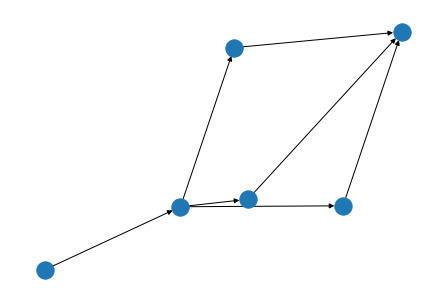

Can't find a protocomplementation and V to represent lattice via Def. 3.5(i).


Original compatibility relation: [(0, 2), (2, 0), (0, 3), (4, 0), (2, 1), (1, 3), (3, 1), (4, 1), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
Lattice of fixpoints: [(), (0, 1, 2, 3, 4), (4,), (1, 4), (3, 4), (0, 2, 4)]


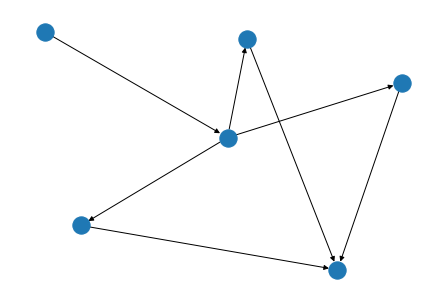

Can find a neg and V to represent lattice via Def. 3.5(i).
V is the set of join-irreducibles: [(4,), (1, 4), (3, 4), (0, 2, 4)]
The neg operation is: {(1, 4): (3, 4), (0, 2, 4): (1, 4), (3, 4): (0, 2, 4), (4,): ()}
The compatibility relation from Def. 3.5(i) is: [((4,), (4,)), ((4,), (1, 4)), ((4,), (3, 4)), ((4,), (0, 2, 4)), ((1, 4), (1, 4)), ((1, 4), (0, 2, 4)), ((3, 4), (1, 4)), ((3, 4), (3, 4)), ((0, 2, 4), (3, 4)), ((0, 2, 4), (0, 2, 4))]




In [144]:
rel = [(0, 2), (2, 0), (0, 3), (4, 0), (2, 1), (1, 3), (3, 1), (4, 1), (4, 2), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
# The fixpoint lattice L of this rel admits only one protocomplementation, 
# which sends every nonzero element to zero. 
print(protocomps(fixpoints(rel),range(5)))
print("\n")

represent_lat_using_proto(rel)
# We cannot represent L as in Def. 3.5(i) by taking neg to be the one protocomplementation.

represent_lat(rel)
# But we can represent L as in Def. 3.5(i) by taking neg to be another anti-inflationary operation.

## III.III Checking whether $(L,\neg)$ can arise from a compatibiltiy frame <a id='III.II'></a>

So far, we have concentrated on the representation of lattices. Appenix A.1 concerns the representation of lattice expansions $(L,\neg)$. That is, given a lattice $L$ and protocomplementation $\neg$ on $L$, we seek a compatibility frame $(X,\vartriangleleft)$ such that $(L,\neg)$ is isomorphic to $(\mathfrak{L}(X,\vartriangleleft),\neg_\vartriangleleft)$.

In [145]:
def search_for_iso(targets,realized):
    """checks whether each lattice expansion in targets is isomorphic to some lattice expansion in realized"""
    count = -1
    for l in targets:
        count += 1
        i = len(l.nodes)
        canrealize = False
        for l2 in realized:
            if nx.is_isomorphic(l,l2):
                    canrealize = True
                    print(f"Can realize this lattice expansion (#{count}) of size {i}.")
                    break
        if canrealize == False:
                print(f"Can't realize this lattice expansion (#{count}) of size {i}:")
                coveredges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==0]
                negedges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==1]
                print(f"Covering relation: {coveredges}")
                print(f"Neg operation: {negedges}")
                display_lattice_with_neg(l)

In [146]:
def search_for_iso_keep_rels(targets,realized):
    """same as above but saves the relation that represents the target lattice expansion"""
    count = -1
    rel_realizers = {}
    for l in targets:
        count += 1
        i = len(l.nodes)
        canrealize = False
        for pair in realized:
            l2 = pair[1]
            if nx.is_isomorphic(l,l2):
                    canrealize = True
                    print(f"Can realize this lattice expansion (#{count}) of size {i}.")
                    rel_realizers[l] = pair[0]
                    break
        
        if canrealize == False:
                print(f"Can't realize this lattice expansion (#{count}) of size {i}:")
                coveredges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==0]
                negedges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==1]
                print(f"Covering relation: {coveredges}")
                print(f"Neg operation: {negedges}")
                display_lattice_with_neg(l)
                
    return rel_realizers

### Example with an expansion of $\mathbf{M}_3$

For example, below we generate every expansion up to isomorphism of the $\mathbf{M}_3$ lattice with a protocomplementation. Recall that $\mathbf{M}_3$ arises as the lattice of fixpoints of a cycle on 3 elements.

Covering relation: [((), (0,)), ((), (1,)), ((), (2,)), ((0,), (0, 1, 2)), ((1,), (0, 1, 2)), ((2,), (0, 1, 2))]
Neg operation: [((), (0, 1, 2)), ((0, 1, 2), ()), ((0,), (2,)), ((1,), (2,)), ((2,), (0,))]


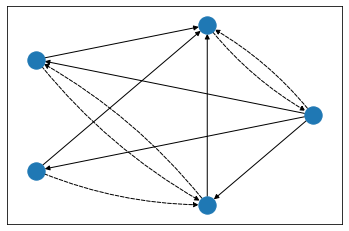

Covering relation: [((), (0,)), ((), (1,)), ((), (2,)), ((0,), (0, 1, 2)), ((1,), (0, 1, 2)), ((2,), (0, 1, 2))]
Neg operation: [((), (0, 1, 2)), ((0, 1, 2), ()), ((0,), (2,)), ((1,), ()), ((2,), (0,))]


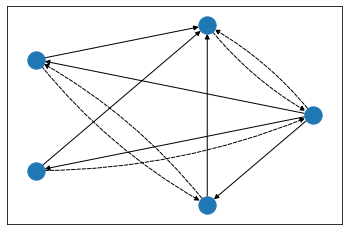

Covering relation: [((), (0,)), ((), (1,)), ((), (2,)), ((0,), (0, 1, 2)), ((1,), (0, 1, 2)), ((2,), (0, 1, 2))]
Neg operation: [((), (0, 1, 2)), ((0, 1, 2), ()), ((0,), (1,)), ((1,), (2,)), ((2,), (0,))]


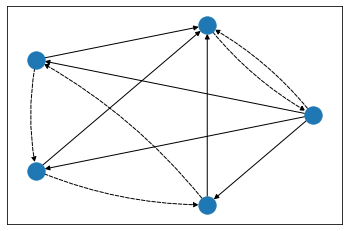

Covering relation: [((), (0,)), ((), (1,)), ((), (2,)), ((0,), (0, 1, 2)), ((1,), (0, 1, 2)), ((2,), (0, 1, 2))]
Neg operation: [((), (0, 1, 2)), ((0, 1, 2), ()), ((0,), (1,)), ((1,), ()), ((2,), (0,))]


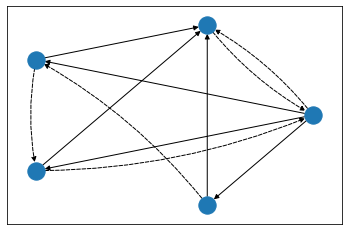

Covering relation: [((), (0,)), ((), (1,)), ((), (2,)), ((0,), (0, 1, 2)), ((1,), (0, 1, 2)), ((2,), (0, 1, 2))]
Neg operation: [((), (0, 1, 2)), ((0, 1, 2), ()), ((0,), ()), ((1,), (0,)), ((2,), (0,))]


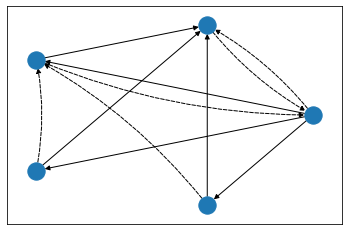

Covering relation: [((), (0,)), ((), (1,)), ((), (2,)), ((0,), (0, 1, 2)), ((1,), (0, 1, 2)), ((2,), (0, 1, 2))]
Neg operation: [((), (0, 1, 2)), ((0, 1, 2), ()), ((0,), ()), ((1,), ()), ((2,), (0,))]


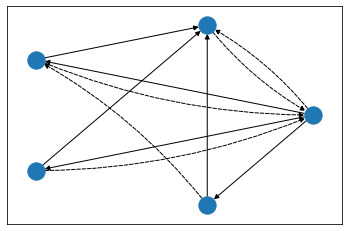

Covering relation: [((), (0,)), ((), (1,)), ((), (2,)), ((0,), (0, 1, 2)), ((1,), (0, 1, 2)), ((2,), (0, 1, 2))]
Neg operation: [((), (0, 1, 2)), ((0, 1, 2), ()), ((0,), ()), ((1,), ()), ((2,), ())]


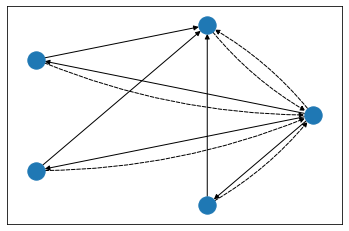

In [147]:
M3_expansions = expand_with_protocomps(fixpoints(reflexive_closure([(0,1),(1,2),(2,0)],range(3))),range(3))

for l in M3_expansions:
    
    coveredges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==0]
    negedges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==1]
    print(f"Covering relation: {coveredges}")
    print(f"Neg operation: {negedges}")
    display_lattice_with_neg(l)

Next we check if every expansion of the 5-element $\mathbf{M}_3$ lattice with a protocomplementation $\neg$ can be represented by a 4-element compatibility frame.

Can realize this lattice expansion (#0) of size 5.
Can realize this lattice expansion (#1) of size 5.
Can realize this lattice expansion (#2) of size 5.
Can realize this lattice expansion (#3) of size 5.
Can realize this lattice expansion (#4) of size 5.
Can realize this lattice expansion (#5) of size 5.
Can't realize this lattice expansion (#6) of size 5:
Covering relation: [((), (0,)), ((), (1,)), ((), (2,)), ((0,), (0, 1, 2)), ((1,), (0, 1, 2)), ((2,), (0, 1, 2))]
Neg operation: [((), (0, 1, 2)), ((0, 1, 2), ()), ((0,), ()), ((1,), ()), ((2,), ())]


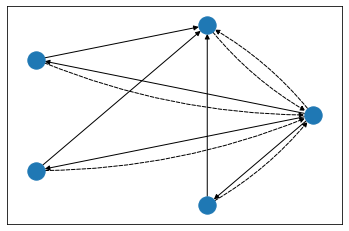

In [148]:
search_for_iso(M3_expansions,lattices_with_neg_from_comp_frames_size[4])

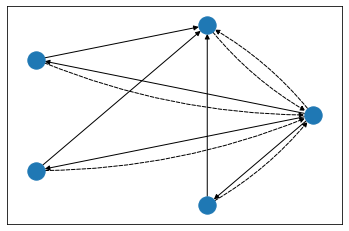

In [149]:
# Displaying the last expansion of M3 that is not representable by any 4-element compatibility frame

M3exp = M3_expansions[6]

display_lattice_with_neg(M3exp)

Next we find a 5-element compatibility frame that realizes the desired expansion of $\mathbf{M}_3$. Instead of performing the search with the next two cells, which takes several minutes, one can uncomment rel_for_M3exp in the third cell below.

In [150]:
lats_with_neg_keep_rels_from_comp_frames_size_5 = lattices_with_neg_keep_rels(comp_frames_size(5))
# Can skip this and uncomment rel_for_M3exp below

  0%|          | 0/9608 [00:00<?, ?it/s]

In [151]:
rel_for_M3exp = search_for_iso_keep_rels([M3exp],lats_with_neg_keep_rels_from_comp_frames_size_5)[M3exp]
print("\n")
print(f"Representing relation: {rel_for_M3exp}")

Can realize this lattice expansion (#0) of size 5.


Representing relation: [(0, 2), (2, 0), (0, 3), (3, 0), (4, 0), (1, 2), (2, 1), (3, 1), (1, 4), (4, 1), (2, 3), (2, 4), (3, 4), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]


Representing compatibility frame:


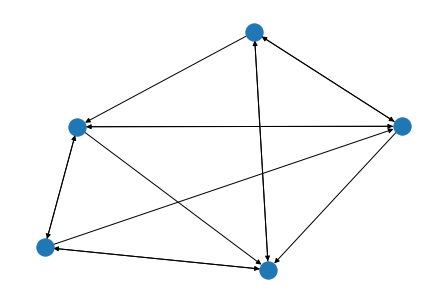

Fixpoint lattice:


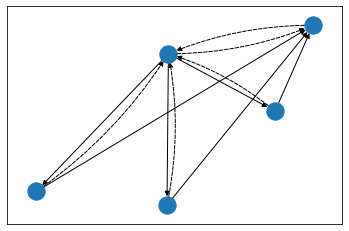

Check if isomorphic to the desired expansion of M3:
True


In [152]:
# Here is the 5-element compatibility frame that realizes the desired expansion of M3

print("Representing compatibility frame:")

# rel_for_M3exp = [(0, 2), (2, 0), (0, 3), (3, 0), (4, 0), (1, 2), (2, 1), (3, 1), (1, 4), (4, 1), (2, 3), (2, 4), (3, 4), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]

draw_flipped_digraph(rel_for_M3exp)

print("Fixpoint lattice:")
l = lattice_with_neg(rel_for_M3exp)

coveredges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==0]
negedges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==1]

pos = nx.spring_layout(l)
nx.draw_networkx_nodes(l,pos)
nx.draw_networkx_edges(l, pos, edgelist=coveredges)
nx.draw_networkx_edges(l, pos, edgelist=negedges,style="dashed",connectionstyle="arc3,rad=0.1")
plt.show() 

print("Check if isomorphic to the desired expansion of M3:")
print(nx.is_isomorphic(l,M3exp))


### Lattice expansions of size $\leq 5$

We now show that all lattices of size $\leq 5$ expanded with a protocomplementation can be represented by compatibility frames of size $\leq 5$.

In [153]:
m = 5 # the size of the lattice expansions

comp_frames_for_lats_size_leq_m = [pair[0] for pair in lattices_keep_rels(comp_frames_size(m-1)) if len(fixpoints(pair[0]))<= m]
# instead of running over all of comp_frames(m-1)
# we just use the graphs that we know are sufficient to generate all lattices of size \leq m up to isomorphism

fxpts_lats = [fixpoints(d) for d in comp_frames_for_lats_size_leq_m]

lats_size_leq_m_plus_protocomps = expand_all_with_protocomps(fxpts_lats,range(m-1))

  0%|          | 0/218 [00:00<?, ?it/s]

In [154]:
print("Number of lattice expansions up to iso from adding a protocomplementation to a lattice of size <=m:")
print(len(lats_size_leq_m_plus_protocomps))

print("Number of lattice expansions up to iso of size <=m arising from compatibility frames of size <=m:")
lats_size_leq_m_with_neg_from_comp_frames_size_leq_m = [l for l in lattices_with_neg_from_comp_frames_size[m] if len(l.nodes) <= m]
print(len(lats_size_leq_m_with_neg_from_comp_frames_size_leq_m))

Number of lattice expansions up to iso from adding a protocomplementation to a lattice of size <=m:
27
Number of lattice expansions up to iso of size <=m arising from compatibility frames of size <=m:
27


In [155]:
search_for_iso_keep_rels(lats_size_leq_m_plus_protocomps,lats_with_neg_keep_rels_from_comp_frames_size_5)

Can realize this lattice expansion (#0) of size 4.
Can realize this lattice expansion (#1) of size 4.
Can realize this lattice expansion (#2) of size 4.
Can realize this lattice expansion (#3) of size 5.
Can realize this lattice expansion (#4) of size 5.
Can realize this lattice expansion (#5) of size 5.
Can realize this lattice expansion (#6) of size 5.
Can realize this lattice expansion (#7) of size 5.
Can realize this lattice expansion (#8) of size 5.
Can realize this lattice expansion (#9) of size 5.
Can realize this lattice expansion (#10) of size 5.
Can realize this lattice expansion (#11) of size 5.
Can realize this lattice expansion (#12) of size 5.
Can realize this lattice expansion (#13) of size 5.
Can realize this lattice expansion (#14) of size 5.
Can realize this lattice expansion (#15) of size 5.
Can realize this lattice expansion (#16) of size 5.
Can realize this lattice expansion (#17) of size 5.
Can realize this lattice expansion (#18) of size 5.
Can realize this latti

{<networkx.classes.multidigraph.MultiDiGraph at 0x2dbb2af40>: [(0, 2),
  (2, 0),
  (0, 3),
  (3, 0),
  (4, 0),
  (3, 1),
  (1, 4),
  (4, 1),
  (2, 3),
  (3, 2),
  (4, 2),
  (3, 4),
  (4, 3),
  (0, 0),
  (1, 1),
  (2, 2),
  (3, 3),
  (4, 4)],
 <networkx.classes.multidigraph.MultiDiGraph at 0x2dafc1e20>: [(0, 2),
  (2, 0),
  (0, 4),
  (4, 0),
  (1, 3),
  (3, 1),
  (4, 1),
  (2, 4),
  (4, 2),
  (4, 3),
  (0, 0),
  (1, 1),
  (2, 2),
  (3, 3),
  (4, 4)],
 <networkx.classes.multidigraph.MultiDiGraph at 0x2c0afab50>: [(0, 2),
  (2, 0),
  (0, 4),
  (4, 0),
  (1, 3),
  (3, 1),
  (2, 4),
  (4, 2),
  (0, 0),
  (1, 1),
  (2, 2),
  (3, 3),
  (4, 4)],
 <networkx.classes.multidigraph.MultiDiGraph at 0x2d69293d0>: [(0, 2),
  (2, 0),
  (0, 4),
  (4, 0),
  (1, 3),
  (3, 1),
  (1, 4),
  (2, 4),
  (4, 2),
  (0, 0),
  (1, 1),
  (2, 2),
  (3, 3),
  (4, 4)],
 <networkx.classes.multidigraph.MultiDiGraph at 0x2d6929580>: [(0, 2),
  (2, 0),
  (0, 4),
  (4, 0),
  (1, 3),
  (3, 1),
  (1, 4),
  (4, 2),
  (3, 4),
 

### Lattice expansions of size 6

Finally, we show there is one lattice of size $6$ expanded with a protocomplementation that cannot be represented by a compatibility frame of size $\leq 6$, for which it suffices show that it cannot be represented by any compatibility frame of size 6.

In [156]:
comp_frames_for_lats_size_6 = [pair[0] for pair in lattices_keep_rels(comp_frames_size(5)) if len(fixpoints(pair[0])) == 6]

fxpts_lats_6 = [fixpoints(d) for d in comp_frames_for_lats_size_6]

lats_size_6_plus_protocomps = expand_all_with_protocomps(fxpts_lats_6,range(5))

  0%|          | 0/9608 [00:00<?, ?it/s]

In [157]:
print("Number of lattice expansions up to iso from adding a protocomplementation to a lattice of size 6:")
print(len(lats_size_6_plus_protocomps))

Number of lattice expansions up to iso from adding a protocomplementation to a lattice of size 6:
168


On my machine with digraph6.txt available, I applied the following function to comp_frames_size(6), 6. This computes all the lattices up to size 6 with negation up to isomorphism that arise from compatibility frames of size 6, saving the compatibility frame for each lattice. I then stored the list of compatibility frames in the file comp_frames_size_6_up_to_iso_of_lats_with_neg_size_6.pkl, which is in the generated directory.

In [158]:
def rels_for_lattices_with_neg_of_size(rels,n):
    """given a collection rels of relations, 
    only keeps those relations that give rise to 
    non-isomorphic fixpoints lattices of size n with neg operation""" 

    kept_rels = []
    lats = []

    for rel in tqdm(rels):
        l = lattice_with_neg(rel)
        if len(l.nodes) == n:
            newlat = True
            for l2 in lats:
                if nx.is_isomorphic(l,l2):
                    newlat = False
                    break
            if newlat:
                kept_rels.append(rel)
                lats.append(l)
    
    return kept_rels

In [159]:
#comp_frames_size_6_up_to_iso_of_lats_with_neg_size_6 = rels_for_lattices_with_neg_of_size(comp_frames_size(6),6)
#pickle.dump(rels_6, open("comp_frames_size_6_up_to_iso_of_lats_with_neg_size_6", "wb")) 

In [160]:
comp_frames_size_6_up_to_iso_of_lats_with_neg_size_6 = pickle.load(open("generated/comp_frames_size_6_up_to_iso_of_lats_with_neg_size_6.pkl", "rb"))

In [161]:
print("Number of lattice expansions up to iso of size 6 arising from compatibility frames of size 6:")
lats_size_6_with_neg_from_comp_frames_size_6 = [lattice_with_neg(d) for d in comp_frames_size_6_up_to_iso_of_lats_with_neg_size_6]
print(len(lats_size_6_with_neg_from_comp_frames_size_6))

Number of lattice expansions up to iso of size 6 arising from compatibility frames of size 6:
167


Below we display the one 6-element lattice with protocomplementation that does not arise from any compatibility frame of size 6.

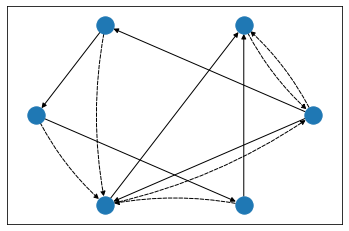

In [162]:
for l in lats_size_6_plus_protocomps:
    can_realize = False
    for l2 in lats_size_6_with_neg_from_comp_frames_size_6:
        if nx.is_isomorphic(l,l2): 
            can_realize = True
            break
            
    if not can_realize:
        display_lattice_with_neg(l)